In [1]:
state = 'AR' 
year = 2020
obj_type = 'cut_edges'
starting_deviation = 0.01 

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
G._ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of AR has 4 districts.


In [5]:
#import warm starts
sys.path.append(os.path.abspath('../heuristic'))

from AR_plans_2020 import plans
print(f"Loaded {len(plans)} plans from file.")
warm_starts = plans

Loaded 31272 plans from file.


In [6]:
from pareto import filter_and_sort_pareto
from metrics import scores

plans_scores = [scores(G, plan, G._ideal_population, obj_type) for plan in warm_starts]
_,_,nondominated_warm_starts_plans = filter_and_sort_pareto(plans=warm_starts, upper_bounds=plans_scores, obj_type=obj_type)
print(f"Selected {len(nondominated_warm_starts_plans)} nondominated warm start plans")

Selected 23 nondominated warm start plans


In [7]:
from epsilon_constraint import epsilon_constraint_method

(plans, obj_bounds, deviations) = epsilon_constraint_method(
            G,                 
            obj_type,          
            contiguity = 'lcut',                                             # {'lcut', 'scf', 'shir'} 
            cutoff=None,       
            verbose= True,
            warm_start_mode = 'user',                                        # {'None', 'user', 'refinement'}
            warm_starts=warm_starts,                                         # if you have user define warm starts else it is None
            starting_deviation=starting_deviation, 
            time_limit=7200, 
            sizes=None,      
            max_B=True,                                                      # If symmetry_breaking is 'orbitope' or you have warm_start, max_B should be True   
            symmetry_breaking='orbitope',                                    # {None, 'orbitope', 'rsum'} 
            state=state,
            year=year
        )

Initially, L = 745353 and U = 760409 and k = 4.

****************************************
Trying deviation = 7528.81
****************************************
Using user-provided warm starts.
Selected warm_start = [[4, 7, 17, 20, 30, 31, 50, 51, 52, 53, 61, 71], [6, 8, 9, 11, 18, 19, 21, 24, 25, 27, 28, 29, 33, 34, 35, 36, 40, 42, 45, 47, 48, 54, 55, 56, 57, 60, 64, 65, 66, 67, 72], [2, 3, 5, 10, 12, 13, 14, 15, 16, 26, 32, 38, 39, 41, 43, 44, 46, 49, 58, 59, 62, 63, 68, 69, 73, 74], [0, 1, 22, 23, 37, 70]]
Objective value: 32
Deviation: 4022.0

****************************************
Running labeling model!
****************************************
L = 745353 and U = 760409 and k = 4
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
sizes =  [1, 1, 1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Apply

     0     0   10.51003    0  409   33.00000   10.51003  68.2%     -    0s
     0     0   10.52715    0  414   33.00000   10.52715  68.1%     -    0s
     0     0   10.52715    0  414   33.00000   10.52715  68.1%     -    0s
     0     0   10.55735    0  414   33.00000   10.55735  68.0%     -    0s
     0     0   10.58016    0  413   33.00000   10.58016  67.9%     -    0s
     0     0   10.81231    0  421   33.00000   10.81231  67.2%     -    0s
     0     0   10.83248    0  422   33.00000   10.83248  67.2%     -    0s
     0     0   10.83367    0  420   33.00000   10.83367  67.2%     -    0s
     0     0   10.83429    0  421   33.00000   10.83429  67.2%     -    0s
     0     0   10.88842    0  431   33.00000   10.88842  67.0%     -    0s
     0     0   10.89549    0  432   33.00000   10.89549  67.0%     -    0s
     0     0   10.93667    0  430   33.00000   10.93667  66.9%     -    1s
     0     0   10.94356    0  433   33.00000   10.94356  66.8%     -    1s
     0     0   10.94646  

Selected warm_start = [[4, 7, 17, 20, 30, 50, 51, 52, 53, 63, 71], [2, 3, 5, 9, 10, 12, 13, 14, 15, 16, 26, 31, 32, 38, 39, 41, 43, 44, 46, 49, 58, 59, 62, 68, 69, 73, 74], [6, 8, 11, 18, 19, 21, 24, 25, 27, 28, 29, 33, 34, 35, 36, 40, 42, 45, 47, 48, 54, 55, 56, 57, 60, 61, 64, 65, 66, 67, 72], [0, 1, 22, 23, 37, 70]]
Objective value: 35
Deviation: 1127.0

****************************************
Running labeling model!
****************************************
L = 751285 and U = 754477 and k = 4
sizes =  [1, 1, 1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Applying warm start!
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set 

Variable types: 0 continuous, 2022 integer (2006 binary)

Root relaxation: objective 9.458167e+00, 2082 iterations, 0.09 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    9.45817    0  373   37.00000    9.45817  74.4%     -    0s
     0     0   10.25962    0  399   37.00000   10.25962  72.3%     -    0s
     0     0   10.27456    0  402   37.00000   10.27456  72.2%     -    0s
     0     0   10.27965    0  402   37.00000   10.27965  72.2%     -    0s
     0     0   10.59091    0  402   37.00000   10.59091  71.4%     -    0s
     0     0   10.59950    0  402   37.00000   10.59950  71.4%     -    0s
     0     0   10.61487    0  413   37.00000   10.61487  71.3%     -    0s
     0     0   10.61721    0  410   37.00000   10.61721  71.3%     -    0s
     0     0   10.67866    0  429   37.00000   10.67866  71.1%     -    0s
     0     0   10.71855   

Presolve time: 0.03s
Presolved: 2146 rows, 2024 columns, 7729 nonzeros
Variable types: 0 continuous, 2024 integer (2006 binary)

Root relaxation: objective 9.103255e+00, 2064 iterations, 0.08 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    9.10325    0  374   38.00000    9.10325  76.0%     -    0s
     0     0    9.85366    0  390   38.00000    9.85366  74.1%     -    0s
     0     0    9.90157    0  396   38.00000    9.90157  73.9%     -    0s
     0     0    9.99601    0  404   38.00000    9.99601  73.7%     -    0s
     0     0   10.00195    0  399   38.00000   10.00195  73.7%     -    0s
     0     0   10.00195    0  399   38.00000   10.00195  73.7%     -    0s
     0     0   10.33628    0  414   38.00000   10.33628  72.8%     -    0s
     0     0   10.34477    0  412   38.00000   10.34477  72.8%     -    0s
     0     0   10.51270    0  

Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 3887 rows, 3420 columns and 13387 nonzeros
Model fingerprint: 0x04c80bb6
Variable types: 900 continuous, 2520 integer (2520 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]

User MIP start produced solution with objective 40 (0.03s)
Loaded user MIP start with objective 40

Presolve removed 1741 rows and 1396 columns
Presolve time: 0.03s
Presolved: 2146 rows, 2024 columns, 7729 nonzeros
Variable types: 0 continuous, 202

 248186 56837     cutoff   33        40.00000   34.12389  14.7%   118  381s
 253102 57560   37.77943   34  339   40.00000   34.15452  14.6%   118  388s
 255685 57955   37.44284   35  329   40.00000   34.17735  14.6%   118  391s
 260694 58689 infeasible   34        40.00000   34.21665  14.5%   118  398s
 263330 58996   35.77483   30  408   40.00000   34.23426  14.4%   118  401s
 265899 59183     cutoff   29        40.00000   34.25062  14.4%   117  405s
 270749 59875   36.23274   30  404   40.00000   34.28804  14.3%   117  411s
 273312 60171   37.96665   34  320   40.00000   34.30435  14.2%   117  415s
 278429 60728 infeasible   29        40.00000   34.33897  14.2%   117  422s
 280850 60982   38.06078   35  505   40.00000   34.35553  14.1%   117  425s
 285645 61470     cutoff   32        40.00000   34.39122  14.0%   117  432s
 287972 61767     cutoff   39        40.00000   34.40983  14.0%   117  435s
 292867 62403   37.75611   30  285   40.00000   34.43833  13.9%   117  441s
 295414 6272

 658382 78929   37.87130   31  220   40.00000   36.17413  9.56%   105  923s
 661568 78829   36.35276   49  198   40.00000   36.18520  9.54%   105  926s
 665439 78630 infeasible   36        40.00000   36.20214  9.49%   105  930s
 669722 78396   37.15461   42  217   40.00000   36.21452  9.46%   105  935s
 673725 78105   36.67665   65  116   40.00000   36.23314  9.42%   104  941s
 678718 77884   38.64615   40  207   40.00000   36.25264  9.37%   104  946s
 682768 77611   37.45629   37  175   40.00000   36.26747  9.33%   104  950s
 686928 77247   38.38884   48  156   40.00000   36.28399  9.29%   104  955s
 691204 76940     cutoff   42        40.00000   36.29963  9.25%   104  960s
 695350 76594   37.12742   44  193   40.00000   36.31733  9.21%   104  965s
 699378 76195 infeasible   48        40.00000   36.33069  9.17%   104  970s
 705550 75802   36.98269   52  263   40.00000   36.35858  9.10%   104  977s
 707479 75484     cutoff   40        40.00000   36.36434  9.09%   104  981s
 712002 7509

Variable types: 900 continuous, 2520 integer (2520 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]

User MIP start produced solution with objective 41 (0.03s)
Loaded user MIP start with objective 41

Presolve removed 1740 rows and 1396 columns
Presolve time: 0.03s
Presolved: 2147 rows, 2024 columns, 7736 nonzeros
Variable types: 0 continuous, 2024 integer (2003 binary)

Root relaxation: objective 9.464518e+00, 2094 iterations, 0.09 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    9.46452    0  373   41.00000    9.46452  76.9%     -    0s
     0     0   10.29972    0  390   41.00000   10.29972  74.9%     -    0s
     0     0   10.88476    0  419   41.00000   10.88476  73.5%     -    0s
     0     0   10.92948    0  418   41.00

 268284 83114 infeasible   28        41.00000   33.98202  17.1%   108  387s
 270766 83772     cutoff   34        41.00000   33.99614  17.1%   108  391s
 273335 84458     cutoff   33        41.00000   34.00416  17.1%   108  395s
 278313 85497     cutoff   30        41.00000   34.03814  17.0%   108  401s
 280677 86139   34.26480   54  305   41.00000   34.05904  16.9%   108  405s
 285670 87481     cutoff   39        41.00000   34.08583  16.9%   108  412s
 288379 88113   38.41958   27  321   41.00000   34.10171  16.8%   108  416s
 293349 89138   36.52092   30  321   41.00000   34.13427  16.7%   108  423s
 295220 89674 infeasible   49        41.00000   34.14283  16.7%   108  426s
 300285 90917   37.00749   33  161   41.00000   34.17108  16.7%   107  433s
 302909 91563     cutoff   37        41.00000   34.18965  16.6%   107  437s
 305480 92162   36.00000   26  258   41.00000   34.20173  16.6%   107  441s
 310644 93531   39.38805   35  347   41.00000   34.23274  16.5%   107  448s
 313160 9413

 625559 160246   36.07185   36  189   41.00000   35.36778  13.7%  98.6  922s
 628205 160769 infeasible   48        41.00000   35.37609  13.7%  98.6  926s
 630826 161333   38.47106   40  270   41.00000   35.38231  13.7%  98.5  931s
 633583 161798   38.28596   46  167   41.00000   35.38833  13.7%  98.5  935s
 638843 162840   36.19477   51  147   41.00000   35.40064  13.7%  98.4  943s
 641389 163237 infeasible   52        41.00000   35.40558  13.6%  98.3  947s
 643972 163734 infeasible   36        41.00000   35.41158  13.6%  98.2  951s
 646645 164270   36.79027   46  197   41.00000   35.41801  13.6%  98.2  956s
 649368 164773   35.79197   31  201   41.00000   35.42412  13.6%  98.1  960s
 654948 165704     cutoff   43        41.00000   35.43658  13.6%  98.0  968s
 657633 166094 infeasible   48        41.00000   35.44319  13.6%  98.0  972s
 660109 166502   38.81878   37  109   41.00000   35.44950  13.5%  97.9  976s
 662800 166976 infeasible   46        41.00000   35.45647  13.5%  97.9  980s

 944464 210809   38.32289   51  255   41.00000   36.03272  12.1%  93.6 1458s
 947064 211155 infeasible   51        41.00000   36.04032  12.1%  93.6 1462s
 949729 211541   38.30155   48  181   41.00000   36.04473  12.1%  93.5 1466s
 952417 212106   37.25940   38  229   41.00000   36.04879  12.1%  93.5 1470s
 957748 212862   38.45005   45   90   41.00000   36.05743  12.1%  93.4 1478s
 960554 213276     cutoff   32        41.00000   36.06136  12.0%  93.4 1483s
 963231 213627   36.72415   53  114   41.00000   36.06515  12.0%  93.4 1487s
 965894 214115   38.44511   27  326   41.00000   36.07071  12.0%  93.3 1491s
 968587 214466 infeasible   59        41.00000   36.07446  12.0%  93.3 1495s
 974018 215446     cutoff   40        41.00000   36.08410  12.0%  93.2 1503s
 976641 215829   37.09658   56  174   41.00000   36.08804  12.0%  93.2 1507s
 979336 216269 infeasible   41        41.00000   36.09187  12.0%  93.2 1511s
 982009 216688   38.04163   40  295   41.00000   36.09608  12.0%  93.1 1515s

 1282198 252166   38.70974   39  253   41.00000   36.50788  11.0%  89.6 1988s
 1284993 252406 infeasible   71        41.00000   36.51201  10.9%  89.6 1992s
 1287762 252623   38.69743   42  362   41.00000   36.51485  10.9%  89.5 1997s
 1290584 252873   37.21607   49  170   41.00000   36.51933  10.9%  89.5 2001s
 1293367 253079   38.44506   34  202   41.00000   36.52287  10.9%  89.5 2005s
 1296204 253313   38.74296   27  256   41.00000   36.52577  10.9%  89.4 2010s
 1301658 253763 infeasible   34        41.00000   36.53355  10.9%  89.4 2018s
 1304378 253876   37.86348   50  231   41.00000   36.53651  10.9%  89.4 2021s
 1305205 254073   37.91935   51  281   41.00000   36.53702  10.9%  89.4 2025s
 1310447 254561   38.32939   34  207   41.00000   36.54418  10.9%  89.3 2033s
 1313122 254786     cutoff   32        41.00000   36.54800  10.9%  89.3 2038s
 1315881 254918   39.03711   32  241   41.00000   36.55088  10.9%  89.3 2042s
 1318152 255155 infeasible   56        41.00000   36.55399  10.8

 1616708 272344     cutoff   32        41.00000   36.92190  9.95%  86.6 2528s
 1619567 272467   37.13079   41  171   41.00000   36.92556  9.94%  86.6 2533s
 1622462 272541     cutoff   36        41.00000   36.92824  9.93%  86.6 2537s
 1625217 272491   38.09810   31  414   41.00000   36.93179  9.92%  86.6 2540s
 1629285 272616 infeasible   57        41.00000   36.93643  9.91%  86.5 2547s
 1632025 272733   38.93216   31  550   41.00000   36.94024  9.90%  86.5 2551s
 1634853 272842   38.42117   40  143   41.00000   36.94241  9.90%  86.5 2556s
 1637780 273031   37.70446   32  235   41.00000   36.94613  9.89%  86.5 2561s
 1640618 273161   38.27426   30  390   41.00000   36.94958  9.88%  86.5 2565s
 1645542 273228   38.44449   44  202   41.00000   36.95560  9.86%  86.4 2574s
 1648267 273350   39.69170   31  305   41.00000   36.95871  9.86%  86.4 2579s
 1651196 273449   37.39932   32  207   41.00000   36.96133  9.85%  86.4 2583s
 1653938 273599   38.46825   29  363   41.00000   36.96386  9.84

 1957917 278382   37.66206   34  238   41.00000   37.26102  9.12%  84.5 3066s
 1961993 278330   37.85409   41  212   41.00000   37.26487  9.11%  84.5 3071s
 1966123 278256     cutoff   44        41.00000   37.26876  9.10%  84.5 3077s
 1968062 278204   37.94953   46  186   41.00000   37.27102  9.10%  84.5 3080s
 1972377 278049 infeasible   51        41.00000   37.27453  9.09%  84.5 3087s
 1974367 277964   38.29694   46  141   41.00000   37.27629  9.08%  84.4 3091s
 1979098 277765   38.91120   50  160   41.00000   37.28029  9.07%  84.4 3097s
 1981078 277716   39.77978   28  199   41.00000   37.28268  9.07%  84.4 3100s
 1986029 277657     cutoff   38        41.00000   37.28682  9.06%  84.4 3107s
 1987922 277615     cutoff   41        41.00000   37.28907  9.05%  84.4 3110s
 1992021 277325 infeasible   53        41.00000   37.29262  9.04%  84.4 3115s
 1996189 277160   38.72518   40  179   41.00000   37.29693  9.03%  84.3 3122s
 1998946 277010   39.37976   40  281   41.00000   37.29967  9.03

 2299952 248990 infeasible   43        41.00000   37.60364  8.28%  83.0 3595s
 2304043 248413   37.80490   46   44   41.00000   37.60836  8.27%  82.9 3602s
 2305982 248141   38.41747   56   76   41.00000   37.61053  8.27%  82.9 3605s
 2309994 247624 infeasible   49        41.00000   37.61485  8.26%  82.9 3612s
 2311567 247314     cutoff   31        41.00000   37.61687  8.25%  82.9 3616s
 2313814 246934 infeasible   37        41.00000   37.61891  8.25%  82.9 3620s
 2318012 246378   38.95949   39  195   41.00000   37.62313  8.24%  82.9 3627s
 2320164 246107   39.50682   41  135   41.00000   37.62519  8.23%  82.9 3631s
 2322313 245770   38.24296   36  145   41.00000   37.62817  8.22%  82.9 3635s
 2326665 244991     cutoff   44        41.00000   37.63232  8.21%  82.9 3643s
 2328727 244682 infeasible   40        41.00000   37.63517  8.21%  82.8 3646s
 2330694 244380   38.67001   48  151   41.00000   37.63705  8.20%  82.8 3650s
 2334809 244053   38.14877   36  210   41.00000   37.64101  8.19

 2595314 193121     cutoff   41        41.00000   37.94940  7.44%  81.8 4127s
 2597335 192688     cutoff   57        41.00000   37.95122  7.44%  81.8 4131s
 2599367 192144   38.82106   49  270   41.00000   37.95395  7.43%  81.7 4135s
 2603484 191154 infeasible   40        41.00000   37.95969  7.42%  81.7 4142s
 2605479 190753     cutoff   57        41.00000   37.96278  7.41%  81.7 4145s
 2609483 190082   39.23183   40  102   41.00000   37.96765  7.40%  81.7 4152s
 2610959 189636   39.05837   32  408   41.00000   37.96952  7.39%  81.7 4156s
 2613186 189134 infeasible   37        41.00000   37.97133  7.39%  81.7 4160s
 2617396 188253   39.05455   35  364   41.00000   37.97722  7.37%  81.7 4167s
 2619463 187783 infeasible   48        41.00000   37.97900  7.37%  81.7 4171s
 2621521 187314     cutoff   50        41.00000   37.98178  7.36%  81.7 4175s
 2625609 186411 infeasible   35        41.00000   37.98750  7.35%  81.7 4182s
 2627734 185940     cutoff   67        41.00000   37.98998  7.34

 2891016 107766   38.52905   44   51   41.00000   38.34641  6.47%  80.8 4656s
 2895111 105917   39.53933   29  349   41.00000   38.35472  6.45%  80.8 4662s
 2897180 105052   38.64321   41  235   41.00000   38.35835  6.44%  80.8 4666s
 2901305 103080     cutoff   54        41.00000   38.36580  6.42%  80.8 4673s
 2903438 102149     cutoff   50        41.00000   38.37026  6.41%  80.8 4676s
 2905457 101205 infeasible   46        41.00000   38.37428  6.40%  80.8 4680s
 2909558 99287     cutoff   35        41.00000   38.38234  6.38%  80.8 4686s
 2911632 98319     cutoff   42        41.00000   38.38644  6.37%  80.8 4690s
 2915708 96431 infeasible   26        41.00000   38.39450  6.35%  80.7 4696s
 2917811 95513     cutoff   43        41.00000   38.39896  6.34%  80.7 4700s
 2921945 93485   39.00548   48  245   41.00000   38.40713  6.32%  80.7 4707s
 2924098 92485 infeasible   44        41.00000   38.41121  6.31%  80.7 4711s
 2928328 90533 infeasible   38        41.00000   38.41979  6.29%  80.7

     0     0   11.09269    0  441   45.00000   11.09269  75.3%     -    0s
     0     0   11.10406    0  437   45.00000   11.10406  75.3%     -    0s
     0     0   11.10406    0  443   45.00000   11.10406  75.3%     -    0s
     0     0   11.22064    0  423   45.00000   11.22064  75.1%     -    1s
     0     0   11.23250    0  429   45.00000   11.23250  75.0%     -    1s
     0     0   11.25194    0  436   45.00000   11.25194  75.0%     -    1s
     0     0   11.25437    0  440   45.00000   11.25437  75.0%     -    1s
     0     0   11.25437    0  444   45.00000   11.25437  75.0%     -    1s
     0     0   11.25903    0  445   45.00000   11.25903  75.0%     -    1s
     0     0   11.26671    0  445   45.00000   11.26671  75.0%     -    1s
     0     2   11.28603    0  445   45.00000   11.28603  74.9%     -    1s
   912   838   35.49113   15  417   45.00000   17.53688  61.0%   172    5s
  2117  1661   20.55041   15  461   45.00000   20.55041  54.3%   141   10s
  3083  2141   35.56403  

 418754 206630   35.62459   31  243   45.00000   34.52332  23.3%   107  493s
 421446 207718   40.95821   37  321   45.00000   34.53020  23.3%   107  495s
 426084 210023 infeasible   41        45.00000   34.54683  23.2%   107  501s
 431166 212263   40.75860   49  222   45.00000   34.56584  23.2%   107  507s
 433460 213176   42.18768   36  362   45.00000   34.57171  23.2%   107  510s
 438611 215317   37.92007   38  302   45.00000   34.58409  23.1%   107  515s
 443797 217460   43.47368   35  328   45.00000   34.59987  23.1%   106  521s
 448775 219716   38.25191   29  413   45.00000   34.61657  23.1%   106  527s
 451240 220696   35.59594   29  377   45.00000   34.62365  23.1%   106  530s
 456198 222960     cutoff   34        45.00000   34.63758  23.0%   106  536s
 461261 225281   42.67838   48  111   45.00000   34.65243  23.0%   106  542s
 463431 226547   36.41390   29  474   45.00000   34.66109  23.0%   106  545s
 468721 228891   39.46646   39  249   45.00000   34.67411  22.9%   106  551s

 870702 406121   40.20059   28  405   45.00000   35.48729  21.1%  99.1 1026s
 875696 408199     cutoff   44        45.00000   35.49338  21.1%  99.1 1032s
 880676 410252   37.24865   30  203   45.00000   35.49829  21.1%  99.0 1038s
 883168 411323   42.81997   48  146   45.00000   35.50374  21.1%  99.0 1041s
 888057 413376     cutoff   38        45.00000   35.51159  21.1%  99.0 1046s
 890552 414538   36.09441   37  210   45.00000   35.51546  21.1%  98.9 1050s
 895783 417081   38.23901   30  378   45.00000   35.52399  21.1%  98.9 1056s
 901014 419414   38.04829   41  147   45.00000   35.53025  21.0%  98.8 1063s
 903761 420593   39.16604   34  133   45.00000   35.53454  21.0%  98.7 1066s
 906253 421829   42.32783   61   44   45.00000   35.53837  21.0%  98.7 1070s
 911213 423966   41.92774   31  283   45.00000   35.54449  21.0%  98.7 1076s
 916285 426230   40.01212   33  228   45.00000   35.55213  21.0%  98.6 1082s
 918818 427242   43.53825   47  181   45.00000   35.55666  21.0%  98.5 1085s

 1240877 558316   40.10366   38  296   45.00000   35.96640  20.1%  96.1 1558s
 1243329 559345   40.50314   48  232   45.00000   35.97002  20.1%  96.1 1561s
 1245732 560385   42.53139   38  216   45.00000   35.97239  20.1%  96.1 1565s
 1250578 562440   42.69971   41  111   45.00000   35.97866  20.0%  96.0 1573s
 1252928 563460 infeasible   90        45.00000   35.98134  20.0%  96.0 1576s
 1255345 564362   42.30974   33  316   45.00000   35.98458  20.0%  96.0 1580s
 1260184 566214   42.01442   59  134   45.00000   35.98871  20.0%  96.0 1587s
 1262144 567329   38.22350   32  298   45.00000   35.99074  20.0%  96.0 1592s
 1264516 568403   40.39257   54  158   45.00000   35.99361  20.0%  96.0 1595s
 1267056 569543   41.84148   30  250   45.00000   35.99595  20.0%  95.9 1600s
 1272259 571776   39.00843   43  212   45.00000   36.00000  20.0%  95.9 1608s
 1274751 572845   43.50583   35  286   45.00000   36.00000  20.0%  95.9 1612s
 1277271 573681   38.90414   40  221   45.00000   36.00101  20.0

 1547406 680697     cutoff   37        45.00000   36.24264  19.5%  94.6 2088s
 1549790 681654   42.79403   34  235   45.00000   36.24518  19.5%  94.5 2093s
 1552374 682476 infeasible   40        45.00000   36.24712  19.5%  94.5 2096s
 1554643 683304   37.22088   55  330   45.00000   36.24814  19.4%  94.5 2101s
 1557039 684332   38.49830   54  212   45.00000   36.25005  19.4%  94.5 2106s
 1559664 685267   42.47244   32  393   45.00000   36.25212  19.4%  94.5 2110s
 1564594 686875   41.63421   63  177   45.00000   36.25614  19.4%  94.5 2119s
 1566960 687812   40.35858   34  213   45.00000   36.25787  19.4%  94.5 2123s
 1569589 688865   39.26422   56   52   45.00000   36.26007  19.4%  94.5 2128s
 1572185 689943   39.52412   56   43   45.00000   36.26209  19.4%  94.4 2132s
 1574791 690746   42.07026   55   56   45.00000   36.26408  19.4%  94.4 2136s
 1577207 691945   38.94247   36  261   45.00000   36.26542  19.4%  94.4 2140s
 1582247 693710   39.03344   48  204   45.00000   36.27027  19.4

 1861329 800562   40.92815   40  187   45.00000   36.46941  19.0%  92.9 2615s
 1866370 802359   41.18491   37  165   45.00000   36.47239  19.0%  92.8 2624s
 1868771 803399     cutoff   49        45.00000   36.47412  18.9%  92.8 2628s
 1871339 804312   37.67397   37  107   45.00000   36.47540  18.9%  92.8 2632s
 1873851 805282   38.62606   35  156   45.00000   36.47751  18.9%  92.8 2636s
 1876404 806195 infeasible   35        45.00000   36.47904  18.9%  92.8 2641s
 1878801 807094   41.66913   36  232   45.00000   36.48055  18.9%  92.8 2645s
 1881334 807993     cutoff   37        45.00000   36.48235  18.9%  92.8 2650s
 1886676 810060   43.31858   32  296   45.00000   36.48597  18.9%  92.7 2659s
 1889128 811128     cutoff   26        45.00000   36.48757  18.9%  92.7 2663s
 1891797 811962   40.46953   30  290   45.00000   36.48905  18.9%  92.7 2668s
 1894250 813006   42.12913   35  383   45.00000   36.49098  18.9%  92.7 2672s
 1896732 813762   42.52826   34  341   45.00000   36.49193  18.9

 2170612 914611   41.35326   31  196   45.00000   36.66055  18.5%  91.5 3145s
 2175050 916245   39.27642   56  156   45.00000   36.66312  18.5%  91.5 3154s
 2177602 917239   41.81974   52  120   45.00000   36.66497  18.5%  91.5 3158s
 2180058 917538 infeasible   46        45.00000   36.66665  18.5%  91.5 3161s
 2180922 918456   38.24456   43  113   45.00000   36.66713  18.5%  91.5 3166s
 2183325 919449   39.28410   62   37   45.00000   36.66849  18.5%  91.5 3171s
 2188108 921142     cutoff   44        45.00000   36.67144  18.5%  91.4 3179s
 2190494 921799   41.40491   38  247   45.00000   36.67292  18.5%  91.4 3183s
 2192851 922477 infeasible   39        45.00000   36.67430  18.5%  91.4 3187s
 2195252 923334 infeasible   57        45.00000   36.67615  18.5%  91.4 3191s
 2197560 924168   42.42796   45  121   45.00000   36.67767  18.5%  91.4 3195s
 2202634 925247   38.11195   45  211   45.00000   36.67999  18.5%  91.4 3202s
 2202938 926021 infeasible   46        45.00000   36.67999  18.5

 2462953 1019647   38.51986   53   82   45.00000   36.82778  18.2%  90.5 3678s
 2465266 1020367   41.42890   41  275   45.00000   36.82950  18.2%  90.5 3682s
 2467614 1021129   38.22746   66   92   45.00000   36.83107  18.2%  90.5 3687s
 2469998 1021931   38.17927   63   69   45.00000   36.83171  18.2%  90.5 3691s
 2472419 1022818 infeasible   36        45.00000   36.83331  18.1%  90.5 3697s
 2474878 1023872   41.89933   45  159   45.00000   36.83512  18.1%  90.5 3701s
 2477510 1024641   41.26714   35  322   45.00000   36.83647  18.1%  90.5 3706s
 2479837 1025486 infeasible   48        45.00000   36.83795  18.1%  90.5 3710s
 2482380 1026266   40.33266   30  124   45.00000   36.83890  18.1%  90.5 3715s
 2484913 1027074   38.61792   36  334   45.00000   36.84034  18.1%  90.5 3722s
 2486982 1027998   40.57784   55  176   45.00000   36.84088  18.1%  90.5 3726s
 2489293 1028855   39.87797   32  390   45.00000   36.84177  18.1%  90.4 3731s
 2491673 1029893   41.10263   32  315   45.00000   3

 2731921 1115998   42.39525   42  253   45.00000   36.97159  17.8%  89.8 4225s
 2734205 1116879   41.43028   62   36   45.00000   36.97266  17.8%  89.8 4230s
 2736742 1117793 infeasible   34        45.00000   36.97385  17.8%  89.7 4235s
 2739225 1118752   43.71384   40  164   45.00000   36.97521  17.8%  89.7 4240s
 2741719 1119675     cutoff   53        45.00000   36.97663  17.8%  89.7 4245s
 2744141 1120550     cutoff   47        45.00000   36.97814  17.8%  89.7 4250s
 2746617 1121432   38.21180   65  120   45.00000   36.97902  17.8%  89.7 4255s
 2751424 1123184   39.98498   60  185   45.00000   36.98161  17.8%  89.7 4264s
 2753837 1124099   41.37438   58  133   45.00000   36.98202  17.8%  89.7 4269s
 2756323 1125012     cutoff   73        45.00000   36.98390  17.8%  89.7 4274s
 2758655 1125890   41.98615   39  415   45.00000   36.98514  17.8%  89.7 4279s
 2761092 1126732 infeasible   34        45.00000   36.98611  17.8%  89.7 4283s
 2763431 1127545   40.52886   70  121   45.00000   3

 2986637 1208878   39.96046   48   64   45.00000   37.08016  17.6%  89.2 4768s
 2989185 1209657   38.86453   71  119   45.00000   37.08153  17.6%  89.2 4774s
 2991758 1210479     cutoff   41        45.00000   37.08257  17.6%  89.2 4779s
 2994270 1211418   40.37379   36  213   45.00000   37.08338  17.6%  89.2 4786s
 2996768 1212282   42.16697   32  159   45.00000   37.08444  17.6%  89.2 4791s
 2999330 1213208   39.07397   58  105   45.00000   37.08550  17.6%  89.1 4797s
 3001779 1213377   38.50297   44  311   45.00000   37.08652  17.6%  89.1 4800s
 3002215 1214119 infeasible   43        45.00000   37.08652  17.6%  89.1 4805s
 3006549 1215861     cutoff   44        45.00000   37.08789  17.6%  89.1 4815s
 3008963 1216765 infeasible   36        45.00000   37.08948  17.6%  89.1 4820s
 3011373 1217767   41.47125   44  188   45.00000   37.09057  17.6%  89.1 4826s
 3013865 1218823   40.41499   58   78   45.00000   37.09156  17.6%  89.1 4832s
 3016437 1219839     cutoff   54        45.00000   3

 3234232 1296364   41.72229   38  243   45.00000   37.18051  17.4%  88.6 5340s
 3234525 1297377   40.72402   55   29   45.00000   37.18113  17.4%  88.6 5346s
 3237085 1298138   38.07067   38  248   45.00000   37.18229  17.4%  88.6 5352s
 3239510 1299054     cutoff   36        45.00000   37.18289  17.4%  88.6 5358s
 3241970 1300008   39.56168   33  263   45.00000   37.18359  17.4%  88.6 5363s
 3244256 1300695   40.71023   40  174   45.00000   37.18458  17.4%  88.6 5369s
 3246624 1301537   42.80261   40  206   45.00000   37.18552  17.4%  88.6 5374s
 3249096 1302369 infeasible   43        45.00000   37.18626  17.4%  88.6 5380s
 3251354 1303486     cutoff   40        45.00000   37.18747  17.4%  88.6 5386s
 3253938 1304200   42.64785   35  339   45.00000   37.18855  17.4%  88.6 5391s
 3256210 1305051     cutoff   56        45.00000   37.18931  17.4%  88.6 5397s
 3258618 1305715   40.46782   50  184   45.00000   37.19014  17.4%  88.6 5403s
 3260841 1306593   41.77295   51  212   45.00000   3

 3466902 1376146   40.81540   38  259   45.00000   37.26793  17.2%  88.2 5925s
 3469012 1376807   38.53794   29  346   45.00000   37.26870  17.2%  88.2 5930s
 3470993 1377490   43.19842   44  238   45.00000   37.26927  17.2%  88.2 5936s
 3473198 1378145     cutoff   56        45.00000   37.26990  17.2%  88.2 5942s
 3475473 1378808     cutoff   35        45.00000   37.27085  17.2%  88.2 5948s
 3477435 1379376   42.58358   43  164   45.00000   37.27155  17.2%  88.2 5952s
 3479260 1380099   42.99872   36  345   45.00000   37.27250  17.2%  88.2 5958s
 3481349 1380814   41.99377   51   54   45.00000   37.27301  17.2%  88.2 5964s
 3483116 1380814   38.39010   43  175   45.00000   37.27363  17.2%  88.2 5965s
 3483475 1381437 infeasible   47        45.00000   37.27404  17.2%  88.2 5970s
 3485608 1382045   41.90716   34  469   45.00000   37.27499  17.2%  88.2 5976s
 3487576 1382753   40.32065   75  132   45.00000   37.27556  17.2%  88.2 5981s
 3489609 1383339     cutoff   54        45.00000   3

 3684968 1447379   40.81128   66   72   45.00000   37.34751  17.0%  87.9 6539s
 3687463 1448054     cutoff   35        45.00000   37.34846  17.0%  87.9 6545s
 3689720 1448814   41.34822   43  102   45.00000   37.34913  17.0%  87.9 6552s
 3692131 1449608   40.55305   31  229   45.00000   37.35002  17.0%  87.9 6559s
 3694523 1450470     cutoff   30        45.00000   37.35063  17.0%  87.9 6566s
 3696974 1451181   38.51689   51  127   45.00000   37.35140  17.0%  87.9 6572s
 3699151 1451849   41.12889   58  138   45.00000   37.35241  17.0%  87.9 6578s
 3701339 1452546   37.92218   45  180   45.00000   37.35319  17.0%  87.9 6585s
 3703535 1453359 infeasible   36        45.00000   37.35405  17.0%  87.9 6591s
 3705890 1453982     cutoff   33        45.00000   37.35495  17.0%  87.9 6598s
 3708116 1454642   40.24809   47  126   45.00000   37.35539  17.0%  87.9 6605s
 3710514 1455335   39.46243   46  163   45.00000   37.35640  17.0%  87.9 6611s
 3712565 1456191   43.14378   37  277   45.00000   3

  RLT: 10
  Lazy constraints: 44

Explored 3914273 nodes (342952281 simplex iterations) in 7200.83 seconds (1662.67 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 45 

Time limit reached
Best objective 4.500000000000e+01, best bound 3.800000000000e+01, gap 15.5556%

User-callback calls 8046687, time in user-callback 25.40 sec
Time limit reached! Best feasible solution found:

****************************************
No optimal solution found! Gurobi status: 9
****************************************
plan = [[19, 20, 21, 24, 25, 27, 33, 35, 36, 40, 45, 48, 56, 57, 64, 65, 66, 72], [0, 1, 6, 11, 18, 28, 37, 42, 54, 55, 60, 70], [4, 5, 7, 17, 22, 23, 30, 31, 41, 47, 50, 51, 52, 53, 61, 67, 71], [2, 3, 8, 9, 10, 12, 13, 14, 15, 16, 26, 29, 32, 34, 38, 39, 43, 44, 46, 49, 58, 59, 62, 63, 68, 69, 73, 74]]

****************************************
Trying deviation = 193.875
****************************************
Using user-provided warm starts.
Selected warm

 172596 94402   36.63645   34  347   46.00000   31.56165  31.4%   115  255s
 176998 96456   35.70391   34  460   46.00000   31.61361  31.3%   115  262s
 179310 97638   43.83682   44  293   46.00000   31.64706  31.2%   115  265s
 184169 100220     cutoff   54        46.00000   31.70885  31.1%   115  271s
 188917 102738   37.78612   34  428   46.00000   31.76793  30.9%   114  276s
 191246 104019   38.19952   34  382   46.00000   31.79370  30.9%   114  280s
 196033 106571   34.12997   30  306   46.00000   31.84594  30.8%   114  285s
 200611 108971   37.01533   31  318   46.00000   31.88771  30.7%   114  291s
 205519 111557   32.35538   33  249   46.00000   31.94538  30.6%   114  297s
 208045 111763   36.61417   44  372   46.00000   31.97356  30.5%   114  301s
 210324 113853   35.23915   31  330   46.00000   31.98967  30.5%   113  307s
 212624 115027   35.56485   31  378   46.00000   32.01290  30.4%   113  311s
 217492 117423     cutoff   41        46.00000   32.06497  30.3%   113  317s
 2

 535659 271307   41.91560   35  472   46.00000   33.86429  26.4%   106  791s
 538316 272244   40.25838   37  215   46.00000   33.86953  26.4%   106  795s
 542876 274763   40.61850   33  303   46.00000   33.89250  26.3%   106  802s
 545399 275890     cutoff   43        46.00000   33.90008  26.3%   106  805s
 550300 278040   42.19237   53  250   46.00000   33.91822  26.3%   106  813s
 552688 279150   39.66833   36  411   46.00000   33.92622  26.2%   106  816s
 557488 280390     cutoff   41        46.00000   33.94037  26.2%   105  820s
 559961 282515   41.78080   33  459   46.00000   33.95033  26.2%   105  826s
 562286 283791   43.17361   33  375   46.00000   33.95922  26.2%   105  830s
 567077 286103   36.65248   35  215   46.00000   33.97573  26.1%   105  837s
 569516 287352   35.45954   63  206   46.00000   33.98365  26.1%   105  840s
 574479 289744   43.94761   39  202   46.00000   33.99961  26.1%   105  848s
 577053 290530   40.27746   36  254   46.00000   34.00575  26.1%   105  852s

 839915 410817   43.98858   55  150   46.00000   34.65434  24.7%   101 1329s
 842257 412044   42.94869   50  214   46.00000   34.65894  24.7%   101 1334s
 844826 413337     cutoff   51        46.00000   34.66394  24.6%   101 1339s
 847420 414353     cutoff   33        46.00000   34.66857  24.6%   101 1344s
 849787 415316   39.85979   79  100   46.00000   34.67509  24.6%   101 1349s
 852223 416404   42.31300   36  386   46.00000   34.67811  24.6%   101 1354s
 854609 417441   43.26445   44  132   46.00000   34.68347  24.6%   101 1359s
 856924 418496     cutoff   38        46.00000   34.68924  24.6%   101 1364s
 859314 419694   38.76682   48  298   46.00000   34.69292  24.6%   101 1369s
 861730 420754   44.45186   33  296   46.00000   34.69828  24.6%   101 1375s
 864158 421628   38.00434   33  411   46.00000   34.70319  24.6%   101 1380s
 866070 422516   43.27711   50   28   46.00000   34.70717  24.5%   101 1385s
 868512 423496   39.37608   35  235   46.00000   34.71043  24.5%   101 1390s

 1094761 524102   36.52589   46  173   46.00000   35.08647  23.7%  98.3 1902s
 1097374 525079 infeasible   34        46.00000   35.09107  23.7%  98.3 1907s
 1099570 526143   41.14755   46  213   46.00000   35.09342  23.7%  98.3 1913s
 1101927 527254 infeasible   39        46.00000   35.09833  23.7%  98.3 1919s
 1104488 528293   42.08156   46  249   46.00000   35.10085  23.7%  98.2 1924s
 1106949 529511   37.58904   75  234   46.00000   35.10465  23.7%  98.2 1929s
 1109457 530672   41.07635   33  285   46.00000   35.10759  23.7%  98.2 1936s
 1112209 531656     cutoff   42        46.00000   35.11176  23.7%  98.2 1941s
 1114598 532680   39.40249   61  222   46.00000   35.11482  23.7%  98.1 1947s
 1116976 533787   39.73380   42  263   46.00000   35.11839  23.7%  98.1 1953s
 1119413 534975   44.38279   43  237   46.00000   35.12293  23.6%  98.1 1958s
 1122021 536048 infeasible   48        46.00000   35.12578  23.6%  98.1 1963s
 1124162 537319   39.21854   31  304   46.00000   35.12988  23.6

 1366767 648317     cutoff   41        46.00000   35.41539  23.0%  95.5 2493s
 1369227 649391   38.89014   30  386   46.00000   35.41847  23.0%  95.5 2498s
 1372012 650420     cutoff   40        46.00000   35.42067  23.0%  95.5 2504s
 1374352 651587   39.81524   44  160   46.00000   35.42373  23.0%  95.5 2509s
 1376968 652643   42.91361   69  188   46.00000   35.42615  23.0%  95.4 2514s
 1379580 653825   44.60077   38  129   46.00000   35.42885  23.0%  95.4 2519s
 1381954 653825   38.49701   52  125   46.00000   35.42958  23.0%  95.4 2520s
 1382318 654955   44.36457   36  291   46.00000   35.43137  23.0%  95.4 2525s
 1384758 655939   42.71079   43  399   46.00000   35.43470  23.0%  95.4 2531s
 1387403 656867   41.76539   37  398   46.00000   35.43725  23.0%  95.4 2538s
 1389118 657982   36.48592   39  363   46.00000   35.43769  23.0%  95.3 2543s
 1391572 658888   37.13619   32  268   46.00000   35.44188  23.0%  95.3 2548s
 1394087 660105     cutoff   58        46.00000   35.44402  22.9

 1641864 769431   40.57547   66  167   46.00000   35.68175  22.4%  92.9 3052s
 1644675 770466     cutoff   42        46.00000   35.68413  22.4%  92.9 3057s
 1647321 771494   40.81517   37  254   46.00000   35.68623  22.4%  92.9 3062s
 1650005 772657   41.90483   36  363   46.00000   35.68884  22.4%  92.9 3068s
 1652750 773827   39.98518   31  251   46.00000   35.69189  22.4%  92.8 3073s
 1655389 774791   38.28773   35  421   46.00000   35.69530  22.4%  92.8 3078s
 1657880 775946   40.46866   35  414   46.00000   35.69660  22.4%  92.8 3084s
 1660638 777134   42.61181   45  315   46.00000   35.70025  22.4%  92.8 3089s
 1663348 778211   41.91135   52  349   46.00000   35.70119  22.4%  92.8 3094s
 1665781 779396   41.76355   51  152   46.00000   35.70386  22.4%  92.8 3099s
 1668486 780057   43.34605   52   64   46.00000   35.70525  22.4%  92.7 3104s
 1670014 781091   43.10224   71  238   46.00000   35.70693  22.4%  92.7 3110s
 1672728 782252   37.09003   45  204   46.00000   35.70954  22.4

 1908927 886401   40.51063   44  292   46.00000   35.89593  22.0%  91.0 3642s
 1911830 887571     cutoff   43        46.00000   35.89820  22.0%  91.0 3649s
 1914586 888778   39.67345   43  155   46.00000   35.90014  22.0%  91.0 3654s
 1916787 888778   40.79926   94   82   46.00000   35.90039  22.0%  90.9 3655s
 1917255 890031     cutoff   63        46.00000   35.90200  22.0%  90.9 3661s
 1919947 891236   43.86731   57  211   46.00000   35.90367  21.9%  90.9 3668s
 1922970 892670   40.49479   39  307   46.00000   35.90521  21.9%  90.9 3674s
 1925872 893849   40.09097   70  166   46.00000   35.90770  21.9%  90.9 3681s
 1928521 894890 infeasible   54        46.00000   35.90956  21.9%  90.8 3688s
 1930597 896155   44.31569   37  392   46.00000   35.91135  21.9%  90.8 3693s
 1933363 897246   42.88546   40  243   46.00000   35.91366  21.9%  90.8 3699s
 1935890 898406   41.79703   37  234   46.00000   35.91531  21.9%  90.8 3705s
 1938572 899595   37.26191   50  218   46.00000   35.91748  21.9

 2172297 1001714 infeasible   43        46.00000   36.07232  21.6%  89.4 4265s
 2174714 1001918   44.06972   38  296   46.00000   36.07347  21.6%  89.4 4270s
 2175300 1002815 infeasible   38        46.00000   36.07359  21.6%  89.4 4275s
 2177398 1003833   44.12339   45  166   46.00000   36.07390  21.6%  89.4 4282s
 2179563 1004802   42.31939   68  258   46.00000   36.07661  21.6%  89.4 4288s
 2182231 1005979 infeasible   41        46.00000   36.07771  21.6%  89.4 4294s
 2184700 1007056   40.10667   43  327   46.00000   36.07967  21.6%  89.4 4299s
 2187223 1008091   40.63959   33  231   46.00000   36.08143  21.6%  89.4 4305s
 2189562 1009068 infeasible   46        46.00000   36.08255  21.6%  89.4 4310s
 2192073 1010341   40.21022   64   99   46.00000   36.08367  21.6%  89.3 4317s
 2194888 1011384     cutoff   39        46.00000   36.08565  21.6%  89.3 4323s
 2197818 1012270   39.95016   59  171   46.00000   36.08684  21.6%  89.3 4329s
 2200254 1013488   41.52648   43  109   46.00000   3

 2435220 1115569     cutoff   70        46.00000   36.21959  21.3%  88.0 4904s
 2437966 1117062   40.73535   46  238   46.00000   36.22057  21.3%  88.0 4910s
 2440931 1118179   38.87664   32  491   46.00000   36.22294  21.3%  87.9 4916s
 2443555 1119320   43.15539   36  207   46.00000   36.22392  21.3%  87.9 4923s
 2446187 1120262   38.55022   39  303   46.00000   36.22559  21.2%  87.9 4929s
 2448824 1121430     cutoff   44        46.00000   36.22660  21.2%  87.9 4936s
 2451418 1122548   37.22858   40  224   46.00000   36.22858  21.2%  87.9 4942s
 2453859 1123720 infeasible   54        46.00000   36.22942  21.2%  87.9 4948s
 2456677 1125093     cutoff   36        46.00000   36.23140  21.2%  87.9 4955s
 2459558 1126058     cutoff   56        46.00000   36.23280  21.2%  87.9 4961s
 2461950 1127119   37.27162   49  160   46.00000   36.23340  21.2%  87.8 4967s
 2464528 1127698   40.28185   35  359   46.00000   36.23480  21.2%  87.8 4974s
 2466143 1128675   42.69335   54  173   46.00000   3

 2697299 1227598   37.22649   44  283   46.00000   36.34820  21.0%  86.8 5564s
 2699853 1228753   38.25580   33  419   46.00000   36.34923  21.0%  86.8 5571s
 2702385 1229798   39.44018   45  334   46.00000   36.35073  21.0%  86.7 5577s
 2705011 1230939   38.03430   65  117   46.00000   36.35169  21.0%  86.7 5583s
 2707739 1232117   41.62660   38  417   46.00000   36.35331  21.0%  86.7 5591s
 2710492 1233292   41.19119   63   93   46.00000   36.35476  21.0%  86.7 5597s
 2713321 1234580   39.93833   43  377   46.00000   36.35598  21.0%  86.7 5605s
 2716154 1235707     cutoff   38        46.00000   36.35770  21.0%  86.7 5611s
 2718837 1236920   41.09674   41  168   46.00000   36.35917  21.0%  86.7 5617s
 2721544 1237853   43.91168   40  307   46.00000   36.36024  21.0%  86.6 5623s
 2723978 1238829 infeasible   37        46.00000   36.36124  21.0%  86.6 5628s
 2726378 1239970   43.06987   40  166   46.00000   36.36211  21.0%  86.6 5634s
 2729016 1241131   42.68378   37  163   46.00000   3

 2944339 1330235   39.13276   39  116   46.00000   36.46001  20.7%  85.8 6269s
 2947035 1331390 infeasible   42        46.00000   36.46145  20.7%  85.8 6279s
 2949692 1332591   40.02644   35  343   46.00000   36.46273  20.7%  85.8 6289s
 2952460 1333740   40.50708   60   75   46.00000   36.46426  20.7%  85.8 6296s
 2954904 1334781   39.16186   35  343   46.00000   36.46536  20.7%  85.8 6304s
 2957453 1335798   43.49971   51  127   46.00000   36.46635  20.7%  85.7 6313s
 2959875 1336877   39.23542   34  436   46.00000   36.46738  20.7%  85.7 6320s
 2962581 1337174   41.08632   80   56   46.00000   36.46856  20.7%  85.7 6328s
 2963362 1338136     cutoff   63        46.00000   36.46879  20.7%  85.7 6336s
 2965854 1339380   39.37647   36  335   46.00000   36.46964  20.7%  85.7 6346s
 2968647 1340499   44.67997   40  469   46.00000   36.47079  20.7%  85.7 6356s
 2971270 1341509   40.65972   81  154   46.00000   36.47186  20.7%  85.7 6363s
 2973703 1342683 infeasible   59        46.00000   3

 3198608 1431739     cutoff   55        46.00000   36.56863  20.5%  84.9 7155s
 3201173 1432740   42.39267   47  250   46.00000   36.56957  20.5%  84.9 7163s
 3203668 1433861   43.69502   80   54   46.00000   36.57071  20.5%  84.9 7172s
 3206360 1435014     cutoff   58        46.00000   36.57176  20.5%  84.9 7182s
 3209089 1435725   40.14851   55  109   46.00000   36.57269  20.5%  84.9 7189s
 3211204 1436810   39.30431   49  176   46.00000   36.57343  20.5%  84.9 7196s
 3213631 1437237   40.80007   75   76   46.00000   36.57446  20.5%  84.9 7200s

Cutting planes:
  Lazy constraints: 22

Explored 3214859 nodes (272837422 simplex iterations) in 7200.29 seconds (1894.26 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 46 

Time limit reached
Best objective 4.600000000000e+01, best bound 3.700000000000e+01, gap 19.5652%

User-callback calls 6670468, time in user-callback 22.59 sec
Time limit reached! Best feasible solution found:

****************************

 133462 79573   40.82533   33  495   47.00000   31.47976  33.0%   106  200s
 137794 81774   35.43413   35  364   47.00000   31.54164  32.9%   106  207s
 139357 83195   38.26971   32  330   47.00000   31.55879  32.9%   106  210s
 144440 86240   42.86200   41  260   47.00000   31.62231  32.7%   106  217s
 146846 87521   35.79965   32  412   47.00000   31.65652  32.6%   105  220s
 151823 90414   38.37553   37  543   47.00000   31.72647  32.5%   105  227s
 154298 91361   42.66877   45  282   47.00000   31.74821  32.5%   105  230s
 158148 93797   35.22008   31  306   47.00000   31.80539  32.3%   105  236s
 160474 95034 infeasible   34        47.00000   31.83459  32.3%   105  240s
 165227 97826   36.31011   28  306   47.00000   31.90137  32.1%   105  246s
 169722 100391   33.10677   28  383   47.00000   31.95705  32.0%   105  253s
 172200 101591   36.19959   36  405   47.00000   31.97941  32.0%   105  256s
 176800 103865   36.13291   32  439   47.00000   32.02537  31.9%   105  262s
 178954 1

 517601 284526 infeasible   38        47.00000   33.99078  27.7%  97.2  736s
 522127 286885   43.96156   37  289   47.00000   34.00005  27.7%  97.2  743s
 524626 288253   36.67782   39  526   47.00000   34.00895  27.6%  97.2  746s
 527187 289371   45.33881   46  162   47.00000   34.01433  27.6%  97.1  750s
 531733 290387   41.81391   37  294   47.00000   34.03166  27.6%  97.1  757s
 531813 290776   41.11939   39  316   47.00000   34.03166  27.6%  97.1  760s
 534461 293111   42.50108   43  283   47.00000   34.03821  27.6%  97.1  768s
 536799 294458   39.57471   37  286   47.00000   34.04693  27.6%  97.0  772s
 539330 295626 infeasible   45        47.00000   34.05385  27.5%  97.0  776s
 541688 296938   40.03261   34  407   47.00000   34.06022  27.5%  97.0  780s
 546318 299164   40.75659   41  237   47.00000   34.07712  27.5%  96.9  788s
 548347 300322   45.23117   44  280   47.00000   34.08241  27.5%  96.9  792s
 550685 301658   38.89023   54  191   47.00000   34.08927  27.5%  96.9  796s

 819815 439485   44.15051   41  359   47.00000   34.75100  26.1%  94.2 1270s
 822269 440669   42.41429   43  310   47.00000   34.75663  26.0%  94.2 1275s
 827288 443193   36.43656   34  287   47.00000   34.76639  26.0%  94.1 1283s
 829896 443252   38.36177   38  230   47.00000   34.76913  26.0%  94.1 1287s
 830033 443667   38.84678   39  205   47.00000   34.76913  26.0%  94.1 1290s
 833064 445855   40.11952   35  376   47.00000   34.77279  26.0%  94.0 1298s
 835667 446830   38.41458   32  222   47.00000   34.78106  26.0%  94.0 1303s
 838149 447871     cutoff   44        47.00000   34.78522  26.0%  94.0 1307s
 840396 448899   38.76173   38  260   47.00000   34.78847  26.0%  94.0 1311s
 842856 450057   36.73256   32  414   47.00000   34.79557  26.0%  94.0 1315s
 847493 452359   41.49717   41  409   47.00000   34.80436  25.9%  93.9 1323s
 850024 453696   37.01041   33  428   47.00000   34.81011  25.9%  93.9 1327s
 852517 455159   38.19831   38  242   47.00000   34.81473  25.9%  93.9 1331s

 1122891 590070   39.13265   34  348   47.00000   35.22285  25.1%  91.3 1807s
 1125560 591316   44.67376   42  280   47.00000   35.22492  25.1%  91.2 1812s
 1128178 592653   35.81985   47  308   47.00000   35.22790  25.0%  91.2 1816s
 1130934 593848   36.28284   45  215   47.00000   35.23198  25.0%  91.2 1821s
 1133412 595174   36.19093   41  157   47.00000   35.23550  25.0%  91.1 1826s
 1135984 596500   38.75904   51  100   47.00000   35.23861  25.0%  91.1 1830s
 1140808 598771   39.91170   46  290   47.00000   35.24449  25.0%  91.1 1839s
 1143240 599835   40.36287   34  337   47.00000   35.24755  25.0%  91.1 1843s
 1145762 599910 infeasible   59        47.00000   35.25066  25.0%  91.1 1846s
 1147097 601527   38.71725   45  277   47.00000   35.25161  25.0%  91.1 1853s
 1149098 602780   36.69564   60   69   47.00000   35.25243  25.0%  91.1 1858s
 1151680 603804   41.17448   35  370   47.00000   35.25867  25.0%  91.0 1862s
 1153935 605113   44.96178   49  163   47.00000   35.26002  25.0

 1413305 733730   42.83310   49  181   47.00000   35.54699  24.4%  89.0 2335s
 1417148 735606   42.20738   46  105   47.00000   35.55057  24.4%  88.9 2344s
 1419698 736897   38.57019   34  380   47.00000   35.55362  24.4%  88.9 2349s
 1422197 737876   41.54147   40  259   47.00000   35.55594  24.3%  88.9 2353s
 1424543 738903   40.73720   87  155   47.00000   35.55742  24.3%  88.9 2358s
 1427008 740003   43.37393   44  147   47.00000   35.55963  24.3%  88.9 2363s
 1429333 740906   44.07975   51  207   47.00000   35.56218  24.3%  88.9 2368s
 1431047 742772   40.28526   47   88   47.00000   35.56344  24.3%  88.9 2374s
 1434094 744343   40.02908   57  264   47.00000   35.56645  24.3%  88.8 2379s
 1436792 745678   38.42286   41  153   47.00000   35.56843  24.3%  88.8 2384s
 1439301 746896   39.53163   36  416   47.00000   35.57090  24.3%  88.8 2388s
 1441717 747993   40.53306   34  428   47.00000   35.57349  24.3%  88.8 2393s
 1444132 749041   45.28889   43  224   47.00000   35.57535  24.3

 1682583 864289   40.11054   33  332   47.00000   35.79479  23.8%  87.4 2866s
 1684916 865217   38.58238   78  151   47.00000   35.79665  23.8%  87.4 2871s
 1687151 866180 infeasible   50        47.00000   35.79881  23.8%  87.4 2876s
 1689229 866958   39.45020   42  249   47.00000   35.80044  23.8%  87.4 2881s
 1691336 867994   41.07062   35  363   47.00000   35.80199  23.8%  87.4 2887s
 1693573 869055   42.81080   82   93   47.00000   35.80406  23.8%  87.4 2891s
 1695657 869882   40.51509   36  427   47.00000   35.80585  23.8%  87.4 2896s
 1697708 870349   43.96365   77  145   47.00000   35.80709  23.8%  87.4 2901s
 1698565 871336   44.71729   50  182   47.00000   35.80749  23.8%  87.4 2906s
 1700635 872536   42.73182   52  146   47.00000   35.80961  23.8%  87.4 2912s
 1702840 873517   39.42427   31  414   47.00000   35.81179  23.8%  87.3 2917s
 1704944 874470   43.11260   38  290   47.00000   35.81376  23.8%  87.3 2922s
 1706982 875685   38.19408   35  346   47.00000   35.81464  23.8

 1926568 983250   44.17120   68   93   47.00000   35.99297  23.4%  86.3 3488s
 1929130 984348   44.81706   52  164   47.00000   35.99599  23.4%  86.3 3494s
 1931459 985636   36.49770   57  115   47.00000   35.99764  23.4%  86.3 3501s
 1933970 986885     cutoff   48        47.00000   35.99929  23.4%  86.3 3507s
 1936434 987433   38.36777   53  185   47.00000   36.00000  23.4%  86.3 3513s
 1937459 988315   43.50077   44  198   47.00000   36.00000  23.4%  86.3 3519s
 1939656 989508   40.32193   41  274   47.00000   36.00028  23.4%  86.3 3525s
 1942106 990541   44.03052   57  107   47.00000   36.00281  23.4%  86.3 3533s
 1944627 991861 infeasible   39        47.00000   36.00451  23.4%  86.3 3539s
 1947292 992975   38.13439   52  192   47.00000   36.00629  23.4%  86.3 3546s
 1949740 994137   39.06685   59  189   47.00000   36.00771  23.4%  86.3 3552s
 1952074 995560   42.65072   51   93   47.00000   36.00925  23.4%  86.3 3558s
 1954622 996904   44.98199   53  244   47.00000   36.01129  23.4

 2175697 1102321   42.29702   81  260   47.00000   36.15171  23.1%  85.4 4111s
 2178398 1103528   44.10751   44  261   47.00000   36.15345  23.1%  85.4 4116s
 2180817 1104621     cutoff   38        47.00000   36.15475  23.1%  85.4 4122s
 2183215 1105676     cutoff   50        47.00000   36.15630  23.1%  85.4 4127s
 2185642 1106659   43.75327   46  322   47.00000   36.15757  23.1%  85.4 4133s
 2188049 1107934   44.22971   46  127   47.00000   36.15941  23.1%  85.4 4139s
 2190572 1109187   41.93874   40  311   47.00000   36.16084  23.1%  85.4 4144s
 2193049 1110450 infeasible   50        47.00000   36.16195  23.1%  85.4 4149s
 2195442 1111857   39.25114   63   65   47.00000   36.16329  23.1%  85.4 4155s
 2198107 1113170   45.80633   42  317   47.00000   36.16512  23.1%  85.3 4160s
 2200653 1114247   43.89582   73  147   47.00000   36.16664  23.0%  85.3 4167s
 2203106 1115330   43.86300   37  328   47.00000   36.16833  23.0%  85.3 4173s
 2205644 1116599   41.65543   39  223   47.00000   3

 2424471 1218718   42.93300   44  361   47.00000   36.28950  22.8%  84.6 4709s
 2426965 1219910 infeasible   47        47.00000   36.29071  22.8%  84.6 4716s
 2429645 1221030 infeasible   49        47.00000   36.29206  22.8%  84.6 4721s
 2432140 1222264   42.93111   40  244   47.00000   36.29320  22.8%  84.6 4728s
 2434623 1223539   38.45878   67  115   47.00000   36.29436  22.8%  84.5 4734s
 2437141 1224555     cutoff   45        47.00000   36.29567  22.8%  84.5 4739s
 2438861 1224555   43.46401   43  199   47.00000   36.29593  22.8%  84.5 4740s
 2439544 1225717   40.45502   44  125   47.00000   36.29680  22.8%  84.5 4745s
 2441891 1226987   43.31148   40  182   47.00000   36.29868  22.8%  84.5 4752s
 2444591 1228204   41.00000   54   52   47.00000   36.29976  22.8%  84.5 4758s
 2447218 1229573 infeasible   46        47.00000   36.30140  22.8%  84.5 4765s
 2449951 1230953   42.34373   47  122   47.00000   36.30277  22.8%  84.5 4771s
 2452643 1232123   37.06529   53  223   47.00000   3

 2671361 1332751   40.49612   38  508   47.00000   36.41361  22.5%  83.8 5355s
 2673822 1333967   44.35816   51  182   47.00000   36.41464  22.5%  83.8 5361s
 2676324 1334951 infeasible   77        47.00000   36.41600  22.5%  83.8 5366s
 2678362 1336151   40.34591   65  179   47.00000   36.41710  22.5%  83.7 5373s
 2680941 1337121   41.29601   75   82   47.00000   36.41836  22.5%  83.7 5378s
 2683262 1338243   44.85390   37  432   47.00000   36.41955  22.5%  83.7 5384s
 2685490 1339439   43.76907   46  315   47.00000   36.42081  22.5%  83.7 5391s
 2688021 1340734   44.31153   59  164   47.00000   36.42210  22.5%  83.7 5397s
 2690493 1341847   39.14788   37  335   47.00000   36.42339  22.5%  83.7 5403s
 2692873 1343102   38.64256   58   83   47.00000   36.42445  22.5%  83.7 5409s
 2695296 1344375 infeasible   58        47.00000   36.42575  22.5%  83.7 5416s
 2697970 1345441 infeasible   55        47.00000   36.42680  22.5%  83.7 5422s
 2700470 1346705   45.11842   80   91   47.00000   3

 2919363 1446869   43.22983   42  298   47.00000   36.52294  22.3%  83.0 5940s
 2922013 1447946   44.29920   56  130   47.00000   36.52417  22.3%  83.0 5945s
 2924429 1448966   42.87642   43  294   47.00000   36.52512  22.3%  83.0 5951s
 2926968 1450198   42.92517   41  229   47.00000   36.52638  22.3%  83.0 5956s
 2929431 1451255   41.47296   39  263   47.00000   36.52785  22.3%  83.0 5962s
 2931942 1452537   37.93616   45   70   47.00000   36.52859  22.3%  83.0 5968s
 2934331 1453560   45.32320   47  202   47.00000   36.52957  22.3%  83.0 5973s
 2936807 1454709   40.92215   43  174   47.00000   36.53072  22.3%  83.0 5979s
 2939226 1455854   45.26685   42  369   47.00000   36.53205  22.3%  82.9 5985s
 2941747 1457242   41.69515   52  158   47.00000   36.53342  22.3%  82.9 5991s
 2944441 1458160   38.61151   57  104   47.00000   36.53460  22.3%  82.9 5997s
 2946838 1459313   40.36244   33  213   47.00000   36.53541  22.3%  82.9 6003s
 2949352 1460702   40.44441   37  308   47.00000   3

 3179972 1564875   40.54821   38  304   47.00000   36.63170  22.1%  82.3 6572s
 3182642 1565210     cutoff   47        47.00000   36.63296  22.1%  82.2 6577s
 3183358 1566316   44.99316   68  151   47.00000   36.63296  22.1%  82.2 6582s
 3185544 1567784     cutoff   58        47.00000   36.63376  22.1%  82.2 6590s
 3188349 1569237   42.42329   41  211   47.00000   36.63502  22.1%  82.2 6597s
 3191154 1570307     cutoff   56        47.00000   36.63600  22.1%  82.2 6604s
 3193711 1571521     cutoff   42        47.00000   36.63700  22.0%  82.2 6611s
 3196298 1572550   43.93073   37  164   47.00000   36.63794  22.0%  82.2 6616s
 3198681 1573537 infeasible   38        47.00000   36.63879  22.0%  82.2 6622s
 3201163 1574775   42.84757   54   66   47.00000   36.63932  22.0%  82.2 6629s
 3203683 1575748   39.11944   36  423   47.00000   36.64086  22.0%  82.2 6634s
 3206233 1577093     cutoff   36        47.00000   36.64131  22.0%  82.2 6641s
 3208763 1578430   43.15145   47  120   47.00000   3


Solution count 1: 47 

Time limit reached
Best objective 4.700000000000e+01, best bound 3.700000000000e+01, gap 21.2766%

User-callback calls 7091492, time in user-callback 23.64 sec
Time limit reached! Best feasible solution found:

****************************************
No optimal solution found! Gurobi status: 9
****************************************
plan = [[11, 20, 21, 28, 35, 42, 45, 54, 60, 61, 64], [0, 1, 4, 17, 30, 37, 41, 47, 51, 63, 67, 70], [2, 6, 8, 9, 10, 14, 15, 16, 18, 19, 24, 25, 26, 27, 29, 32, 33, 34, 36, 39, 40, 44, 48, 49, 55, 56, 57, 65, 66, 68, 69, 72, 73, 74], [3, 5, 7, 12, 13, 22, 23, 31, 38, 43, 46, 50, 52, 53, 58, 59, 62, 71]]

****************************************
Trying deviation = 126.875
****************************************
Using user-provided warm starts.
Selected warm_start = [[2, 4, 15, 20, 43, 44, 63], [0, 3, 5, 7, 10, 12, 13, 14, 17, 26, 30, 31, 38, 39, 41, 46, 47, 50, 51, 52, 53, 58, 59, 61, 62, 67, 69, 71, 73], [6, 8, 9, 16, 18, 19, 21,

 196482 117688   38.50349   31  370   48.00000   31.61511  34.1%   139  297s
 198706 118765   35.30770   28  408   48.00000   31.63878  34.1%   139  300s
 203189 121505   36.31287   26  458   48.00000   31.69309  34.0%   139  307s
 205488 122615     cutoff   58        48.00000   31.70642  33.9%   139  310s
 209872 125131   45.69449   39  340   48.00000   31.75478  33.8%   139  317s
 212231 125150   43.24200   31  423   48.00000   31.77438  33.8%   139  321s
 212274 125302   45.13911   33  330   48.00000   31.77438  33.8%   139  326s
 213807 127297 infeasible   37        48.00000   31.78200  33.8%   138  332s
 215927 128790   40.06179   40  212   48.00000   31.80994  33.7%   138  336s
 218613 130323   35.49993   26  382   48.00000   31.84366  33.7%   138  340s
 223569 132870   45.57374   37  195   48.00000   31.89309  33.6%   138  347s
 225646 134105   41.66960   29  363   48.00000   31.91360  33.5%   138  352s
 227761 135384     cutoff   35        48.00000   31.94045  33.5%   138  355s

 547601 311933   37.97811   28  454   48.00000   33.65589  29.9%   129  832s
 549974 313324   37.13044   34  326   48.00000   33.66410  29.9%   129  835s
 554814 315971   37.77642   23  490   48.00000   33.67780  29.8%   129  842s
 557160 317019   42.54267   28  403   48.00000   33.68700  29.8%   129  846s
 559349 317515 infeasible   38        48.00000   33.69513  29.8%   129  851s
 561628 319523   36.95014   26  478   48.00000   33.69836  29.8%   129  858s
 563818 320980   44.21610   29  331   48.00000   33.70519  29.8%   129  862s
 566301 322253   35.69572   30  511   48.00000   33.71642  29.8%   129  866s
 568654 323370   45.68607   39  139   48.00000   33.72463  29.7%   129  870s
 573006 325803     cutoff   39        48.00000   33.73802  29.7%   129  876s
 575345 327269   44.53483   54  267   48.00000   33.74365  29.7%   129  880s
 580260 329947     cutoff   32        48.00000   33.76062  29.7%   128  887s
 582585 331529   42.71579   41  113   48.00000   33.76753  29.7%   128  891s

 852865 477850 infeasible   39        48.00000   34.40485  28.3%   124 1369s
 854987 477850   37.39239   27  442   48.00000   34.40683  28.3%   124 1370s
 857790 480097   39.61953   34  242   48.00000   34.41545  28.3%   124 1379s
 859791 481316     cutoff   42        48.00000   34.42060  28.3%   124 1384s
 862135 482510   45.10264   35  215   48.00000   34.42409  28.3%   124 1388s
 864348 483568   36.27582   34  199   48.00000   34.42996  28.3%   124 1392s
 866564 484777   45.90351   34  293   48.00000   34.43371  28.3%   124 1397s
 869258 486128   44.13696   40  364   48.00000   34.43815  28.3%   124 1402s
 871753 487556   44.87367   36  290   48.00000   34.44300  28.2%   124 1407s
 874082 488532   43.75239   35  378   48.00000   34.44695  28.2%   124 1412s
 876566 489913   36.98714   26  380   48.00000   34.45052  28.2%   124 1417s
 879377 491155   43.18708   38  326   48.00000   34.45744  28.2%   124 1421s
 881710 492574   39.85204   37  160   48.00000   34.46218  28.2%   124 1426s

 1126727 620301   42.52433   30  446   48.00000   34.87149  27.4%   121 1900s
 1131747 623108   40.10626   27  325   48.00000   34.87973  27.3%   121 1909s
 1134360 624515   40.57107   52  297   48.00000   34.88385  27.3%   121 1913s
 1136906 626049   46.05597   33  274   48.00000   34.88750  27.3%   121 1918s
 1139616 627308   37.60972   29  316   48.00000   34.89081  27.3%   121 1922s
 1141960 628490   40.92960   31  268   48.00000   34.89402  27.3%   121 1926s
 1144303 629899   39.11987   49  222   48.00000   34.89697  27.3%   121 1931s
 1146887 631218   39.77517   32  411   48.00000   34.90204  27.3%   121 1936s
 1149352 632299   40.84789   39  357   48.00000   34.90493  27.3%   121 1941s
 1151366 633656   37.81165   32  446   48.00000   34.90794  27.3%   121 1945s
 1156141 635694   45.89462   39  460   48.00000   34.91516  27.3%   121 1954s
 1158457 636985   43.02644   34  329   48.00000   34.91795  27.3%   121 1958s
 1160830 638427   44.74697   31  413   48.00000   34.92189  27.2

 1410663 770857   41.04716   39  128   48.00000   35.21566  26.6%   118 2449s
 1413079 772154   40.79412   34  166   48.00000   35.21820  26.6%   118 2454s
 1415614 773488   36.92786   30  428   48.00000   35.22150  26.6%   118 2459s
 1418107 774937   38.31447   30  394   48.00000   35.22427  26.6%   118 2464s
 1420706 776160   41.91579   41  284   48.00000   35.22699  26.6%   118 2469s
 1423230 777256   43.27852   32  366   48.00000   35.22946  26.6%   118 2474s
 1425806 778659   45.78799   36  240   48.00000   35.23277  26.6%   118 2479s
 1428370 779935   39.90975   59  206   48.00000   35.23469  26.6%   118 2484s
 1430946 781305   44.71416   40  140   48.00000   35.23883  26.6%   118 2489s
 1433447 782884   46.28318   43  138   48.00000   35.24123  26.6%   118 2494s
 1436098 784154   43.72755   39  385   48.00000   35.24412  26.6%   118 2500s
 1438570 785278   40.58169   43  201   48.00000   35.24733  26.6%   118 2506s
 1440652 786794   41.52679   40  185   48.00000   35.24973  26.6

 1674281 908064     cutoff   43        48.00000   35.47494  26.1%   115 3030s
 1676913 909295 infeasible   43        48.00000   35.47692  26.1%   115 3037s
 1679434 910716   40.13780   39  226   48.00000   35.47805  26.1%   115 3044s
 1682173 911805   41.53341   38  114   48.00000   35.48111  26.1%   115 3049s
 1684791 912942   43.49245   34  372   48.00000   35.48261  26.1%   115 3055s
 1687333 914536   41.22454   39  123   48.00000   35.48556  26.1%   115 3061s
 1690083 915886   46.09802   29  326   48.00000   35.48806  26.1%   115 3068s
 1692769 917131   40.72347   33  140   48.00000   35.49080  26.1%   115 3073s
 1695205 918569   45.71230   46  105   48.00000   35.49280  26.1%   115 3079s
 1697865 919749   38.70800   33  239   48.00000   35.49508  26.1%   115 3085s
 1700188 921094     cutoff   33        48.00000   35.49708  26.0%   115 3090s
 1702689 922059   41.30001   30  335   48.00000   35.49895  26.0%   115 3097s
 1704567 923575 infeasible   61        48.00000   35.50100  26.0

 1932801 1041547   44.74773   30  380   48.00000   35.69006  25.6%   114 3628s
 1935207 1042890   45.13381   47  299   48.00000   35.69196  25.6%   114 3635s
 1937793 1044343   46.19664   36  483   48.00000   35.69387  25.6%   114 3640s
 1940461 1045750   46.14665   37  306   48.00000   35.69620  25.6%   114 3646s
 1942961 1047176   44.67017   82  246   48.00000   35.69813  25.6%   114 3653s
 1945532 1048507   43.97452   47   70   48.00000   35.70017  25.6%   114 3658s
 1948152 1049901   39.50174   45  181   48.00000   35.70286  25.6%   114 3665s
 1950780 1051236   40.20821   38  180   48.00000   35.70493  25.6%   113 3670s
 1953450 1052510   45.36868   62   50   48.00000   35.70691  25.6%   113 3677s
 1956004 1054109   41.68854   60  126   48.00000   35.70881  25.6%   113 3682s
 1958769 1055476   45.50480   43  277   48.00000   35.71113  25.6%   113 3689s
 1961334 1056733 infeasible   35        48.00000   35.71303  25.6%   113 3695s
 1963878 1058062   42.29519   36  201   48.00000   3

 2183515 1170703   38.66208   36  280   48.00000   35.87774  25.3%   112 4233s
 2185947 1171687   46.19986   35  288   48.00000   35.87910  25.3%   112 4239s
 2188381 1172947   40.25692   33  378   48.00000   35.88071  25.2%   112 4244s
 2190706 1174115   42.91730   28  334   48.00000   35.88270  25.2%   112 4250s
 2193042 1175454   43.29459   31  274   48.00000   35.88369  25.2%   112 4255s
 2195584 1176812   44.25379   47  217   48.00000   35.88557  25.2%   112 4261s
 2198012 1177965   44.63877   31  358   48.00000   35.88760  25.2%   112 4266s
 2200283 1179164   41.79547   33  231   48.00000   35.88935  25.2%   112 4272s
 2202584 1180392   36.38763   34  204   48.00000   35.89143  25.2%   112 4277s
 2204875 1181509   45.88407   40  260   48.00000   35.89324  25.2%   112 4282s
 2207244 1182634   37.79406   31  444   48.00000   35.89479  25.2%   112 4288s
 2209484 1184029   40.86682   29  334   48.00000   35.89632  25.2%   112 4294s
 2212217 1185351   39.54233   54  179   48.00000   3

 2420999 1291671     cutoff   35        48.00000   36.03149  24.9%   111 4888s
 2422898 1292740   39.44952   27  344   48.00000   36.03318  24.9%   111 4896s
 2425330 1293779   42.28206   81  107   48.00000   36.03454  24.9%   111 4903s
 2427448 1295022   36.88960   29  399   48.00000   36.03645  24.9%   111 4911s
 2430130 1296255   37.25949   34  273   48.00000   36.03782  24.9%   111 4920s
 2432607 1297479     cutoff   54        48.00000   36.03946  24.9%   111 4927s
 2435075 1298578     cutoff   41        48.00000   36.04138  24.9%   111 4934s
 2437279 1299914   45.56383   40  302   48.00000   36.04253  24.9%   111 4942s
 2439631 1301014   44.47300   49  238   48.00000   36.04394  24.9%   111 4948s
 2441723 1302189   41.26354   66  246   48.00000   36.04527  24.9%   111 4956s
 2444255 1303679   37.14332   30  248   48.00000   36.04643  24.9%   111 4963s
 2446923 1305026   45.46458   38  375   48.00000   36.04735  24.9%   111 4972s
 2449474 1305669     cutoff   36        48.00000   3

 2662242 1412409   43.76671   37  171   48.00000   36.17548  24.6%   110 5665s
 2664613 1413612 infeasible   36        48.00000   36.17696  24.6%   110 5672s
 2667039 1414831   40.78455   29  329   48.00000   36.17827  24.6%   110 5680s
 2669388 1416109   37.06507   48   86   48.00000   36.17944  24.6%   110 5687s
 2672053 1417498   39.70790   36  402   48.00000   36.18101  24.6%   110 5696s
 2674532 1418854   45.60309   41  158   48.00000   36.18249  24.6%   110 5704s
 2677170 1420147   39.06119   27  449   48.00000   36.18425  24.6%   110 5712s
 2679591 1421165   44.16170   59  298   48.00000   36.18571  24.6%   110 5719s
 2681631 1422641   40.68985   31  379   48.00000   36.18649  24.6%   110 5726s
 2684327 1424210   45.47455   37  191   48.00000   36.18793  24.6%   110 5737s
 2687089 1425456 infeasible   48        48.00000   36.18963  24.6%   110 5743s
 2689561 1426579   40.25726   28  381   48.00000   36.19054  24.6%   110 5752s
 2692012 1427890     cutoff   49        48.00000   3

 2907795 1532381   39.13939   28  118   48.00000   36.29931  24.4%   109 6445s
 2908995 1533409   39.62405   29  206   48.00000   36.29931  24.4%   109 6454s
 2910544 1534505   44.23572   60  194   48.00000   36.29975  24.4%   109 6462s
 2912881 1535536   41.71058   50   72   48.00000   36.30159  24.4%   109 6471s
 2915358 1536265   40.34628   31  284   48.00000   36.30260  24.4%   109 6478s
 2917024 1537382   44.61394   34  315   48.00000   36.30285  24.4%   109 6485s
 2919381 1538462   41.28892   48  328   48.00000   36.30429  24.4%   109 6492s
 2921755 1539812   45.32830   43  109   48.00000   36.30537  24.4%   109 6502s
 2924508 1541045     cutoff   35        48.00000   36.30675  24.4%   109 6508s
 2926792 1542295   46.12079   34  197   48.00000   36.30817  24.4%   109 6516s
 2929262 1543322   43.17778   29  459   48.00000   36.30938  24.4%   109 6523s
 2931710 1544640   44.60126   42  110   48.00000   36.31035  24.4%   109 6533s
 2934435 1546040   38.21139   46  210   48.00000   3

Selected warm_start = [[4, 17, 20, 21, 24, 25, 54, 56, 61], [0, 1, 6, 8, 11, 18, 19, 23, 27, 28, 29, 33, 34, 35, 36, 37, 40, 42, 45, 47, 48, 55, 60, 64, 65, 66, 67, 72], [7, 22, 30, 41, 50, 51, 52, 53, 63, 70, 71], [2, 3, 5, 9, 10, 12, 13, 14, 15, 16, 26, 31, 32, 38, 39, 43, 44, 46, 49, 57, 58, 59, 62, 68, 69, 73, 74]]
Objective value: 49
Deviation: 94.0

****************************************
Running labeling model!
****************************************
L = 752786 and U = 752976 and k = 4
sizes =  [1, 1, 1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Applying warm start!
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [S

 221845 139856   34.81566   28  352   49.00000   32.39341  33.9%  99.1  322s
 223742 140989   46.90204   48  207   49.00000   32.40875  33.9%  99.0  326s
 228418 143787   45.56624   54  216   49.00000   32.44174  33.8%  99.0  332s
 230661 145215   36.03790   31  351   49.00000   32.47444  33.7%  99.0  336s
 233123 146723   45.39166   38  305   49.00000   32.49647  33.7%  98.9  340s
 237848 149554   41.88404   38  381   49.00000   32.54256  33.6%  98.8  346s
 240113 151051   42.23868   35  289   49.00000   32.55946  33.6%  98.8  350s
 245064 153828   40.11882   39  295   49.00000   32.60056  33.5%  98.6  357s
 247137 155548   38.20167   35  278   49.00000   32.62565  33.4%  98.5  360s
 252912 158739   45.04446   53  200   49.00000   32.66567  33.3%  98.1  368s
 255540 160215   37.47264   36  404   49.00000   32.68249  33.3%  98.0  371s
 257948 161413   40.62134   40  298   49.00000   32.69892  33.3%  97.9  375s
 263100 164642 infeasible   73        49.00000   32.73590  33.2%  97.7  382s

 590461 358071   46.63045   45  259   49.00000   34.16026  30.3%  90.8  857s
 593083 359482   43.50600   66   82   49.00000   34.16681  30.3%  90.7  861s
 597834 362117   42.71082   52  176   49.00000   34.18373  30.2%  90.7  868s
 600394 363447     cutoff   52        49.00000   34.18881  30.2%  90.6  871s
 602659 364882   42.68024   60  163   49.00000   34.19386  30.2%  90.6  875s
 607452 367725   36.30351   30  427   49.00000   34.20502  30.2%  90.5  883s
 610124 369118     cutoff   39        49.00000   34.21463  30.2%  90.5  886s
 614550 371674   37.56922   32  299   49.00000   34.22272  30.2%  90.5  893s
 617002 372517 infeasible   46        49.00000   34.22920  30.1%  90.5  897s
 619273 373907   37.25306   38  126   49.00000   34.23364  30.1%  90.5  900s
 623347 376090   42.85246   51  206   49.00000   34.24664  30.1%  90.4  908s
 625880 377490 infeasible   38        49.00000   34.25540  30.1%  90.4  912s
 628339 378985   43.81786   39  485   49.00000   34.26279  30.1%  90.3  915s

 925661 551888   45.97099   50   47   49.00000   34.86604  28.8%  86.5 1396s
 928111 553204   45.17550   41  162   49.00000   34.87002  28.8%  86.5 1401s
 930851 554508   44.05065   49  243   49.00000   34.87254  28.8%  86.4 1405s
 935228 556535   43.80549   36  297   49.00000   34.87924  28.8%  86.4 1413s
 937089 557726   40.61192   39  423   49.00000   34.88447  28.8%  86.4 1418s
 939297 559261   46.43453   65   63   49.00000   34.88703  28.8%  86.4 1422s
 941838 560759   46.48383   36  195   49.00000   34.89193  28.8%  86.4 1426s
 944317 561898   46.79833   62  142   49.00000   34.89640  28.8%  86.3 1430s
 946303 563020 infeasible   36        49.00000   34.89887  28.8%  86.4 1435s
 949019 563941 infeasible   56        49.00000   34.90021  28.8%  86.3 1441s
 951174 565034   45.13667   45  237   49.00000   34.90492  28.8%  86.3 1445s
 952800 565199   39.94606   34  212   49.00000   34.90756  28.8%  86.3 1450s
 953081 565486 infeasible   35        49.00000   34.90756  28.8%  86.3 1455s

 1190559 704987   36.32772   37  200   49.00000   35.22367  28.1%  84.5 1928s
 1193279 706494   40.81076   35  397   49.00000   35.22539  28.1%  84.5 1934s
 1195875 707911   40.99688   43  294   49.00000   35.22882  28.1%  84.4 1939s
 1198417 709362   41.23642   42  461   49.00000   35.23158  28.1%  84.4 1944s
 1200889 710841   44.49021   58  106   49.00000   35.23412  28.1%  84.4 1949s
 1202454 710841   40.87697   34  293   49.00000   35.23496  28.1%  84.4 1950s
 1203423 712209   36.94596   36  392   49.00000   35.23818  28.1%  84.4 1955s
 1208204 715359   41.24533   44  369   49.00000   35.24305  28.1%  84.3 1965s
 1210904 716643   44.16160   71  177   49.00000   35.24527  28.1%  84.3 1970s
 1213360 718072   37.08968   59  121   49.00000   35.24911  28.1%  84.3 1975s
 1215859 719436   42.08641   45  184   49.00000   35.25292  28.1%  84.3 1980s
 1220631 722763   43.40946   43  258   49.00000   35.25720  28.0%  84.2 1990s
 1225924 725501   38.24436   39  284   49.00000   35.26422  28.0

 1462517 859367   42.48112   84  129   49.00000   35.50694  27.5%  82.5 2493s
 1465224 860609   42.33725   43  142   49.00000   35.50981  27.5%  82.5 2497s
 1467611 862026   37.11666   68  111   49.00000   35.51094  27.5%  82.4 2502s
 1470105 863238   40.51775   34  364   49.00000   35.51415  27.5%  82.4 2507s
 1472523 864313   42.02191   37  407   49.00000   35.51685  27.5%  82.4 2512s
 1474482 865041   43.02065   42  246   49.00000   35.51856  27.5%  82.4 2517s
 1475838 866526   46.80436   36  145   49.00000   35.51943  27.5%  82.4 2524s
 1478528 867822   42.46298   59   86   49.00000   35.52079  27.5%  82.4 2529s
 1481001 869441   46.63665   44  271   49.00000   35.52367  27.5%  82.4 2535s
 1483689 870846   41.21456   40  177   49.00000   35.52700  27.5%  82.3 2540s
 1486401 872594   42.34210   44  199   49.00000   35.53026  27.5%  82.3 2547s
 1489301 874027     cutoff   84        49.00000   35.53192  27.5%  82.3 2552s
 1491766 875643 infeasible   42        49.00000   35.53449  27.5

 1717818 1002866   37.51181   52   50   49.00000   35.71934  27.1%  80.9 3081s
 1720322 1004525 infeasible   53        49.00000   35.72206  27.1%  80.9 3089s
 1723089 1005708   39.35752   28  422   49.00000   35.72304  27.1%  80.9 3093s
 1725247 1007295   42.71224   72  147   49.00000   35.72484  27.1%  80.9 3099s
 1727881 1008697   37.84440   35  429   49.00000   35.72620  27.1%  80.9 3105s
 1730389 1009834   39.11518   78  149   49.00000   35.72878  27.1%  80.8 3111s
 1732736 1011351 infeasible   66        49.00000   35.73019  27.1%  80.8 3117s
 1735474 1012503   45.43640   44  273   49.00000   35.73147  27.1%  80.8 3122s
 1737733 1013835   44.70136   74  175   49.00000   35.73371  27.1%  80.8 3127s
 1740031 1015482   44.03264   53  155   49.00000   35.73520  27.1%  80.8 3134s
 1742696 1017201   47.48100   42  228   49.00000   35.73737  27.1%  80.8 3140s
 1745504 1018803   46.31819   64   71   49.00000   35.73942  27.1%  80.8 3147s
 1748265 1019953   44.16834   46  355   49.00000   3

 1978140 1148135   46.09360   39  341   49.00000   35.90573  26.7%  79.7 3710s
 1980730 1149711   42.02693   52   93   49.00000   35.90743  26.7%  79.7 3716s
 1983406 1150956 infeasible   57        49.00000   35.90986  26.7%  79.6 3721s
 1985957 1152472   40.60216   48  244   49.00000   35.91122  26.7%  79.6 3727s
 1988535 1153513     cutoff   35        49.00000   35.91253  26.7%  79.6 3732s
 1990874 1154992   42.21561   52  282   49.00000   35.91350  26.7%  79.6 3738s
 1993402 1156160   38.81185   50  104   49.00000   35.91562  26.7%  79.6 3743s
 1995626 1157192   46.70477   59  204   49.00000   35.91629  26.7%  79.6 3749s
 1998058 1158402 infeasible   57        49.00000   35.91703  26.7%  79.6 3754s
 2000490 1159895   37.16578   41  275   49.00000   35.91841  26.7%  79.6 3760s
 2003044 1161263   39.49554   33  230   49.00000   35.92076  26.7%  79.6 3765s
 2005441 1162206   42.70503   35  320   49.00000   35.92244  26.7%  79.6 3770s
 2007844 1163479   43.42879   38  233   49.00000   3

 2232872 1291200   43.30312   37  404   49.00000   36.05351  26.4%  78.6 4332s
 2235489 1292243   38.50933   50  190   49.00000   36.05422  26.4%  78.6 4337s
 2237746 1293639   47.41074   49  233   49.00000   36.05576  26.4%  78.6 4343s
 2240221 1295193   42.69116   34  273   49.00000   36.05683  26.4%  78.6 4349s
 2242756 1295193   38.59604   34  454   49.00000   36.05845  26.4%  78.6 4350s
 2242914 1296230   43.38308   48  198   49.00000   36.05845  26.4%  78.5 4355s
 2245506 1297133   40.18784   43  372   49.00000   36.05946  26.4%  78.5 4363s
 2246767 1298556   41.52970   50  251   49.00000   36.05984  26.4%  78.5 4369s
 2248967 1300074   46.34001   55  110   49.00000   36.06067  26.4%  78.5 4375s
 2251564 1301382   45.13635   53  213   49.00000   36.06337  26.4%  78.5 4381s
 2253825 1302623   46.30983   43  108   49.00000   36.06389  26.4%  78.5 4387s
 2256285 1304204   46.58779   39  273   49.00000   36.06615  26.4%  78.5 4393s
 2259052 1305488   40.78268   36  128   49.00000   3

 2484707 1429422   46.52164   44   57   49.00000   36.18215  26.2%  77.8 4954s
 2485950 1430578   40.33571   69  104   49.00000   36.18231  26.2%  77.8 4961s
 2488445 1432015   37.80495   47  172   49.00000   36.18400  26.2%  77.8 4968s
 2491025 1432427   47.30841   43  295   49.00000   36.18498  26.2%  77.7 4973s
 2491719 1433574 infeasible   44        49.00000   36.18533  26.2%  77.7 4979s
 2493763 1434874   40.71541   35  314   49.00000   36.18609  26.2%  77.8 4985s
 2496109 1436384   42.13502   57  166   49.00000   36.18708  26.1%  77.7 4991s
 2498785 1437756   46.07092   54   40   49.00000   36.18813  26.1%  77.7 4998s
 2501344 1439095   40.06075   40  174   49.00000   36.18928  26.1%  77.7 5004s
 2503688 1440689   41.90440   39  404   49.00000   36.18928  26.1%  77.7 5012s
 2506419 1442033   43.34785   35  357   49.00000   36.19195  26.1%  77.7 5018s
 2508767 1443394   43.02748   56  146   49.00000   36.19338  26.1%  77.7 5025s
 2511393 1445065   47.05970   41  269   49.00000   3

 2724057 1561761     cutoff   45        49.00000   36.28923  25.9%  77.1 5608s
 2726843 1563145   37.53478   46  257   49.00000   36.29008  25.9%  77.1 5614s
 2729326 1564743   42.25826   32  352   49.00000   36.29067  25.9%  77.1 5622s
 2732136 1566190   45.86205   60   95   49.00000   36.29248  25.9%  77.1 5628s
 2734554 1567767   46.93740   44  129   49.00000   36.29326  25.9%  77.1 5636s
 2737273 1568749   40.03162   48  261   49.00000   36.29433  25.9%  77.0 5643s
 2739135 1570365   42.54845   36  247   49.00000   36.29433  25.9%  77.0 5651s
 2741826 1571576   46.14309   63  103   49.00000   36.29610  25.9%  77.0 5657s
 2744264 1573005   40.77595   39  246   49.00000   36.29723  25.9%  77.0 5664s
 2744738 1573005   42.85065   43  237   49.00000   36.29723  25.9%  77.0 5665s
 2746726 1574594   37.63760   31  330   49.00000   36.29869  25.9%  77.0 5671s
 2749374 1576102   40.50628   70  157   49.00000   36.29959  25.9%  77.0 5679s
 2751972 1577292   45.55314   42  137   49.00000   3

 2965246 1692577   40.00807   53  159   49.00000   36.38810  25.7%  76.3 6286s
 2967859 1694081   44.07221   88  115   49.00000   36.38905  25.7%  76.3 6294s
 2969488 1694081   39.93169   47  194   49.00000   36.38905  25.7%  76.3 6295s
 2970452 1695747   39.47561   48  217   49.00000   36.39014  25.7%  76.3 6301s
 2973183 1697417   42.22662   60  210   49.00000   36.39106  25.7%  76.2 6310s
 2976016 1698643     cutoff   51        49.00000   36.39141  25.7%  76.2 6316s
 2978305 1699880 infeasible   60        49.00000   36.39279  25.7%  76.2 6323s
 2980783 1701326   47.35108   43  224   49.00000   36.39365  25.7%  76.2 6331s
 2983404 1702699   46.14878   46  155   49.00000   36.39469  25.7%  76.2 6337s
 2986028 1704099   39.21246   67   91   49.00000   36.39557  25.7%  76.2 6344s
 2988526 1705704   44.62965   33  423   49.00000   36.39695  25.7%  76.2 6352s
 2991416 1707135   45.78719   69   73   49.00000   36.39779  25.7%  76.2 6360s
 2994032 1708493   44.03707   34  290   49.00000   3

 3197128 1819187   46.36148   43  160   49.00000   36.47361  25.6%  75.7 6941s
 3199322 1820286   38.83885   35  319   49.00000   36.47444  25.6%  75.7 6948s
 3201330 1821473   43.35422   93   97   49.00000   36.47530  25.6%  75.7 6955s
 3203560 1822495   45.60793   54  129   49.00000   36.47597  25.6%  75.7 6960s
 3205650 1823407     cutoff   77        49.00000   36.47697  25.6%  75.7 6965s
 3207681 1824658   45.06590   63   61   49.00000   36.47786  25.6%  75.7 6971s
 3210006 1824779   39.08120   35  309   49.00000   36.47836  25.6%  75.7 6975s
 3211391 1826059   46.39909   41  277   49.00000   36.47894  25.6%  75.7 6982s
 3213176 1827305   40.67879   57  169   49.00000   36.47955  25.6%  75.7 6988s
 3215505 1828337   41.87402   65   94   49.00000   36.48113  25.5%  75.6 6993s
 3217558 1829598   44.07859   49  152   49.00000   36.48213  25.5%  75.6 6998s
 3219955 1830675   41.25581   37  387   49.00000   36.48276  25.5%  75.6 7002s
 3221980 1832048   42.34586   73   69   49.00000   3

     0     0   11.50594    0  468   50.00000   11.50594  77.0%     -    1s
     0     0   11.53027    0  455   50.00000   11.53027  76.9%     -    1s
     0     0   11.53718    0  450   50.00000   11.53718  76.9%     -    1s
     0     0   11.53718    0  450   50.00000   11.53718  76.9%     -    1s
     0     0   11.54037    0  450   50.00000   11.54037  76.9%     -    1s
     0     2   11.56970    0  449   50.00000   11.56970  76.9%     -    2s
   476   496   42.09761   28  137   50.00000   16.15777  67.7%   202    5s
  2054  1809   27.34464   20  351   50.00000   19.01274  62.0%   145   10s
  2881  2281   43.58230   38  175   50.00000   19.25207  61.5%   142   15s
  4996  3255   40.64678   41  468   50.00000   20.45341  59.1%   126   20s
  9129  6037   32.81946   26  497   50.00000   24.18755  51.6%   114   25s
 12457  8330   41.91583   28  215   50.00000   24.49685  51.0%   108   30s
 15846 10273   45.62928   47  294   50.00000   25.69385  48.6%   108   35s
 18905 12911   43.29296  

 344762 225327   42.56868   29  458   50.00000   32.51174  35.0%  93.0  515s
 348862 227300   46.32821   34  256   50.00000   32.53389  34.9%  93.1  522s
 351068 228749   38.09162   31  271   50.00000   32.53536  34.9%  93.1  525s
 355630 231478   42.49027   33  295   50.00000   32.56116  34.9%  93.1  532s
 358070 233044   41.88928   34  367   50.00000   32.57011  34.9%  93.0  536s
 362975 236140   34.73211   27  358   50.00000   32.59734  34.8%  92.9  543s
 365288 237890   42.70626   35  289   50.00000   32.60728  34.8%  92.9  546s
 367930 239203   43.65116   49  289   50.00000   32.62528  34.7%  92.8  550s
 372601 242320   46.65120   45  119   50.00000   32.64761  34.7%  92.7  556s
 376871 244731   37.27465   26  400   50.00000   32.66609  34.7%  92.7  563s
 379110 246300   38.03104   24  399   50.00000   32.68334  34.6%  92.7  566s
 383426 248860   44.62875   36  205   50.00000   32.70037  34.6%  92.7  573s
 385769 249994   41.65167   29  178   50.00000   32.71174  34.6%  92.7  577s

 677005 427404   34.22057   29  413   50.00000   33.65786  32.7%  90.6 1052s
 678844 429033   45.51216   39  293   50.00000   33.66488  32.7%  90.6 1055s
 683445 431759   42.03847   32  221   50.00000   33.67824  32.6%  90.6 1063s
 685779 433152   37.57916   27  465   50.00000   33.68288  32.6%  90.6 1066s
 688004 434593 infeasible   51        50.00000   33.68893  32.6%  90.5 1070s
 690275 436042   36.70610   28  264   50.00000   33.69204  32.6%  90.6 1075s
 695413 438910   46.77375   43  166   50.00000   33.70499  32.6%  90.5 1083s
 697774 440456   43.16045   45  231   50.00000   33.70982  32.6%  90.4 1087s
 700102 441743   40.71380   32  302   50.00000   33.71408  32.6%  90.4 1090s
 704434 444220   45.28957   37  325   50.00000   33.72576  32.5%  90.4 1097s
 706539 445606   34.47005   30  346   50.00000   33.72938  32.5%  90.4 1101s
 709017 446904   39.34911   28  309   50.00000   33.73364  32.5%  90.4 1106s
 710880 448172   37.61592   30  206   50.00000   33.73676  32.5%  90.3 1110s

 959972 600217   37.84798   27  377   50.00000   34.22306  31.6%  88.7 1598s
 962348 601889   41.87707   31  333   50.00000   34.22593  31.5%  88.7 1604s
 964853 603017   43.31386   32  342   50.00000   34.23254  31.5%  88.6 1608s
 966902 604433   40.91215   38  169   50.00000   34.23254  31.5%  88.7 1613s
 969155 605508   47.99581   46  123   50.00000   34.23592  31.5%  88.7 1618s
 970947 607084   43.80359   45  277   50.00000   34.23969  31.5%  88.7 1624s
 973355 608373   39.70792   30  175   50.00000   34.24475  31.5%  88.6 1629s
 975616 609531 infeasible   68        50.00000   34.24770  31.5%  88.6 1633s
 977698 610460   47.97499   40  108   50.00000   34.25068  31.5%  88.6 1637s
 979429 612025   47.99315   45  493   50.00000   34.25485  31.5%  88.7 1642s
 981816 613404     cutoff   35        50.00000   34.25864  31.5%  88.6 1645s
 984138 614664   47.41516   41  367   50.00000   34.26245  31.5%  88.6 1650s
 986336 615890   38.67740   24  294   50.00000   34.26604  31.5%  88.6 1655s

 1208752 751745   35.86430   35  268   50.00000   34.57832  30.8%  87.6 2155s
 1211413 752987   41.80428   42  231   50.00000   34.58235  30.8%  87.5 2160s
 1215869 756121   46.99558   46  197   50.00000   34.58937  30.8%  87.5 2169s
 1218233 757830   46.91076   49  177   50.00000   34.59331  30.8%  87.5 2175s
 1223129 760710   46.20328   39  203   50.00000   34.59981  30.8%  87.4 2184s
 1225445 762279   37.07125   25  461   50.00000   34.60381  30.8%  87.4 2189s
 1227899 763499 infeasible   52        50.00000   34.60705  30.8%  87.4 2194s
 1230043 764665   45.89615   31  224   50.00000   34.60931  30.8%  87.4 2199s
 1231979 765780   47.97903   32  219   50.00000   34.61190  30.8%  87.4 2203s
 1234068 767199   38.89653   37  235   50.00000   34.61458  30.8%  87.4 2209s
 1236455 768681   40.13688   32  260   50.00000   34.61792  30.8%  87.4 2215s
 1238835 769912   42.63132   45  174   50.00000   34.62035  30.8%  87.4 2220s
 1240647 771263   45.23788   78   43   50.00000   34.62159  30.8

 1466333 901718   37.14633   29  435   50.00000   34.87944  30.2%  86.6 2737s
 1468776 903210   44.90446   48   95   50.00000   34.88103  30.2%  86.5 2743s
 1471211 904773   45.68871   47  144   50.00000   34.88403  30.2%  86.5 2748s
 1473785 906141   44.24548   38  101   50.00000   34.88516  30.2%  86.5 2753s
 1475991 907818   40.77833   30  370   50.00000   34.88842  30.2%  86.5 2759s
 1478661 909566   45.50505   39  283   50.00000   34.89063  30.2%  86.5 2764s
 1481369 911140   39.62792   35  183   50.00000   34.89387  30.2%  86.4 2769s
 1483876 912477   40.16119   57  214   50.00000   34.89626  30.2%  86.4 2774s
 1486245 913732     cutoff   34        50.00000   34.89939  30.2%  86.4 2779s
 1488491 915107   40.00038   63  123   50.00000   34.90062  30.2%  86.4 2784s
 1490764 916751   36.75635   26  388   50.00000   34.90414  30.2%  86.4 2789s
 1493371 918362   38.31835   30  305   50.00000   34.90582  30.2%  86.4 2795s
 1497027 919991   45.56002   41  272   50.00000   34.90886  30.2

 1712846 1050143   39.73509   59  255   50.00000   35.11395  29.8%  85.4 3285s
 1715269 1051706   39.96229   31   67   50.00000   35.11582  29.8%  85.4 3291s
 1717738 1053135   41.03537   36  366   50.00000   35.11758  29.8%  85.3 3296s
 1720083 1054213   42.12486   81  166   50.00000   35.11938  29.8%  85.3 3300s
 1722195 1055850   40.54713   53  153   50.00000   35.12133  29.8%  85.3 3307s
 1724777 1057047   41.93099   32  428   50.00000   35.12319  29.8%  85.3 3311s
 1727116 1058653   44.90386   42  354   50.00000   35.12538  29.7%  85.3 3317s
 1729615 1059939   38.40178   31  390   50.00000   35.12700  29.7%  85.3 3322s
 1731843 1061324   47.33081   53  200   50.00000   35.13001  29.7%  85.3 3327s
 1734142 1062956   43.16891   54  165   50.00000   35.13112  29.7%  85.3 3333s
 1736685 1064477   37.22773   28  401   50.00000   35.13368  29.7%  85.3 3338s
 1739101 1065860 infeasible   45        50.00000   35.13537  29.7%  85.2 3343s
 1741342 1067253   41.95225   38  195   50.00000   3

 1951274 1191251 infeasible   56        50.00000   35.30174  29.4%  84.5 3881s
 1953652 1192856   43.11703   34  270   50.00000   35.30400  29.4%  84.5 3886s
 1956196 1194185   45.70734   40  315   50.00000   35.30501  29.4%  84.5 3892s
 1958692 1195076   37.45144   26  130   50.00000   35.30672  29.4%  84.5 3897s
 1960900 1196171   48.84241   36  278   50.00000   35.30884  29.4%  84.5 3902s
 1963135 1197885   39.59736   31  270   50.00000   35.30993  29.4%  84.5 3909s
 1965737 1199510   46.76528   60  121   50.00000   35.31209  29.4%  84.5 3914s
 1967907 1199510   45.55508   64   54   50.00000   35.31327  29.4%  84.5 3915s
 1968296 1201053   41.20036   55  137   50.00000   35.31418  29.4%  84.5 3921s
 1970859 1202525   46.79304   39  385   50.00000   35.31608  29.4%  84.5 3926s
 1973149 1203771   42.22352   28  398   50.00000   35.31820  29.4%  84.4 3932s
 1975418 1204892   38.72986   29  240   50.00000   35.31925  29.4%  84.4 3937s
 1977823 1206232   42.19218   41  316   50.00000   3

 2190873 1330694   44.96393   46  129   50.00000   35.47196  29.1%  83.7 4488s
 2193268 1332063   36.91169   29  247   50.00000   35.47385  29.1%  83.7 4494s
 2195622 1333299   41.94801   30  286   50.00000   35.47569  29.0%  83.7 4500s
 2197904 1334667   41.81953   33  367   50.00000   35.47674  29.0%  83.7 4505s
 2200397 1336155   41.88986   47  197   50.00000   35.47888  29.0%  83.7 4512s
 2202875 1337669   39.15112   37  352   50.00000   35.47990  29.0%  83.6 4519s
 2205370 1339067   39.15016   32  317   50.00000   35.48155  29.0%  83.6 4525s
 2207724 1340311   38.35903   43  243   50.00000   35.48351  29.0%  83.6 4531s
 2209910 1341637   37.39203   29  262   50.00000   35.48438  29.0%  83.6 4537s
 2212250 1343153 infeasible   31        50.00000   35.48653  29.0%  83.6 4544s
 2214622 1344210     cutoff   42        50.00000   35.48713  29.0%  83.6 4549s
 2216806 1345453   36.82498   33  236   50.00000   35.48880  29.0%  83.6 4556s
 2219204 1346705     cutoff   50        50.00000   3

 2428073 1465681   46.72701   47  208   50.00000   35.62012  28.8%  83.1 5132s
 2429945 1467085   45.55623   34  301   50.00000   35.62155  28.8%  83.1 5138s
 2432402 1468450   47.72090   49  107   50.00000   35.62336  28.8%  83.1 5146s
 2434814 1469884   46.76980   60  179   50.00000   35.62448  28.8%  83.1 5152s
 2437257 1471288   37.30416   35  266   50.00000   35.62620  28.7%  83.0 5159s
 2439706 1472663   40.01628   36  156   50.00000   35.62728  28.7%  83.0 5166s
 2441977 1474185   41.58565   30  252   50.00000   35.62848  28.7%  83.0 5172s
 2444443 1475441   40.17863   37  222   50.00000   35.63006  28.7%  83.0 5179s
 2446704 1477021   35.66370   30  108   50.00000   35.63174  28.7%  83.0 5186s
 2449177 1478345   39.68399   33  383   50.00000   35.63314  28.7%  83.0 5193s
 2451609 1479614   44.53995   73  121   50.00000   35.63485  28.7%  83.0 5201s
 2453848 1481144     cutoff   46        50.00000   35.63664  28.7%  83.0 5207s
 2456306 1482699     cutoff   38        50.00000   3

 2668093 1602437   40.45392   34  462   50.00000   35.76090  28.5%  82.5 5827s
 2670436 1603989   36.26427   38  163   50.00000   35.76270  28.5%  82.5 5835s
 2672922 1605363   46.54896   53  136   50.00000   35.76349  28.5%  82.5 5841s
 2675245 1606534   42.31080   42  313   50.00000   35.76500  28.5%  82.5 5847s
 2677418 1607983     cutoff   35        50.00000   35.76640  28.5%  82.5 5853s
 2679729 1608655   43.59131   55  121   50.00000   35.76792  28.5%  82.4 5859s
 2680952 1609801   37.53112   28  382   50.00000   35.76885  28.5%  82.4 5866s
 2683081 1611142   44.45131   38  371   50.00000   35.76986  28.5%  82.5 5873s
 2685455 1612487   39.56950   31  188   50.00000   35.77111  28.5%  82.5 5879s
 2687888 1613556   38.79181   27  499   50.00000   35.77209  28.5%  82.4 5886s
 2690196 1614589   41.70698   33  213   50.00000   35.77327  28.5%  82.4 5891s
 2692151 1615539   47.35871   54  141   50.00000   35.77427  28.5%  82.5 5897s
 2694305 1617052   40.47099   38  376   50.00000   3

 2888897 1728461   39.67313   70  245   50.00000   35.87928  28.2%  82.0 6520s
 2891035 1729971   45.42820   37  111   50.00000   35.88142  28.2%  82.0 6530s
 2893701 1731418   39.61297   28  405   50.00000   35.88332  28.2%  82.0 6537s
 2896256 1732852   46.60941   34  200   50.00000   35.88420  28.2%  82.0 6548s
 2898779 1733578 infeasible   34        50.00000   35.88586  28.2%  82.0 6555s
 2900093 1735354   41.34973   44  166   50.00000   35.88649  28.2%  82.0 6563s
 2902956 1736721   39.78952   28  319   50.00000   35.88759  28.2%  81.9 6570s
 2905376 1738034   45.77259   34  282   50.00000   35.88852  28.2%  81.9 6577s
 2907812 1739492     cutoff   44        50.00000   35.88997  28.2%  81.9 6583s
 2910386 1740941   36.74513   33  293   50.00000   35.89162  28.2%  81.9 6590s
 2912857 1741927   43.06276   37  149   50.00000   35.89267  28.2%  81.9 6596s
 2914658 1743438   36.13849   55  155   50.00000   35.89420  28.2%  81.9 6601s
 2917285 1744940   41.84955   71  175   50.00000   3


Cutting planes:
  Lazy constraints: 20

Explored 3124279 nodes (254139943 simplex iterations) in 7200.26 seconds (1833.25 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 50 

Time limit reached
Best objective 5.000000000000e+01, best bound 3.600000000000e+01, gap 28.0000%

User-callback calls 6484433, time in user-callback 21.75 sec
Time limit reached! Best feasible solution found:

****************************************
No optimal solution found! Gurobi status: 9
****************************************
plan = [[19, 20, 21, 25, 27, 28, 33, 35, 36, 56, 57, 65, 66, 72], [0, 1, 6, 11, 18, 24, 37, 40, 42, 45, 48, 54, 55, 60, 64, 70], [4, 5, 7, 17, 22, 23, 30, 31, 41, 47, 50, 51, 52, 53, 61, 67, 71], [2, 3, 8, 9, 10, 12, 13, 14, 15, 16, 26, 29, 32, 34, 38, 39, 43, 44, 46, 49, 58, 59, 62, 63, 68, 69, 73, 74]]

****************************************
Trying deviation = 52.875
****************************************
Using user-provided warm starts.
Selecte

 156806 113987   44.39211   74  180   53.00000   30.02334  43.4%  95.7  230s
 161399 116935   47.02181   37  497   53.00000   30.11115  43.2%  95.5  236s
 165515 120434   38.00408   46  305   53.00000   30.17544  43.1%  95.5  242s
 168128 121709   35.16527   36  420   53.00000   30.21027  43.0%  95.2  245s
 172276 124858   46.65613   44  454   53.00000   30.27194  42.9%  95.4  250s
 176860 128398   38.88490   35  243   53.00000   30.33071  42.8%  95.3  257s
 179097 130118 infeasible   39        53.00000   30.35824  42.7%  95.2  260s
 183650 133235   49.76986   41  330   53.00000   30.40994  42.6%  95.0  266s
 188571 136427   44.71818   60  289   53.00000   30.47619  42.5%  94.8  271s
 193282 139870   43.29869   46  302   53.00000   30.54035  42.4%  94.9  277s
 195763 139886   34.95979   25  418   53.00000   30.56037  42.3%  94.8  280s
 196495 141836 infeasible   48        53.00000   30.57299  42.3%  94.7  287s
 198533 143141   47.74779   48  460   53.00000   30.57556  42.3%  94.6  291s

 504512 358263   48.09566   45  264   53.00000   32.61087  38.5%  89.3  768s
 507170 360115   38.66527   29  478   53.00000   32.62586  38.4%  89.2  771s
 509863 361629   34.17491   29  335   53.00000   32.63865  38.4%  89.1  775s
 514030 364529   40.24080   36  241   53.00000   32.65301  38.4%  89.2  782s
 516282 366270   41.52699   31  366   53.00000   32.66594  38.4%  89.2  786s
 521353 369655   40.04395   52  119   53.00000   32.67947  38.3%  89.1  794s
 523685 371538   49.58093   44  299   53.00000   32.68882  38.3%  89.1  798s
 526208 373202   36.15402   30  387   53.00000   32.69955  38.3%  89.0  801s
 530476 375763   37.85014   45  321   53.00000   32.71410  38.3%  89.0  808s
 532565 376807   45.23790   79   54   53.00000   32.72281  38.3%  89.0  812s
 534095 378118   43.79104   37  448   53.00000   32.72954  38.2%  89.0  815s
 538384 381242   36.57649   39  224   53.00000   32.74794  38.2%  89.0  823s
 540542 382957   40.52334   36  327   53.00000   32.75688  38.2%  89.0  827s

 801975 563891   47.23691   46  432   53.00000   33.50599  36.8%  86.8 1318s
 804197 565479   47.95704   37  151   53.00000   33.51179  36.8%  86.8 1322s
 806497 566675   35.34045   32  409   53.00000   33.51485  36.8%  86.7 1326s
 808309 567974   37.24054   56  164   53.00000   33.51965  36.8%  86.8 1330s
 810342 569755   42.64833   41  291   53.00000   33.52495  36.7%  86.8 1335s
 815369 573475   45.02677   85  180   53.00000   33.53653  36.7%  86.7 1344s
 818144 575034   49.80259   43  256   53.00000   33.54025  36.7%  86.6 1349s
 820429 576944   38.72502   37  196   53.00000   33.54450  36.7%  86.6 1354s
 823156 578105   49.20797   49  236   53.00000   33.55180  36.7%  86.6 1360s
 824943 579813   48.38468   55  119   53.00000   33.55832  36.7%  86.5 1366s
 827383 581476   46.08851   52  208   53.00000   33.56281  36.7%  86.5 1371s
 829753 583096   40.27133   31  420   53.00000   33.56679  36.7%  86.5 1375s
 832075 584670   45.97996   54  325   53.00000   33.57136  36.7%  86.5 1381s

 1067234 742232   49.91360   48  202   53.00000   34.03796  35.8%  85.0 1905s
 1069463 743461   47.64041   38  482   53.00000   34.04300  35.8%  85.0 1910s
 1073706 747014   34.47097   41  211   53.00000   34.04943  35.8%  85.0 1919s
 1076143 748833   50.11263   63  195   53.00000   34.05442  35.7%  84.9 1926s
 1078752 750776   47.93241   50  284   53.00000   34.05685  35.7%  84.9 1931s
 1081464 752345   48.31819   82  163   53.00000   34.06208  35.7%  84.8 1936s
 1083808 753869   50.24909   48  217   53.00000   34.06644  35.7%  84.8 1941s
 1086029 755459   49.09007   47  184   53.00000   34.06900  35.7%  84.8 1947s
 1088294 757541   48.40926   41  278   53.00000   34.07572  35.7%  84.8 1951s
 1091140 758971   40.80484   48  263   53.00000   34.07941  35.7%  84.7 1957s
 1093270 760551   39.26000   37  378   53.00000   34.08483  35.7%  84.7 1962s
 1095570 761927   47.25481   74   34   53.00000   34.08546  35.7%  84.7 1966s
 1097626 764083   47.53516   42  152   53.00000   34.08938  35.7

 1315243 910967   36.05818   41  214   53.00000   34.39020  35.1%  83.3 2494s
 1317685 912837   35.61989   31  215   53.00000   34.39343  35.1%  83.3 2499s
 1320204 914684   39.30160   41  188   53.00000   34.39775  35.1%  83.3 2505s
 1322780 916207   49.01758   46  187   53.00000   34.40031  35.1%  83.3 2511s
 1325012 917692   50.11591   45  325   53.00000   34.40327  35.1%  83.3 2516s
 1327401 919289   47.17251   60  187   53.00000   34.40544  35.1%  83.2 2522s
 1329705 920715   44.15919   71  121   53.00000   34.40871  35.1%  83.2 2527s
 1331942 922324   38.22805   69  164   53.00000   34.40987  35.1%  83.2 2532s
 1334401 924042   49.49715   44  240   53.00000   34.41153  35.1%  83.2 2538s
 1336883 925396   44.29393   44  292   53.00000   34.41565  35.1%  83.2 2544s
 1339088 927113   40.33585   34  295   53.00000   34.41834  35.1%  83.2 2549s
 1341055 927113   40.74039   55   91   53.00000   34.42023  35.1%  83.2 2550s
 1341569 928693   51.94947   67  194   53.00000   34.42072  35.1

 1559831 1074441   44.46389   50  170   53.00000   34.66519  34.6%  82.0 3088s
 1562100 1075635 infeasible   47        53.00000   34.66802  34.6%  82.0 3092s
 1564062 1077299   43.74265   66   63   53.00000   34.66931  34.6%  82.0 3098s
 1566476 1078818   48.60395   94  129   53.00000   34.67232  34.6%  82.0 3103s
 1568933 1080470   46.93206   39  325   53.00000   34.67407  34.6%  82.0 3109s
 1571392 1081762   36.16329   37  329   53.00000   34.67766  34.6%  82.0 3114s
 1573768 1083419   50.67722   54  123   53.00000   34.68069  34.6%  81.9 3120s
 1576146 1085248   45.31350   54  231   53.00000   34.68376  34.6%  81.9 3127s
 1578656 1086569   37.37186   33  167   53.00000   34.68623  34.6%  81.9 3134s
 1580770 1088142   50.54487   94   67   53.00000   34.68788  34.6%  81.9 3141s
 1583312 1089863   37.26808   38  245   53.00000   34.69008  34.5%  81.9 3147s
 1586080 1091461     cutoff   48        53.00000   34.69295  34.5%  81.8 3152s
 1588341 1092879   42.69863   39  271   53.00000   3

 1809250 1241289   38.50584   42  265   53.00000   34.89873  34.2%  80.9 3723s
 1809272 1241507   38.69288   43  326   53.00000   34.89873  34.2%  80.9 3725s
 1809570 1242676   38.75072   44  244   53.00000   34.89873  34.2%  80.9 3730s
 1811386 1244435   45.51995   94   99   53.00000   34.89931  34.2%  80.9 3737s
 1814060 1246381   47.09516   50  323   53.00000   34.90232  34.1%  80.9 3746s
 1816743 1247717   40.14721   34  259   53.00000   34.90453  34.1%  80.8 3752s
 1818895 1249178   47.93778   43  153   53.00000   34.90609  34.1%  80.8 3758s
 1821170 1250815   47.20665   39  254   53.00000   34.90833  34.1%  80.8 3763s
 1823602 1252619   38.11023   55  223   53.00000   34.91001  34.1%  80.8 3771s
 1826120 1254166     cutoff   62        53.00000   34.91244  34.1%  80.8 3776s
 1828387 1255789   43.25278   41  236   53.00000   34.91494  34.1%  80.8 3784s
 1831031 1257407   44.92444   47  120   53.00000   34.91662  34.1%  80.8 3791s
 1833390 1258920   45.73391   49  458   53.00000   3

 2051447 1405583   37.15292   45  235   53.00000   35.08356  33.8%  79.8 4399s
 2053659 1406778   45.34965   38  310   53.00000   35.08539  33.8%  79.9 4405s
 2055760 1408066   36.29867   38  157   53.00000   35.08657  33.8%  79.9 4410s
 2058031 1409498   48.07374   51  238   53.00000   35.08864  33.8%  79.9 4417s
 2060286 1411133   48.58804   52  214   53.00000   35.09047  33.8%  79.9 4424s
 2062792 1412742   48.13320   48  120   53.00000   35.09255  33.8%  79.8 4431s
 2065290 1414301   45.53194   39  299   53.00000   35.09419  33.8%  79.8 4438s
 2067681 1415621   42.77025   32  289   53.00000   35.09610  33.8%  79.8 4444s
 2069675 1416968     cutoff   73        53.00000   35.09761  33.8%  79.8 4449s
 2071809 1418714   42.82327   49  109   53.00000   35.09903  33.8%  79.8 4456s
 2074465 1420411   41.50805   30  314   53.00000   35.10075  33.8%  79.8 4463s
 2076909 1421921   42.75647   50  240   53.00000   35.10304  33.8%  79.8 4469s
 2079214 1423205   41.24934   38  452   53.00000   3

 2281099 1556079   51.64962   47  199   53.00000   35.23670  33.5%  79.2 5066s
 2283541 1557310   40.18894   31  395   53.00000   35.23838  33.5%  79.2 5071s
 2285496 1559121   45.83701   60  190   53.00000   35.23964  33.5%  79.2 5078s
 2288150 1561183   43.89084   73  183   53.00000   35.24118  33.5%  79.2 5086s
 2290985 1562542   43.49400   72   97   53.00000   35.24263  33.5%  79.1 5092s
 2293032 1564152   44.95191   50  244   53.00000   35.24397  33.5%  79.2 5099s
 2295505 1565776   44.10138   36  363   53.00000   35.24505  33.5%  79.1 5106s
 2297761 1567084   44.02631   48  265   53.00000   35.24512  33.5%  79.1 5111s
 2300082 1568746   50.76437   47  154   53.00000   35.24741  33.5%  79.1 5119s
 2302675 1570536   42.50502   42  152   53.00000   35.24980  33.5%  79.1 5127s
 2305202 1572229   38.99323   35  320   53.00000   35.25161  33.5%  79.1 5134s
 2307733 1573836   40.99186   34  302   53.00000   35.25310  33.5%  79.1 5142s
 2310335 1575518   42.55755   39  307   53.00000   3

 2518195 1710450   48.69279   46  206   53.00000   35.37121  33.3%  78.5 5783s
 2519972 1712048   37.68194   41  244   53.00000   35.37235  33.3%  78.5 5791s
 2522422 1713776   40.63514   39  415   53.00000   35.37315  33.3%  78.5 5799s
 2525100 1715461   42.46656   51  158   53.00000   35.37535  33.3%  78.5 5807s
 2527569 1716910   43.37483   43  543   53.00000   35.37674  33.3%  78.5 5814s
 2529952 1718270 infeasible   54        53.00000   35.37790  33.2%  78.5 5822s
 2532441 1719976   47.56073   61   42   53.00000   35.37813  33.2%  78.5 5829s
 2534965 1721403   49.09947   51  119   53.00000   35.38017  33.2%  78.5 5835s
 2537179 1722710     cutoff   42        53.00000   35.38086  33.2%  78.5 5842s
 2539301 1724407   41.34073   43  447   53.00000   35.38214  33.2%  78.5 5849s
 2541774 1725936   36.42436   34  298   53.00000   35.38346  33.2%  78.5 5858s
 2544185 1727521   40.68338   33  377   53.00000   35.38431  33.2%  78.5 5865s
 2546845 1728876   41.28670   40  347   53.00000   3

 2756937 1867572   40.39804   39  386   53.00000   35.49462  33.0%  77.8 6539s
 2758357 1867572   45.79152   50  202   53.00000   35.49462  33.0%  77.8 6540s
 2759222 1868867   47.78634   85  235   53.00000   35.49556  33.0%  77.8 6545s
 2761150 1870280   36.23142   33  170   53.00000   35.49689  33.0%  77.8 6551s
 2763347 1871825   47.75139   44  411   53.00000   35.49762  33.0%  77.8 6557s
 2765385 1873047   45.16552   44  265   53.00000   35.49843  33.0%  77.8 6563s
 2767311 1874272   45.78958   40  132   53.00000   35.49934  33.0%  77.8 6570s
 2769285 1875222   38.88380   56  126   53.00000   35.49986  33.0%  77.8 6577s
 2770865 1876553 infeasible   42        53.00000   35.50157  33.0%  77.8 6583s
 2772843 1878204   49.06016   46  295   53.00000   35.50254  33.0%  77.8 6591s
 2775301 1879838   40.18783   39  261   53.00000   35.50413  33.0%  77.8 6597s
 2777574 1881128   36.72911   34  294   53.00000   35.50530  33.0%  77.8 6604s
 2779605 1882331   47.25778   41  491   53.00000   3

Best objective 5.300000000000e+01, best bound 3.600000000000e+01, gap 32.0755%

User-callback calls 6219851, time in user-callback 21.38 sec
Time limit reached! Best feasible solution found:

****************************************
No optimal solution found! Gurobi status: 9
****************************************
plan = [[4, 9, 17, 20, 34, 44, 56, 57, 61, 74], [6, 8, 11, 18, 19, 21, 24, 25, 27, 28, 29, 33, 35, 36, 37, 40, 42, 45, 48, 54, 55, 60, 64, 65, 66, 67, 72], [2, 3, 10, 12, 13, 14, 15, 16, 23, 26, 30, 32, 38, 39, 41, 43, 46, 47, 49, 51, 52, 58, 62, 63, 68, 69, 71, 73], [0, 1, 5, 7, 22, 31, 50, 53, 59, 70]]

****************************************
Trying deviation = 43.875
****************************************
Using user-provided warm starts.
Selected warm_start = [[18, 19, 20, 21, 25, 27, 28, 33, 36, 40, 56, 57, 65, 72], [0, 1, 6, 11, 24, 35, 37, 42, 45, 48, 54, 55, 60, 64, 66, 70], [4, 5, 7, 17, 22, 23, 30, 31, 41, 47, 50, 51, 52, 53, 61, 67, 71], [2, 3, 8, 9, 10, 12, 13

 217221 153813   51.83034   37  345   54.00000   30.76810  43.0%  92.0  295s
 220955 157374   40.41136   28  407   54.00000   30.79848  43.0%  91.8  302s
 223412 158994     cutoff   58        54.00000   30.82162  42.9%  91.6  306s
 225723 160461   49.67891   43  233   54.00000   30.83737  42.9%  91.6  310s
 230179 163461   32.27154   23  328   54.00000   30.87344  42.8%  91.4  316s
 232252 165258   34.79671   22  343   54.00000   30.89907  42.8%  91.3  320s
 237331 169119 infeasible   51        54.00000   30.93788  42.7%  91.1  326s
 242789 172874   40.46984   30  439   54.00000   30.98025  42.6%  90.7  333s
 245164 174597   35.02078   26  303   54.00000   30.99949  42.6%  90.6  336s
 249871 177912   47.75812   55  248   54.00000   31.03546  42.5%  90.5  342s
 252166 179427   48.66668   38  206   54.00000   31.05304  42.5%  90.5  345s
 256838 183061   47.61659   41  220   54.00000   31.08285  42.4%  90.4  352s
 259312 184492   35.02036   28  352   54.00000   31.10230  42.4%  90.3  355s

 578292 408189   40.95770   23  312   54.00000   32.55920  39.7%  87.2  832s
 580330 409336   40.75383   34  262   54.00000   32.56248  39.7%  87.2  835s
 584254 412630   47.53655   55  111   54.00000   32.56903  39.7%  87.3  843s
 586923 414463   50.30177   87   44   54.00000   32.58266  39.7%  87.2  847s
 589546 416282   35.92291   27  428   54.00000   32.59146  39.6%  87.1  851s
 594631 419646   36.66796   31  222   54.00000   32.60405  39.6%  87.0  858s
 596924 421139   43.40390   48  320   54.00000   32.61614  39.6%  87.0  861s
 599007 422461   41.60516   36  189   54.00000   32.62082  39.6%  87.0  866s
 603046 425684   38.27215   39  177   54.00000   32.63003  39.6%  87.0  873s
 605640 426986   45.20533   80   90   54.00000   32.63172  39.6%  87.0  876s
 607599 428143   38.67448   34  408   54.00000   32.64126  39.6%  87.0  880s
 611821 431026   42.75711   31  415   54.00000   32.65116  39.5%  87.1  887s
 613926 432819   38.12279   35  328   54.00000   32.65990  39.5%  87.0  891s

 901842 633385     cutoff   40        54.00000   33.34233  38.3%  84.9 1368s
 903776 634875   47.08540   54  236   54.00000   33.34686  38.2%  84.9 1373s
 906218 635751     cutoff   38        54.00000   33.35257  38.2%  84.9 1376s
 907817 637203   43.59248   37  176   54.00000   33.35294  38.2%  84.9 1381s
 909953 638605   39.85401   34  148   54.00000   33.35916  38.2%  84.9 1387s
 912054 639958   49.17226   37  451   54.00000   33.36111  38.2%  84.9 1391s
 914034 641259     cutoff   65        54.00000   33.36923  38.2%  85.0 1396s
 915899 642919   47.29530   54  181   54.00000   33.37190  38.2%  84.9 1402s
 918233 644326   40.28614   32  235   54.00000   33.37724  38.2%  84.9 1406s
 920302 645686   41.00961   29  344   54.00000   33.38152  38.2%  84.9 1411s
 922497 647210   41.90840   28  376   54.00000   33.38407  38.2%  84.9 1416s
 924812 648763   47.08786   36  279   54.00000   33.39051  38.2%  84.9 1422s
 927025 649859   38.95629   35  204   54.00000   33.39572  38.2%  84.9 1426s

 1148113 800768   46.06647   52  130   54.00000   33.77357  37.5%  84.3 1920s
 1150344 802389   39.80525   49  430   54.00000   33.77774  37.4%  84.3 1925s
 1152989 803956   41.90121   43  168   54.00000   33.78142  37.4%  84.2 1930s
 1155432 805189   38.25694   27  454   54.00000   33.78676  37.4%  84.2 1935s
 1159316 808234   46.80273   32  319   54.00000   33.79297  37.4%  84.2 1944s
 1161663 809321   48.72837   32  282   54.00000   33.79517  37.4%  84.2 1949s
 1163407 810770   39.91224   50   68   54.00000   33.79913  37.4%  84.3 1953s
 1165648 812163     cutoff   51        54.00000   33.80086  37.4%  84.3 1959s
 1166652 812163   40.55291   30  331   54.00000   33.80373  37.4%  84.2 1960s
 1169599 814908   38.92772   25  317   54.00000   33.80704  37.4%  84.3 1969s
 1171598 816652   42.61548   32  263   54.00000   33.81047  37.4%  84.2 1972s
 1174134 818624   51.08293   66  128   54.00000   33.81347  37.4%  84.2 1978s
 1176904 820566   39.90152   38  356   54.00000   33.81651  37.4

 1392277 966899   51.40609   56  285   54.00000   34.11356  36.8%  83.5 2481s
 1394632 969080   41.07991   34  179   54.00000   34.11664  36.8%  83.5 2486s
 1397541 970835   45.12887   69  121   54.00000   34.12000  36.8%  83.5 2492s
 1399889 972316   43.45135   29  296   54.00000   34.12329  36.8%  83.4 2496s
 1401992 974143   41.69875   32  135   54.00000   34.12622  36.8%  83.4 2501s
 1404427 976136   43.54977   39  361   54.00000   34.12927  36.8%  83.4 2505s
 1407218 977892     cutoff   61        54.00000   34.13195  36.8%  83.4 2512s
 1409693 979700     cutoff   50        54.00000   34.13561  36.8%  83.4 2518s
 1412185 980933     cutoff   42        54.00000   34.14002  36.8%  83.3 2522s
 1414215 982616   50.86018   49  336   54.00000   34.14362  36.8%  83.3 2528s
 1416475 984335   40.13393   32  353   54.00000   34.14633  36.8%  83.3 2533s
 1418954 986350   43.44767   65   59   54.00000   34.14901  36.8%  83.3 2539s
 1421760 987857   49.83944   84   64   54.00000   34.15273  36.8

 1621450 1123532   41.66993   58  195   54.00000   34.37438  36.3%  82.6 3046s
 1623052 1125395   45.80010   31  327   54.00000   34.37684  36.3%  82.6 3054s
 1625694 1127114   40.82554   51   95   54.00000   34.37832  36.3%  82.6 3059s
 1628115 1128620     cutoff   50        54.00000   34.38110  36.3%  82.6 3066s
 1630297 1129879   44.73189   35  309   54.00000   34.38403  36.3%  82.6 3071s
 1632274 1131138   48.43083   35  202   54.00000   34.38540  36.3%  82.6 3075s
 1634257 1132586 infeasible   52        54.00000   34.38810  36.3%  82.6 3081s
 1636490 1134101   42.13597   47  164   54.00000   34.39021  36.3%  82.6 3087s
 1638624 1135756   51.71293   42   94   54.00000   34.39299  36.3%  82.6 3092s
 1640994 1137443   35.75207   32  348   54.00000   34.39490  36.3%  82.6 3099s
 1643209 1138671   49.59501   39  351   54.00000   34.39612  36.3%  82.6 3103s
 1645173 1140518   46.29571   69  254   54.00000   34.39800  36.3%  82.6 3109s
 1646449 1140518   37.78076   33  225   54.00000   3

 1854337 1282053   51.70560   49  136   54.00000   34.60379  35.9%  82.0 3679s
 1856216 1283477   43.24362   30  205   54.00000   34.60582  35.9%  82.0 3686s
 1858338 1285038   40.58319   43  278   54.00000   34.60696  35.9%  82.0 3692s
 1860553 1286772   46.53650   49  174   54.00000   34.60919  35.9%  82.0 3700s
 1862954 1288156     cutoff   83        54.00000   34.61169  35.9%  81.9 3705s
 1865092 1289677   39.75319   35  203   54.00000   34.61403  35.9%  81.9 3712s
 1867379 1291331   51.42726   37  300   54.00000   34.61664  35.9%  81.9 3720s
 1869666 1292991   40.60268   30  288   54.00000   34.61918  35.9%  81.9 3726s
 1872074 1294707   51.29518   82  170   54.00000   34.62161  35.9%  81.9 3734s
 1874487 1296401   51.40327   48  397   54.00000   34.62448  35.9%  81.9 3740s
 1876791 1297972   48.07109   56  307   54.00000   34.62636  35.9%  81.9 3747s
 1879142 1299665   43.23471   40  239   54.00000   34.62879  35.9%  81.9 3753s
 1881465 1300776   40.25458   48  268   54.00000   3

 2074475 1430361 infeasible   80        54.00000   34.79723  35.6%  81.5 4347s
 2076898 1431812   50.62821   45  127   54.00000   34.79858  35.6%  81.5 4354s
 2079119 1433110   51.52630   36  328   54.00000   34.80123  35.6%  81.5 4360s
 2081442 1434790   44.16305   35  289   54.00000   34.80294  35.6%  81.5 4369s
 2084144 1436448   47.56652   48  141   54.00000   34.80449  35.5%  81.4 4377s
 2086561 1437821   46.15219   33  215   54.00000   34.80642  35.5%  81.4 4383s
 2089011 1439330   41.42016   28  356   54.00000   34.80795  35.5%  81.4 4390s
 2091234 1440797   44.54886   37  430   54.00000   34.80986  35.5%  81.4 4395s
 2093410 1442406   45.83822   43  213   54.00000   34.81196  35.5%  81.4 4403s
 2095830 1443882   49.34905   62  242   54.00000   34.81419  35.5%  81.4 4409s
 2098228 1445550   41.08428   29  249   54.00000   34.81595  35.5%  81.4 4418s
 2100781 1447240   42.70378   42  258   54.00000   34.81762  35.5%  81.4 4425s
 2103308 1448711   38.92876   26  302   54.00000   3

 2310967 1586612   52.72060   32  388   54.00000   34.98072  35.2%  80.8 5073s
 2313068 1588267   47.35632   38  157   54.00000   34.98180  35.2%  80.9 5082s
 2315426 1589921   47.42111   44  306   54.00000   34.98285  35.2%  80.8 5088s
 2317822 1591363   43.15400   46   99   54.00000   34.98515  35.2%  80.8 5096s
 2320202 1592897   47.24824   43  204   54.00000   34.98646  35.2%  80.8 5101s
 2322552 1594422   39.15023   35  434   54.00000   34.98909  35.2%  80.8 5108s
 2324688 1595512   46.11304   26  322   54.00000   34.99070  35.2%  80.8 5113s
 2326685 1596733   43.04270   44  354   54.00000   34.99092  35.2%  80.8 5120s
 2328887 1598216   47.87127   39  278   54.00000   34.99195  35.2%  80.8 5128s
 2331076 1599314   44.27514   41   60   54.00000   34.99384  35.2%  80.8 5136s
 2332708 1601119   48.29564   48   90   54.00000   34.99516  35.2%  80.8 5145s
 2335239 1603067     cutoff   63        54.00000   34.99693  35.2%  80.8 5152s
 2337892 1604701   46.51375   37  301   54.00000   3

 2535680 1737219     cutoff   50        54.00000   35.13063  34.9%  80.3 5795s
 2538071 1738718   46.54504   35  203   54.00000   35.13223  34.9%  80.3 5802s
 2540300 1740299   52.07963   45  370   54.00000   35.13316  34.9%  80.3 5809s
 2542730 1742030 infeasible   52        54.00000   35.13511  34.9%  80.3 5817s
 2545216 1743922   35.48291   38  279   54.00000   35.13730  34.9%  80.3 5824s
 2547561 1743922   42.30259   35  404   54.00000   35.13829  34.9%  80.3 5825s
 2547802 1744979   43.43288   32  263   54.00000   35.13880  34.9%  80.3 5830s
 2549619 1746453   44.57346   32  357   54.00000   35.13968  34.9%  80.3 5838s
 2551893 1747812   41.38180   39  373   54.00000   35.14267  34.9%  80.3 5844s
 2554089 1749605   46.39372   39  252   54.00000   35.14342  34.9%  80.3 5853s
 2556569 1751261   50.60626   47  130   54.00000   35.14549  34.9%  80.3 5859s
 2559150 1752932   43.22059   35  259   54.00000   35.14701  34.9%  80.3 5867s
 2561544 1754698   42.08946   44  142   54.00000   3

 2765450 1888918   40.87955   30  312   54.00000   35.26705  34.7%  79.8 6552s
 2767589 1890670     cutoff   31        54.00000   35.26837  34.7%  79.8 6561s
 2770109 1892548   42.36915   28  307   54.00000   35.27008  34.7%  79.8 6571s
 2772821 1894413   42.27381   60  306   54.00000   35.27148  34.7%  79.8 6578s
 2775475 1895850   44.53188   37  308   54.00000   35.27283  34.7%  79.8 6584s
 2777712 1897240   50.63862   34  128   54.00000   35.27457  34.7%  79.8 6590s
 2779865 1898739   38.79669   27  246   54.00000   35.27575  34.7%  79.8 6599s
 2782130 1900123   48.91770   43  259   54.00000   35.27663  34.7%  79.8 6605s
 2784165 1901842   48.44671   46  257   54.00000   35.27754  34.7%  79.8 6613s
 2786558 1903517   47.27074   41  175   54.00000   35.27916  34.7%  79.7 6621s
 2788988 1905063   48.00608   34  358   54.00000   35.28035  34.7%  79.7 6629s
 2791390 1906283   52.49018   45  257   54.00000   35.28157  34.7%  79.7 6635s
 2793349 1907807   48.16281   41  280   54.00000   3

Set parameter LazyConstraints to value 1
Applying warm start!
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 3887 rows, 3420 columns and 13387 nonzeros
Model fingerprint: 0xed38afb5
Variable types: 900 continuous, 2520 integer (2520 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]

User MIP start produced solution with objective 57 (0.02s)
Loaded user MIP start with objective 57

Presolve r

 295729 217694 infeasible   74        57.00000   32.50439  43.0%  83.2  377s
 297326 219384   45.98801   61  420   57.00000   32.51821  43.0%  83.1  380s
 302546 223635   38.46681   42  282   57.00000   32.55418  42.9%  82.9  386s
 305302 223736   40.58645   41  236   57.00000   32.56938  42.9%  82.8  391s
 306246 225443   45.79809   39  441   57.00000   32.57109  42.9%  82.8  396s
 307918 227129   42.59178   42  258   57.00000   32.57633  42.8%  83.0  400s
 312528 230249   55.39265   56  235   57.00000   32.60486  42.8%  83.0  406s
 316983 233998   49.39154   47  154   57.00000   32.63144  42.8%  82.8  412s
 319344 235712   36.84744   57  138   57.00000   32.65103  42.7%  82.7  415s
 324400 239665   44.79292   47  199   57.00000   32.66904  42.7%  82.6  422s
 327096 241544   47.12809   45  210   57.00000   32.69034  42.6%  82.5  426s
 332045 244901   35.44905   31  356   57.00000   32.70297  42.6%  82.4  432s
 334563 246526   42.63480   31  285   57.00000   32.71965  42.6%  82.3  436s

 661862 485352   42.33943   59  121   57.00000   33.86186  40.6%  78.2  910s
 666908 487969   49.57740   41  313   57.00000   33.87636  40.6%  78.1  918s
 668049 489292   53.23694   65  174   57.00000   33.87636  40.6%  78.1  921s
 670264 490978   51.54950   56  158   57.00000   33.88469  40.6%  78.1  925s
 675071 494359   43.06317   40  292   57.00000   33.89618  40.5%  78.1  932s
 677417 496010   36.95040   29  332   57.00000   33.90466  40.5%  78.1  935s
 681603 499167   35.59514   31  506   57.00000   33.91279  40.5%  78.1  942s
 684217 500525     cutoff   57        57.00000   33.91669  40.5%  78.0  946s
 686616 502426   51.66399   46  141   57.00000   33.92530  40.5%  78.0  950s
 691487 506151   54.27545   58  177   57.00000   33.93573  40.5%  77.9  957s
 694209 507934   50.85812  122   78   57.00000   33.93979  40.5%  77.9  960s
 699007 511358   37.24216   40  236   57.00000   33.95471  40.4%  77.8  968s
 701552 513044   51.93311   52   49   57.00000   33.95809  40.4%  77.8  971s

 987810 717364   47.59423   52  251   57.00000   34.47714  39.5%  76.0 1445s
 992852 720727 infeasible   75        57.00000   34.48617  39.5%  76.0 1453s
 994858 721946   44.44930   38  345   57.00000   34.49121  39.5%  76.0 1456s
 996790 723387   38.96504   35  315   57.00000   34.49121  39.5%  76.0 1460s
 1001185 726904   38.02409   32  385   57.00000   34.50020  39.5%  76.0 1469s
 1003972 728768   43.71477   49  293   57.00000   34.50476  39.5%  75.9 1473s
 1006590 730712   48.89758   65  192   57.00000   34.50740  39.5%  75.9 1478s
 1009271 732242     cutoff   61        57.00000   34.51109  39.5%  75.9 1482s
 1011527 733941   43.04736   42  164   57.00000   34.51306  39.5%  75.9 1486s
 1014025 735665 infeasible   43        57.00000   34.51811  39.4%  75.8 1490s
 1018740 739190   43.08873   41  240   57.00000   34.52230  39.4%  75.8 1498s
 1021299 741342   43.16089   52   54   57.00000   34.52680  39.4%  75.8 1503s
 1024141 742920   45.75433   47  109   57.00000   34.52928  39.4%  7

 1259083 909014   50.03381   45  131   57.00000   34.83420  38.9%  74.5 1993s
 1261483 910392   47.80545   85  152   57.00000   34.83630  38.9%  74.5 1998s
 1263311 911842   48.87262   41  554   57.00000   34.83847  38.9%  74.5 2003s
 1265284 913407   54.43429   80  131   57.00000   34.84010  38.9%  74.5 2008s
 1267596 915214   39.48345   42  458   57.00000   34.84404  38.9%  74.5 2013s
 1270030 917289 infeasible  105        57.00000   34.84510  38.9%  74.5 2020s
 1272909 918965   39.47269   47  248   57.00000   34.84822  38.9%  74.5 2025s
 1275220 920398   51.80374   56  232   57.00000   34.85278  38.9%  74.5 2030s
 1277308 921838   52.56413   70   69   57.00000   34.85372  38.9%  74.5 2035s
 1281403 924670   47.92824   46  330   57.00000   34.85808  38.8%  74.5 2044s
 1282604 924670   42.07286   33  326   57.00000   34.85812  38.8%  74.5 2045s
 1286013 928185   47.17097   69  144   57.00000   34.86513  38.8%  74.5 2056s
 1288573 930159   47.12740   36  418   57.00000   34.86718  38.8

 1523496 1097325   47.68159   77  239   57.00000   35.10190  38.4%  73.3 2541s
 1525904 1099162   37.93953   27  385   57.00000   35.10513  38.4%  73.3 2545s
 1528352 1100714   47.52070   76  181   57.00000   35.10596  38.4%  73.3 2550s
 1530446 1102711   37.59815   33  385   57.00000   35.10855  38.4%  73.3 2555s
 1533016 1104771   47.33225   63  268   57.00000   35.11084  38.4%  73.2 2560s
 1538221 1108002   44.42104   56  276   57.00000   35.11648  38.4%  73.2 2570s
 1540350 1110319   37.96528   58  100   57.00000   35.11789  38.4%  73.2 2577s
 1543313 1112397   39.65183   31  309   57.00000   35.11991  38.4%  73.1 2582s
 1546189 1114589   44.19819   45  175   57.00000   35.12124  38.4%  73.1 2587s
 1549140 1116277   53.21902   64  226   57.00000   35.12517  38.4%  73.1 2592s
 1551425 1118165   43.71435   40  199   57.00000   35.12621  38.4%  73.0 2598s
 1554087 1120422 infeasible   49        57.00000   35.12913  38.4%  73.0 2603s
 1557198 1121984   54.03865   40  357   57.00000   3

 1773356 1276843   43.40106   48  192   57.00000   35.29577  38.1%  72.1 3120s
 1775742 1278132   39.30976   37  417   57.00000   35.29769  38.1%  72.1 3126s
 1777783 1279450   43.80407   40  268   57.00000   35.29969  38.1%  72.1 3131s
 1779858 1281264     cutoff   47        57.00000   35.29969  38.1%  72.1 3138s
 1782717 1283050 infeasible   89        57.00000   35.30206  38.1%  72.1 3145s
 1785240 1285156   38.79447   33  491   57.00000   35.30354  38.1%  72.0 3152s
 1788044 1287011   49.81147   87   68   57.00000   35.30436  38.1%  72.0 3158s
 1790986 1288745   47.37608   42  194   57.00000   35.30589  38.1%  72.0 3165s
 1793447 1290119   54.71781   81  189   57.00000   35.30840  38.1%  72.0 3170s
 1795409 1292405   49.67865   85   96   57.00000   35.30991  38.1%  72.0 3176s
 1798451 1294047     cutoff   75        57.00000   35.31174  38.0%  71.9 3182s
 1800789 1295830   41.26729   47  258   57.00000   35.31340  38.0%  71.9 3188s
 1803362 1297855   51.59286   59  196   57.00000   3

 2008518 1442746   48.21771   54  232   57.00000   35.45404  37.8%  71.4 3766s
 2010988 1444409   43.41506   59  174   57.00000   35.45516  37.8%  71.4 3772s
 2013452 1445897   41.10400   38  285   57.00000   35.45637  37.8%  71.4 3778s
 2015580 1447749   39.11752   28  378   57.00000   35.45784  37.8%  71.4 3784s
 2018064 1449405   35.91564   31  170   57.00000   35.45911  37.8%  71.4 3791s
 2020387 1450835   43.27978   42  243   57.00000   35.46062  37.8%  71.3 3797s
 2022497 1451843   40.34829   36  248   57.00000   35.46291  37.8%  71.3 3804s
 2023935 1453489   41.08668   39  219   57.00000   35.46293  37.8%  71.3 3812s
 2026460 1455206   43.74562   43  278   57.00000   35.46517  37.8%  71.3 3817s
 2028781 1457195   49.13052   39  305   57.00000   35.46794  37.8%  71.3 3824s
 2031522 1459210   36.21010   37  160   57.00000   35.46928  37.8%  71.3 3829s
 2034292 1461012   45.74289   62  278   57.00000   35.47085  37.8%  71.3 3836s
 2036958 1462991   42.88406   38  301   57.00000   3

 2247591 1611125   38.26508   33  407   57.00000   35.59668  37.5%  70.7 4394s
 2250523 1612449   53.48358   65  128   57.00000   35.59831  37.5%  70.7 4401s
 2252542 1613900   48.76311   53  169   57.00000   35.59965  37.5%  70.7 4407s
 2254625 1615518   51.85425   41  238   57.00000   35.60075  37.5%  70.7 4414s
 2256962 1616826   38.43418   33  269   57.00000   35.60185  37.5%  70.7 4421s
 2259276 1618515   54.68050   53  197   57.00000   35.60341  37.5%  70.7 4428s
 2261795 1620139   43.36272   53  222   57.00000   35.60530  37.5%  70.7 4434s
 2264128 1621786   36.85028   35  319   57.00000   35.60792  37.5%  70.6 4441s
 2266492 1623105   39.67087   32  458   57.00000   35.60947  37.5%  70.6 4448s
 2268844 1624904   47.52610   93   46   57.00000   35.61035  37.5%  70.6 4456s
 2271467 1626676   51.06854   59  173   57.00000   35.61256  37.5%  70.6 4462s
 2273920 1628252   39.81137   45   34   57.00000   35.61430  37.5%  70.6 4469s
 2276215 1630012   42.66717   84   96   57.00000   3

 2492969 1781032   43.14533   40  384   57.00000   35.73179  37.3%  69.9 5098s
 2494044 1782691   36.26703   35  238   57.00000   35.73188  37.3%  69.9 5104s
 2496330 1784117   50.17925   53  361   57.00000   35.73323  37.3%  69.9 5111s
 2498814 1785995   43.73119   45  314   57.00000   35.73466  37.3%  69.9 5118s
 2501265 1787588   47.43547   60  298   57.00000   35.73617  37.3%  69.9 5124s
 2503478 1789072   39.38050   34  280   57.00000   35.73745  37.3%  69.9 5130s
 2505577 1790612   49.00329   48  235   57.00000   35.73798  37.3%  69.9 5137s
 2507793 1791827   44.49750   36  393   57.00000   35.73798  37.3%  69.9 5141s
 2509671 1793479   46.63466   43  176   57.00000   35.74033  37.3%  69.9 5147s
 2512028 1795208   53.45147   89  146   57.00000   35.74182  37.3%  69.9 5152s
 2514540 1796669   42.98982   37  329   57.00000   35.74314  37.3%  69.9 5159s
 2516757 1798187 infeasible   46        57.00000   35.74397  37.3%  69.9 5166s
 2519147 1799744   42.00672   55  177   57.00000   3

 2715266 1934782   53.57670   86   97   57.00000   35.84401  37.1%  69.5 5722s
 2717703 1936154   38.45519   34  326   57.00000   35.84529  37.1%  69.5 5729s
 2719860 1937386   39.87807   40  248   57.00000   35.84663  37.1%  69.5 5734s
 2721093 1937386   39.83181   57  112   57.00000   35.84669  37.1%  69.5 5735s
 2721690 1938696   55.35588   59  172   57.00000   35.84754  37.1%  69.5 5741s
 2723620 1940089   50.88191   61  181   57.00000   35.84826  37.1%  69.6 5746s
 2725673 1941241   47.80349   86   26   57.00000   35.84893  37.1%  69.6 5752s
 2727361 1942558   44.54473   45  492   57.00000   35.84919  37.1%  69.6 5758s
 2729514 1944100   37.15424   32  421   57.00000   35.85078  37.1%  69.6 5764s
 2730035 1944100   42.91733   37  401   57.00000   35.85078  37.1%  69.6 5765s
 2731862 1945453 infeasible   92        57.00000   35.85186  37.1%  69.6 5771s
 2733791 1946855   48.76174   54  178   57.00000   35.85324  37.1%  69.6 5777s
 2735962 1948399   51.56348   75  194   57.00000   3

 2944330 2094683   52.53308   47  109   57.00000   35.95325  36.9%  69.0 6395s
 2946938 2096484   39.97826   52  282   57.00000   35.95440  36.9%  68.9 6403s
 2949536 2097961   50.05583   48  269   57.00000   35.95553  36.9%  68.9 6409s
 2951827 2099610   49.33380   52  125   57.00000   35.95737  36.9%  68.9 6417s
 2954273 2101509   52.85666   73   75   57.00000   35.95790  36.9%  68.9 6425s
 2956756 2103748 infeasible   85        57.00000   35.95902  36.9%  68.9 6432s
 2959912 2105436   44.22545   36  395   57.00000   35.96038  36.9%  68.9 6439s
 2962257 2105980   40.31928   35  245   57.00000   35.96150  36.9%  68.9 6445s
 2962981 2107738   44.21132   59  235   57.00000   35.96150  36.9%  68.9 6453s
 2965351 2109630   45.43614   48  200   57.00000   35.96230  36.9%  68.9 6461s
 2967963 2110724   38.63925   57   89   57.00000   35.96316  36.9%  68.9 6466s
 2969664 2112923   36.75628   40  175   57.00000   35.96406  36.9%  68.9 6474s
 2972650 2114816   44.09373   45  238   57.00000   3

 3173767 2255686   37.32188   34  316   57.00000   36.04581  36.8%  68.4 7133s
 3176269 2257273   40.88535   36  281   57.00000   36.04646  36.8%  68.4 7141s
 3178606 2258634   54.33724   59  222   57.00000   36.04675  36.8%  68.4 7146s
 3180550 2260670   43.04831   38  378   57.00000   36.04821  36.8%  68.4 7153s
 3183490 2262072   53.06879   43  248   57.00000   36.04929  36.8%  68.4 7159s
 3185609 2263813   36.88640   34  391   57.00000   36.04996  36.8%  68.4 7167s
 3188225 2265558   44.69468   64  165   57.00000   36.05148  36.8%  68.4 7174s
 3190630 2267252   44.12052   54  320   57.00000   36.05190  36.8%  68.4 7182s
 3193059 2269226   44.12280   36  360   57.00000   36.05258  36.7%  68.4 7190s
 3195720 2270986   45.49901   80   50   57.00000   36.05424  36.7%  68.4 7198s
 3198195 2271143   43.28116   38  219   57.00000   36.05479  36.7%  68.4 7200s

Cutting planes:
  Gomory: 4
  Cover: 6
  Clique: 3
  Zero half: 6
  RLT: 4
  Lazy constraints: 4

Explored 3198416 nodes (21861670

 111883 87104   32.00541   28  423   59.00000   28.69624  51.4%  94.7  151s
 117014 91252   51.79324   93   77   59.00000   28.74167  51.3%  94.2  156s
 121829 94896   49.58105   47  339   59.00000   28.83746  51.1%  93.9  162s
 126607 98507   40.61332   43  380   59.00000   28.94458  50.9%  93.6  167s
 129017 100352   48.73704   45  335   59.00000   28.96509  50.9%  93.5  170s
 133614 103391   33.88339   27  441   59.00000   29.06045  50.7%  93.3  175s
 137871 107000   46.03552   46  426   59.00000   29.10413  50.7%  93.7  180s
 142372 110756   52.96079   86  198   59.00000   29.15026  50.6%  93.7  185s
 146923 113666   46.24700   72  207   59.00000   29.20847  50.5%  93.5  190s
 150680 117125   55.15982   63  133   59.00000   29.25291  50.4%  93.9  195s
 155733 121068   53.78896   64  281   59.00000   29.31993  50.3%  93.6  200s
 160841 124647   45.17140   37  491   59.00000   29.39964  50.2%  93.0  206s
 165375 128099   35.47681   35  312   59.00000   29.46830  50.1%  92.8  211s
 17

 505115 382103   36.19953   32  325   59.00000   31.66490  46.3%  86.5  686s
 506966 384472   41.00775   48  250   59.00000   31.67647  46.3%  86.5  690s
 512840 388606   38.97172   32  489   59.00000   31.69415  46.3%  86.3  696s
 517818 392340   50.07881   38  379   59.00000   31.71517  46.2%  86.2  703s
 520091 394031   45.10442   43  393   59.00000   31.71923  46.2%  86.1  706s
 524484 397047   49.15996   61  125   59.00000   31.73353  46.2%  86.2  712s
 526498 399227   34.63834   33  338   59.00000   31.74169  46.2%  86.2  716s
 531596 402353   45.86948   44  483   59.00000   31.76467  46.2%  86.1  722s
 533459 403783   51.08461   43  328   59.00000   31.77049  46.2%  86.1  726s
 537799 407374   55.87796   60  462   59.00000   31.78967  46.1%  86.1  732s
 540094 409333   56.21872   81  113   59.00000   31.79477  46.1%  86.1  735s
 544354 412600   43.75463   40  249   59.00000   31.81556  46.1%  86.0  741s
 546885 414467   49.37298   48  327   59.00000   31.82462  46.1%  85.9  745s

 818986 619328   38.75017   31  440   59.00000   32.59132  44.8%  84.3 1225s
 821687 620785   36.68770   31  378   59.00000   32.59665  44.8%  84.2 1230s
 825463 623853   35.91060   33  301   59.00000   32.60788  44.7%  84.2 1237s
 827743 625731   34.84324   32  315   59.00000   32.61520  44.7%  84.2 1241s
 830226 627999   43.52623   41  413   59.00000   32.62080  44.7%  84.2 1245s
 835109 630934   40.13661   42  128   59.00000   32.62661  44.7%  84.1 1253s
 837365 632596   34.34368   34  342   59.00000   32.63422  44.7%  84.1 1258s
 839603 634376   46.67661   46  477   59.00000   32.64109  44.7%  84.1 1262s
 841872 636342   55.78280   99  271   59.00000   32.64343  44.7%  84.1 1267s
 844336 637856   40.78217   70  199   59.00000   32.64930  44.7%  84.1 1271s
 846278 639272   50.17726   50  242   59.00000   32.65428  44.7%  84.1 1275s
 848220 640911   52.47423   63   17   59.00000   32.65820  44.6%  84.1 1280s
 852786 644383   42.51248   40  134   59.00000   32.66799  44.6%  84.1 1288s

 1076063 808265   46.64420   46  271   59.00000   33.08445  43.9%  83.6 1771s
 1078269 810070   42.50532   39  202   59.00000   33.08847  43.9%  83.6 1777s
 1080894 811787   52.11409   50  180   59.00000   33.09033  43.9%  83.6 1782s
 1083276 812743   39.78584   37  258   59.00000   33.09457  43.9%  83.6 1786s
 1084688 813868   54.48371   44  371   59.00000   33.09817  43.9%  83.6 1790s
 1086273 815558 infeasible   46        59.00000   33.10000  43.9%  83.7 1796s
 1088724 817173   54.64827   48  318   59.00000   33.10437  43.9%  83.6 1801s
 1090900 818766   50.04832   52  312   59.00000   33.10750  43.9%  83.6 1806s
 1093116 820706   41.15821   32  389   59.00000   33.11189  43.9%  83.6 1811s
 1095621 822898   38.13010   31  323   59.00000   33.11690  43.9%  83.6 1817s
 1098363 824548   39.97004   41  381   59.00000   33.11946  43.9%  83.5 1821s
 1100565 826213   39.85634   41  404   59.00000   33.12339  43.9%  83.5 1826s
 1102722 828078   52.87621   58  167   59.00000   33.12584  43.9

 1322059 990398   56.83666   62  266   59.00000   33.45527  43.3%  82.7 2311s
 1323686 991844   35.66793   32  328   59.00000   33.45639  43.3%  82.7 2315s
 1325800 993365   39.34378   48  329   59.00000   33.46078  43.3%  82.7 2320s
 1329861 995059   40.40160   39  345   59.00000   33.46484  43.3%  82.7 2325s
 1332225 998509   49.27558   57   86   59.00000   33.46874  43.3%  82.7 2333s
 1334600 1000203   39.80268   42  183   59.00000   33.47070  43.3%  82.7 2338s
 1336877 1002149   37.13032   37  387   59.00000   33.47347  43.3%  82.7 2344s
 1339416 1003936   46.04956   44  243   59.00000   33.47666  43.3%  82.6 2348s
 1341841 1005377   43.03166   46  332   59.00000   33.48103  43.3%  82.6 2352s
 1343742 1006956   53.03929   69   52   59.00000   33.48302  43.2%  82.6 2357s
 1346086 1008690   53.56290   54  111   59.00000   33.48624  43.2%  82.6 2361s
 1348624 1010067   56.31873   58  319   59.00000   33.48886  43.2%  82.6 2365s
 1350613 1011772   41.99457   37  375   59.00000   33.491

 1575473 1177087   55.20180   49  290   59.00000   33.77173  42.8%  82.0 2833s
 1577689 1178179   42.57914   47  327   59.00000   33.77571  42.8%  82.0 2840s
 1579135 1179913   54.84131   53  302   59.00000   33.77572  42.8%  82.0 2845s
 1583138 1182589   46.25008   41  309   59.00000   33.78088  42.7%  82.0 2854s
 1585140 1184163   46.26161   46  427   59.00000   33.78088  42.7%  82.0 2859s
 1587382 1185780   42.36394   70  210   59.00000   33.78478  42.7%  82.0 2863s
 1589877 1187662   40.62062   37  318   59.00000   33.78847  42.7%  82.0 2869s
 1592352 1189445   42.40951   43  413   59.00000   33.79033  42.7%  82.0 2873s
 1594687 1191264   51.50849   46  151   59.00000   33.79297  42.7%  82.0 2879s
 1597132 1192386   53.38728   76  329   59.00000   33.79297  42.7%  81.9 2883s
 1598824 1193807   54.15558   57  245   59.00000   33.79784  42.7%  82.0 2888s
 1600825 1195625   47.97080   99  192   59.00000   33.79784  42.7%  82.0 2892s
 1603197 1197089 infeasible   86        59.00000   3

 1818847 1355090   35.16647   29  274   59.00000   34.02017  42.3%  81.3 3365s
 1823014 1357765   52.45737   55  309   59.00000   34.02352  42.3%  81.3 3374s
 1824917 1359556   50.43114   40  337   59.00000   34.02511  42.3%  81.3 3379s
 1827445 1360963   39.06591   38  418   59.00000   34.02610  42.3%  81.3 3384s
 1829393 1362825   44.70455   41  475   59.00000   34.02907  42.3%  81.3 3389s
 1830477 1362825   38.18828   58  212   59.00000   34.02935  42.3%  81.3 3390s
 1833668 1365759   42.73222   72   20   59.00000   34.03286  42.3%  81.3 3399s
 1835885 1367042   56.15591   56  188   59.00000   34.03436  42.3%  81.3 3403s
 1837821 1368573   36.99634   36  345   59.00000   34.03636  42.3%  81.4 3408s
 1840140 1370190     cutoff   44        59.00000   34.03871  42.3%  81.4 3413s
 1842329 1372094   45.45130   39  259   59.00000   34.04038  42.3%  81.4 3419s
 1844814 1374033   35.63844   37  432   59.00000   34.04356  42.3%  81.3 3424s
 1847383 1375496   46.41348   63  247   59.00000   3

 2051754 1523838   45.47302   46  396   59.00000   34.22605  42.0%  80.8 3942s
 2054139 1525085 infeasible   45        59.00000   34.22933  42.0%  80.8 3947s
 2055899 1526542   37.70389   32  437   59.00000   34.23073  42.0%  80.8 3953s
 2058284 1528227   49.29388   37  363   59.00000   34.23180  42.0%  80.8 3959s
 2060652 1529559   52.11955   42  203   59.00000   34.23499  42.0%  80.8 3964s
 2062203 1529559   41.62596   35  174   59.00000   34.23518  42.0%  80.8 3965s
 2062723 1531181   48.74402   43  538   59.00000   34.23621  42.0%  80.8 3971s
 2065093 1533131   51.15999   63  190   59.00000   34.23854  42.0%  80.8 3977s
 2067613 1534467   49.62665   61  537   59.00000   34.24032  42.0%  80.8 3983s
 2069610 1536168   56.86636   51  326   59.00000   34.24192  42.0%  80.8 3989s
 2071920 1537472   40.77588   39  227   59.00000   34.24505  42.0%  80.8 3994s
 2073760 1538835   50.62053   53  352   59.00000   34.24505  42.0%  80.8 4000s
 2075747 1540672   51.96000   55  239   59.00000   3

 2269596 1681699   53.73731   44  258   59.00000   34.38878  41.7%  80.4 4537s
 2271452 1683089   43.00676   34  290   59.00000   34.38901  41.7%  80.4 4542s
 2273660 1684661   53.92848   72  318   59.00000   34.39009  41.7%  80.4 4547s
 2275853 1686550   49.09172   95   56   59.00000   34.39215  41.7%  80.4 4553s
 2278300 1688096   39.04052   37  246   59.00000   34.39431  41.7%  80.4 4558s
 2280498 1689570   39.43347   33  279   59.00000   34.39669  41.7%  80.4 4563s
 2282669 1691627   41.85768   35  334   59.00000   34.39809  41.7%  80.4 4569s
 2285323 1693130 infeasible   55        59.00000   34.40042  41.7%  80.4 4575s
 2287860 1694460   45.10870   35  378   59.00000   34.40137  41.7%  80.4 4580s
 2289435 1694545   54.34882   50  225   59.00000   34.40240  41.7%  80.4 4587s
 2289581 1695149   55.02645   53  147   59.00000   34.40240  41.7%  80.4 4591s
 2290653 1696372   56.49396   53  168   59.00000   34.40244  41.7%  80.4 4596s
 2292492 1697973   50.48865   62  133   59.00000   3

 2497490 1846099   56.22181   62  298   59.00000   34.54676  41.4%  80.0 5113s
 2499678 1847709   42.87087   46  213   59.00000   34.54823  41.4%  80.0 5118s
 2502188 1848668   38.28920   36  287   59.00000   34.55029  41.4%  80.0 5126s
 2503423 1850211   46.59747   45  150   59.00000   34.55029  41.4%  79.9 5132s
 2505612 1851807   40.27994   29  473   59.00000   34.55197  41.4%  79.9 5137s
 2507757 1853305   42.86482   45  223   59.00000   34.55278  41.4%  79.9 5142s
 2509862 1855371   40.84223   33  337   59.00000   34.55433  41.4%  79.9 5149s
 2512603 1857224   42.17332   45  256   59.00000   34.55650  41.4%  79.9 5155s
 2515036 1858989   40.08383   35  324   59.00000   34.55736  41.4%  79.9 5162s
 2517418 1860457   44.33091   69  204   59.00000   34.55885  41.4%  79.9 5167s
 2519557 1862310   44.71974   38  213   59.00000   34.55973  41.4%  79.9 5173s
 2521972 1864012 infeasible   82        59.00000   34.56253  41.4%  79.9 5179s
 2524316 1865292   46.62157   43  373   59.00000   3

 2728238 2015349   38.61227   35  388   59.00000   34.68840  41.2%  79.4 5707s
 2730736 2017120   37.96811   36  446   59.00000   34.68967  41.2%  79.4 5712s
 2733129 2018809   37.31881   41  288   59.00000   34.69158  41.2%  79.4 5718s
 2735524 2020419   56.34552   57  120   59.00000   34.69264  41.2%  79.4 5723s
 2737790 2022092   47.02283   46  224   59.00000   34.69488  41.2%  79.4 5729s
 2740115 2023688   40.53292   43  244   59.00000   34.69606  41.2%  79.4 5734s
 2742433 2025293   46.01965   42  455   59.00000   34.69742  41.2%  79.4 5739s
 2744524 2026921     cutoff   87        59.00000   34.69944  41.2%  79.4 5744s
 2746792 2028488   56.81896   54  279   59.00000   34.70121  41.2%  79.4 5749s
 2747513 2028488   46.16263   56  202   59.00000   34.70128  41.2%  79.4 5750s
 2750525 2030436   48.69824   50  207   59.00000   34.70346  41.2%  79.3 5761s
 2751611 2031723   44.17373   38  366   59.00000   34.70354  41.2%  79.3 5766s
 2753352 2033061   57.51428   71  212   59.00000   3

 2978416 2197663   40.01658   35  333   59.00000   34.83346  41.0%  78.5 6263s
 2980966 2199028   40.51607   77  128   59.00000   34.83437  41.0%  78.5 6268s
 2982994 2201130   38.84223   37  498   59.00000   34.83553  41.0%  78.5 6274s
 2985771 2203445   44.13245   59  196   59.00000   34.83693  41.0%  78.5 6279s
 2988702 2204979   53.79091   64  335   59.00000   34.83855  41.0%  78.5 6285s
 2990745 2206391   56.96317   74  186   59.00000   34.83982  40.9%  78.5 6290s
 2995208 2209612   38.90766   39  465   59.00000   34.84166  40.9%  78.5 6299s
 2997539 2210897   39.59085   34  343   59.00000   34.84404  40.9%  78.5 6303s
 2999438 2213054   42.30310   44   80   59.00000   34.84419  40.9%  78.5 6309s
 3000097 2213054   41.98293   49  249   59.00000   34.84419  40.9%  78.5 6310s
 3004196 2216180   47.21557   53  287   59.00000   34.84772  40.9%  78.5 6319s
 3006523 2218368   49.79799   39  234   59.00000   34.84964  40.9%  78.5 6325s
 3009422 2219172   40.97646   35  467   59.00000   3

 3238860 2385870 infeasible   65        59.00000   34.96554  40.7%  77.9 6850s
 3240804 2388019   40.16061   33  340   59.00000   34.96559  40.7%  77.9 6855s
 3243541 2389914   43.60473   46  333   59.00000   34.96747  40.7%  77.9 6861s
 3246152 2391515   35.84047   33  366   59.00000   34.96885  40.7%  77.9 6866s
 3248447 2392356   51.12759   70   81   59.00000   34.97029  40.7%  77.9 6874s
 3249670 2394024   49.52282   69  155   59.00000   34.97029  40.7%  77.9 6879s
 3251941 2395713 infeasible   43        59.00000   34.97180  40.7%  77.9 6886s
 3254174 2397560   52.52227   62   84   59.00000   34.97278  40.7%  77.9 6891s
 3256754 2399616   42.95044   54  262   59.00000   34.97423  40.7%  77.9 6897s
 3259473 2401557   48.21164   49  257   59.00000   34.97499  40.7%  77.8 6902s
 3262149 2403403   49.98956   50  256   59.00000   34.97651  40.7%  77.8 6909s
 3264721 2404545   44.95828   60  369   59.00000   34.97814  40.7%  77.8 6913s
 3266255 2405964   49.85068   45  224   59.00000   3

     0     0   10.86556    0  417   60.00000   10.86556  81.9%     -    0s
     0     0   10.89763    0  415   60.00000   10.89763  81.8%     -    0s
     0     0   10.90376    0  425   60.00000   10.90376  81.8%     -    0s
     0     0   10.90588    0  419   60.00000   10.90588  81.8%     -    0s
     0     0   10.90612    0  423   60.00000   10.90612  81.8%     -    0s
     0     0   10.99060    0  442   60.00000   10.99060  81.7%     -    1s
     0     0   10.99606    0  444   60.00000   10.99606  81.7%     -    1s
     0     0   10.99606    0  445   60.00000   10.99606  81.7%     -    1s
     0     0   11.19979    0  428   60.00000   11.19979  81.3%     -    1s
     0     0   11.21742    0  439   60.00000   11.21742  81.3%     -    1s
     0     0   11.24310    0  433   60.00000   11.24310  81.3%     -    1s
     0     0   11.24326    0  433   60.00000   11.24326  81.3%     -    1s
     0     0   11.24397    0  431   60.00000   11.24397  81.3%     -    1s
     0     2   11.25362  

 339003 258829   43.67709   50  321   60.00000   30.91140  48.5%  81.0  478s
 341521 260350   38.05266   32  389   60.00000   30.91792  48.5%  81.0  481s
 345702 261859   41.02614   38  241   60.00000   30.93024  48.4%  81.0  487s
 345722 262769   42.30602   39  230   60.00000   30.93024  48.4%  81.0  490s
 349010 265874   35.43561   34  292   60.00000   30.96191  48.4%  80.8  498s
 350831 268078   53.39603   99  311   60.00000   30.97222  48.4%  80.7  502s
 355641 271081   58.05806   53   72   60.00000   31.00151  48.3%  80.7  508s
 357972 272988   52.73070   97   90   60.00000   31.00413  48.3%  80.7  512s
 360588 274365   38.91046   39  533   60.00000   31.03018  48.3%  80.6  515s
 364823 277435   35.55667   31  492   60.00000   31.04899  48.3%  80.8  521s
 366584 279199   52.63542   61  287   60.00000   31.05737  48.2%  80.9  525s
 370910 282348   39.51904   40  389   60.00000   31.08051  48.2%  80.9  532s
 373279 284073   37.78908   40  406   60.00000   31.09700  48.2%  80.9  536s

 662309 498946   52.26542   59  236   60.00000   32.20302  46.3%  77.0 1011s
 664672 500556   35.63144   37  299   60.00000   32.20762  46.3%  77.0 1015s
 669251 504099   33.88610   35  440   60.00000   32.21993  46.3%  77.0 1023s
 671664 505960   37.29144   71  216   60.00000   32.22679  46.3%  76.9 1028s
 673977 507717   35.97009   40  395   60.00000   32.23470  46.3%  76.9 1032s
 676312 509182   39.27313   49  167   60.00000   32.24393  46.3%  76.8 1036s
 680209 512344   48.83151   78   85   60.00000   32.25543  46.2%  76.9 1044s
 682603 514187   37.11143   43  311   60.00000   32.26151  46.2%  76.9 1048s
 684978 516065   35.25917   43  385   60.00000   32.26613  46.2%  76.9 1052s
 687368 517952   48.43477   75  144   60.00000   32.27277  46.2%  76.8 1056s
 689800 519664   53.38932   49  172   60.00000   32.27719  46.2%  76.8 1061s
 691955 521565   50.88339   63  373   60.00000   32.27864  46.2%  76.8 1065s
 696842 525153   43.69914   62  276   60.00000   32.29377  46.2%  76.7 1074s

 934632 697302   40.84218   56  303   60.00000   32.78258  45.4%  77.1 1549s
 936873 698795   56.47488   91  409   60.00000   32.78686  45.4%  77.1 1553s
 939112 700443   47.61404   71  246   60.00000   32.79223  45.3%  77.1 1558s
 941318 702042   52.45532   87  310   60.00000   32.79417  45.3%  77.1 1563s
 943664 703722   45.22492   38  166   60.00000   32.79985  45.3%  77.0 1567s
 945871 705236     cutoff   57        60.00000   32.80462  45.3%  77.0 1571s
 948248 706614 infeasible   44        60.00000   32.80959  45.3%  77.0 1576s
 950547 708169   42.29688   48  349   60.00000   32.81230  45.3%  77.0 1580s
 952667 709681   51.06385   47  200   60.00000   32.81671  45.3%  77.0 1585s
 956846 713172   38.34676   39  324   60.00000   32.82688  45.3%  77.0 1594s
 959273 714673   54.05390   79  138   60.00000   32.83087  45.3%  77.0 1598s
 961393 716543   51.99430   49  306   60.00000   32.83663  45.3%  77.0 1603s
 963748 717881   48.52061   83  227   60.00000   32.83875  45.3%  77.0 1607s

 1182076 878115   41.01857   40  167   60.00000   33.19332  44.7%  76.2 2078s
 1184538 879631 infeasible   96        60.00000   33.19599  44.7%  76.1 2085s
 1188934 883308   49.53872   78  247   60.00000   33.20395  44.7%  76.1 2095s
 1191418 884996   47.75049   40  339   60.00000   33.20707  44.7%  76.1 2100s
 1193644 886690   42.33932   39  281   60.00000   33.20987  44.7%  76.1 2105s
 1196146 888298   57.32354   55   90   60.00000   33.21326  44.6%  76.1 2110s
 1198355 890127   41.45517   52  358   60.00000   33.21671  44.6%  76.1 2115s
 1200959 891597   33.87644   31  290   60.00000   33.22121  44.6%  76.0 2120s
 1203165 893385   42.04116   81  354   60.00000   33.22568  44.6%  76.0 2125s
 1207696 896689 infeasible   65        60.00000   33.23104  44.6%  76.0 2134s
 1210021 898087   44.46792   45  513   60.00000   33.23283  44.6%  76.0 2138s
 1211979 899765   42.48055   45  250   60.00000   33.23651  44.6%  76.0 2142s
 1214269 901449   37.01284   35  228   60.00000   33.23881  44.6

 1437812 1065204   42.16088   46  253   60.00000   33.51140  44.1%  75.4 2665s
 1441412 1068070   44.22803   85   71   60.00000   33.51451  44.1%  75.4 2674s
 1443388 1069632   51.39939   79  138   60.00000   33.51744  44.1%  75.4 2678s
 1445360 1071133   50.68800   75  252   60.00000   33.51960  44.1%  75.4 2683s
 1447372 1072869   46.13543   42  363   60.00000   33.52204  44.1%  75.4 2688s
 1449615 1073978   41.52414   54  243   60.00000   33.52551  44.1%  75.3 2692s
 1451399 1075140   57.43320   46  292   60.00000   33.52771  44.1%  75.3 2697s
 1453122 1076410     cutoff   68        60.00000   33.53022  44.1%  75.4 2701s
 1455005 1077920   44.52163   49  332   60.00000   33.53102  44.1%  75.4 2705s
 1456928 1080000   36.36607   64  304   60.00000   33.53371  44.1%  75.4 2710s
 1462062 1083800   49.66474   55  207   60.00000   33.54096  44.1%  75.3 2719s
 1464402 1083800   40.98202   42  331   60.00000   33.54165  44.1%  75.3 2720s
 1466536 1086715   48.15771   44  226   60.00000   3

 1698699 1258956   36.24737   43  346   60.00000   33.78342  43.7%  74.1 3205s
 1702604 1261897   40.56057   35  360   60.00000   33.78674  43.7%  74.1 3214s
 1704755 1263518   39.79621   41  339   60.00000   33.78861  43.7%  74.1 3217s
 1707051 1265245   38.12745   40  207   60.00000   33.78985  43.7%  74.1 3223s
 1709211 1267199   56.53796   82  106   60.00000   33.79317  43.7%  74.1 3228s
 1711841 1268914   40.26589   40  320   60.00000   33.79571  43.7%  74.1 3232s
 1714161 1270679   45.27999   63  215   60.00000   33.79739  43.7%  74.0 3238s
 1716744 1271801   35.17783   30  318   60.00000   33.80092  43.7%  74.0 3241s
 1718476 1273106   39.08450   33  303   60.00000   33.80352  43.7%  74.0 3245s
 1722698 1276404   57.53285   58  328   60.00000   33.80689  43.7%  74.1 3254s
 1724924 1278552   44.24237   37  280   60.00000   33.80952  43.7%  74.0 3259s
 1727668 1280838   40.37085   52  258   60.00000   33.81206  43.6%  74.0 3265s
 1730590 1282182   40.00000   46   35   60.00000   3

 1949958 1441363   57.70764   64   71   60.00000   34.00109  43.3%  73.1 3787s
 1950299 1442608   43.32819   44  192   60.00000   34.00109  43.3%  73.1 3792s
 1952040 1444352   40.12313   54  394   60.00000   34.00215  43.3%  73.1 3799s
 1954401 1445774   40.86351   81  130   60.00000   34.00593  43.3%  73.1 3804s
 1956315 1447042 infeasible   73        60.00000   34.00745  43.3%  73.1 3809s
 1958090 1448244   54.34598   55  147   60.00000   34.00838  43.3%  73.2 3813s
 1960005 1449888   57.04991   50  136   60.00000   34.01036  43.3%  73.2 3820s
 1962314 1451765   42.61710   59  225   60.00000   34.01148  43.3%  73.2 3827s
 1964810 1453471   55.82126   50  311   60.00000   34.01310  43.3%  73.1 3832s
 1967143 1454799   50.96808   62  214   60.00000   34.01403  43.3%  73.1 3837s
 1969010 1455987   44.13262   51  234   60.00000   34.01694  43.3%  73.1 3842s
 1970906 1457512   43.64636   38  381   60.00000   34.01893  43.3%  73.1 3848s
 1973219 1458586   56.98657   64  253   60.00000   3

 2176595 1608013   49.67348   71  152   60.00000   34.17031  43.0%  72.7 4392s
 2178559 1609681   55.71359   70  155   60.00000   34.17268  43.0%  72.7 4399s
 2180841 1611320   50.14635   61  300   60.00000   34.17373  43.0%  72.7 4404s
 2183174 1612985   46.32731   45  230   60.00000   34.17475  43.0%  72.7 4411s
 2185538 1614347   40.12532   45  249   60.00000   34.17766  43.0%  72.7 4416s
 2187457 1616088   53.37068   54  255   60.00000   34.17766  43.0%  72.8 4423s
 2189952 1617254   49.24414   70  131   60.00000   34.17960  43.0%  72.7 4427s
 2191819 1619355   56.67079   57  222   60.00000   34.18067  43.0%  72.7 4433s
 2194550 1621104 infeasible   96        60.00000   34.18307  43.0%  72.7 4439s
 2196766 1622538   51.33179   58  283   60.00000   34.18447  43.0%  72.7 4443s
 2198882 1624319   54.43976   67  188   60.00000   34.18581  43.0%  72.7 4450s
 2201245 1625845   47.19229   78  149   60.00000   34.18665  43.0%  72.7 4455s
 2203327 1627439   48.34872   44  410   60.00000   3

 2407050 1777527   46.62033   55  242   60.00000   34.32499  42.8%  72.2 5085s
 2409719 1779280   36.71852   43  204   60.00000   34.32705  42.8%  72.2 5093s
 2412180 1781020   51.61653   69  173   60.00000   34.32909  42.8%  72.2 5100s
 2414509 1783123   38.18806   40  298   60.00000   34.33050  42.8%  72.2 5108s
 2417290 1784729   42.21023   39  223   60.00000   34.33206  42.8%  72.2 5115s
 2419535 1786785   44.26437   52  316   60.00000   34.33408  42.8%  72.2 5124s
 2422238 1788145   49.93539   63  109   60.00000   34.33555  42.8%  72.1 5130s
 2424147 1789662   53.83923   69  261   60.00000   34.33616  42.8%  72.1 5138s
 2426307 1791525   46.05383   78  187   60.00000   34.33737  42.8%  72.1 5144s
 2428042 1791525   55.32905  108   87   60.00000   34.33885  42.8%  72.1 5145s
 2428747 1793061 infeasible   88        60.00000   34.33988  42.8%  72.1 5151s
 2430751 1794473   42.85696   42  236   60.00000   34.34086  42.8%  72.1 5157s
 2432911 1796463   47.47677   52  152   60.00000   3

 2635255 1941136 infeasible   55        60.00000   34.46536  42.6%  71.9 5821s
 2637488 1942323     cutoff   64        60.00000   34.46682  42.6%  71.9 5826s
 2639332 1944007   46.79407   90  309   60.00000   34.46712  42.6%  71.9 5835s
 2641672 1945420 infeasible   46        60.00000   34.46918  42.6%  71.9 5844s
 2643521 1946950   53.83450  103  141   60.00000   34.47033  42.5%  71.9 5851s
 2645527 1948186 infeasible  101        60.00000   34.47096  42.5%  71.9 5856s
 2647160 1950231   41.10501   56  226   60.00000   34.47096  42.5%  71.9 5862s
 2649996 1952193   46.13170   50  308   60.00000   34.47268  42.5%  71.9 5870s
 2652642 1953836   47.63498   63  273   60.00000   34.47472  42.5%  71.8 5876s
 2654740 1955791   46.09280   48  245   60.00000   34.47550  42.5%  71.9 5886s
 2657346 1957145   45.88187   54  356   60.00000   34.47658  42.5%  71.8 5891s
 2659107 1958630   55.42939   54  214   60.00000   34.47788  42.5%  71.9 5898s
 2661137 1960097   50.00422   80  236   60.00000   3

 2859686 2103522 infeasible   35        60.00000   34.58556  42.4%  71.5 6564s
 2859923 2103522   45.21215   88  184   60.00000   34.58556  42.4%  71.5 6565s
 2860708 2105221   56.17406   53   70   60.00000   34.58603  42.4%  71.5 6572s
 2863250 2107121   39.71850   43  313   60.00000   34.58730  42.4%  71.5 6582s
 2865793 2108493   45.00903   45  522   60.00000   34.58945  42.4%  71.5 6588s
 2867768 2109827   49.69215   54  275   60.00000   34.59013  42.3%  71.5 6595s
 2869803 2111269   42.14860   38  435   60.00000   34.59076  42.3%  71.5 6601s
 2871870 2112700   48.03036   42  245   60.00000   34.59149  42.3%  71.5 6608s
 2873876 2114464   56.07261   53  180   60.00000   34.59282  42.3%  71.5 6617s
 2876282 2116382   50.46439   62  212   60.00000   34.59331  42.3%  71.5 6625s
 2878772 2117779   47.49611   47  251   60.00000   34.59503  42.3%  71.5 6631s
 2880693 2119709   37.08230   39  345   60.00000   34.59575  42.3%  71.5 6637s
 2883321 2121255   49.25196   50  420   60.00000   3

Set parameter LazyConstraints to value 1
Applying warm start!
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 3887 rows, 3420 columns and 13387 nonzeros
Model fingerprint: 0xdb2bb173
Variable types: 900 continuous, 2520 integer (2520 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]

User MIP start produced solution with objective 66 (0.03s)
Loaded user MIP start with objective 66

Presolve r

 273036 216036   46.53167   48  464   66.00000   30.27437  54.1%  77.3  380s
 277653 219603   48.62323   64  220   66.00000   30.31574  54.1%  77.2  386s
 281814 223041   58.59501   87  212   66.00000   30.33038  54.0%  77.4  393s
 283965 224652   37.78553   42  463   66.00000   30.35921  54.0%  77.4  395s
 287983 227370   43.84154   43  264   66.00000   30.39180  54.0%  77.5  401s
 291712 230686   39.64460   43  562   66.00000   30.41047  53.9%  77.8  407s
 293863 232372   51.34232   42  484   66.00000   30.43136  53.9%  77.8  410s
 298681 236386 infeasible   83        66.00000   30.46054  53.8%  77.5  417s
 300958 238412   48.60704   45  299   66.00000   30.47806  53.8%  77.4  420s
 305668 242076   49.00000   44  166   66.00000   30.51139  53.8%  77.3  427s
 308116 243768   46.78084   36  441   66.00000   30.52377  53.8%  77.3  430s
 312497 247339   40.33488   41  357   66.00000   30.55711  53.7%  77.3  436s
 316513 250113   33.83391   34  486   66.00000   30.58180  53.7%  77.5  443s

 628103 490030   58.28258   61  325   66.00000   31.80291  51.8%  75.6  916s
 632588 493534   33.54726   32  504   66.00000   31.81668  51.8%  75.5  923s
 634985 495114   42.97712   62  152   66.00000   31.82494  51.8%  75.4  926s
 637107 496701   34.13055   31  292   66.00000   31.83185  51.8%  75.4  930s
 641229 499966   46.76094   36  344   66.00000   31.84417  51.8%  75.5  937s
 643401 501174   58.39712   88  167   66.00000   31.84812  51.7%  75.5  940s
 646844 504004   40.81012   38  127   66.00000   31.85398  51.7%  75.6  946s
 650403 506669   48.00081   47  281   66.00000   31.86590  51.7%  75.8  952s
 652282 507937   50.20517   51  470   66.00000   31.86728  51.7%  75.8  955s
 656321 511400   42.80558   41  403   66.00000   31.88070  51.7%  75.8  963s
 658429 512921   39.96078   42  197   66.00000   31.88070  51.7%  75.8  966s
 660401 514556   50.04248   49  107   66.00000   31.88568  51.7%  75.8  970s
 664660 517868   41.27537   50  107   66.00000   31.90267  51.7%  75.8  977s

 954001 740816   38.49269   57  198   66.00000   32.53782  50.7%  73.3 1452s
 955685 742989   53.85939   63  219   66.00000   32.54198  50.7%  73.3 1456s
 960925 746411   51.18049   39  252   66.00000   32.54690  50.7%  73.3 1462s
 962726 748197   59.01236   47  390   66.00000   32.55414  50.7%  73.3 1466s
 966599 751475   42.79141   44  384   66.00000   32.55988  50.7%  73.4 1473s
 969180 753228   44.91984   38  169   66.00000   32.56033  50.7%  73.3 1476s
 971480 754835   47.35812   45  554   66.00000   32.56504  50.7%  73.3 1480s
 975623 758449   39.34748   40  444   66.00000   32.57217  50.6%  73.3 1487s
 978248 759940   46.39493   35  320   66.00000   32.57458  50.6%  73.3 1490s
 981819 763344   47.63144   49  322   66.00000   32.58228  50.6%  73.4 1497s
 984553 765442   35.10086   30  400   66.00000   32.58567  50.6%  73.3 1501s
 987119 767200   44.65371   50  479   66.00000   32.58863  50.6%  73.3 1505s
 989547 767911   52.23889   66  362   66.00000   32.59290  50.6%  73.3 1512s

 1220217 943138   36.08848   30  405   66.00000   32.95482  50.1%  72.8 1982s
 1221266 944314   34.73924   30  475   66.00000   32.95482  50.1%  72.8 1986s
 1222891 945622 infeasible   40        66.00000   32.95740  50.1%  72.8 1990s
 1224733 947277   48.98661   49  309   66.00000   32.96148  50.1%  72.9 1995s
 1226884 948949   49.34734   88  128   66.00000   32.96468  50.1%  72.9 2000s
 1228965 950380   59.98696   97   61   66.00000   32.96754  50.0%  72.9 2007s
 1230831 952130   40.02064   51  212   66.00000   32.97011  50.0%  72.9 2012s
 1233151 953904   48.91569   92  127   66.00000   32.97355  50.0%  72.8 2017s
 1235460 955232   36.10292   34  347   66.00000   32.97824  50.0%  72.8 2021s
 1237156 957068   43.16045   40  176   66.00000   32.98138  50.0%  72.8 2025s
 1241807 960780   60.18419   58   63   66.00000   32.98630  50.0%  72.8 2035s
 1246495 964191   39.17026   35  430   66.00000   32.99152  50.0%  72.8 2045s
 1251532 967690   60.62730   89  176   66.00000   32.99742  50.0

 1473190 1137056   37.85248   40  415   66.00000   33.26603  49.6%  71.9 2535s
 1477219 1140319   46.22201   31  307   66.00000   33.27045  49.6%  71.9 2542s
 1479465 1142032   54.33971   58   71   66.00000   33.27256  49.6%  71.9 2546s
 1481949 1143527   41.34381   80  197   66.00000   33.27525  49.6%  71.9 2552s
 1483845 1144919   62.00000   67   88   66.00000   33.27734  49.6%  71.9 2556s
 1485800 1146641   44.91372   70  251   66.00000   33.27976  49.6%  71.9 2561s
 1488030 1148534   35.23641   55  176   66.00000   33.28010  49.6%  71.9 2567s
 1490441 1150352   51.48545   63  155   66.00000   33.28599  49.6%  71.9 2572s
 1492768 1151822   40.50619   41  220   66.00000   33.28843  49.6%  71.9 2577s
 1494652 1153367   36.33582   32  345   66.00000   33.28955  49.6%  71.9 2582s
 1496766 1154852   62.32764   67  150   66.00000   33.29330  49.6%  71.9 2586s
 1498732 1156559   46.17061   38  353   66.00000   33.29677  49.6%  71.9 2591s
 1500845 1158337   50.64267   60   99   66.00000   3

 1714998 1319951   41.93280   49  172   66.00000   33.51315  49.2%  71.3 3096s
 1717575 1321558   34.54321   40  210   66.00000   33.51607  49.2%  71.3 3101s
 1719737 1323076   36.67387   32  413   66.00000   33.51939  49.2%  71.3 3106s
 1721627 1324849   44.06180   41  258   66.00000   33.52122  49.2%  71.3 3111s
 1724038 1326787   38.26339   35  396   66.00000   33.52322  49.2%  71.3 3117s
 1726571 1328264   44.92884   54  305   66.00000   33.52543  49.2%  71.2 3121s
 1728449 1329571   52.48757   51  240   66.00000   33.52752  49.2%  71.3 3127s
 1730611 1331102 infeasible   61        66.00000   33.53004  49.2%  71.3 3132s
 1732694 1332780   41.32739   39  279   66.00000   33.53126  49.2%  71.3 3137s
 1734875 1334073     cutoff   64        66.00000   33.53280  49.2%  71.3 3142s
 1736680 1336037   41.64155   46  454   66.00000   33.53424  49.2%  71.3 3147s
 1739373 1338196   40.30255   40  417   66.00000   33.53623  49.2%  71.2 3152s
 1742411 1339589   37.99264   46  156   66.00000   3

 1941773 1487311   37.62324   36  447   66.00000   33.71821  48.9%  71.2 3674s
 1941823 1488003   41.79727   38  186   66.00000   33.71821  48.9%  71.2 3678s
 1942783 1489632   49.29297   42  264   66.00000   33.71823  48.9%  71.2 3684s
 1945004 1491224   58.04617   94  275   66.00000   33.71883  48.9%  71.2 3690s
 1947148 1492205   35.52646   37  331   66.00000   33.72076  48.9%  71.2 3698s
 1948450 1493630 infeasible   59        66.00000   33.72262  48.9%  71.2 3704s
 1950483 1495204   47.30619   46  154   66.00000   33.72478  48.9%  71.2 3709s
 1951263 1495204   43.65564   46   74   66.00000   33.72521  48.9%  71.2 3710s
 1954266 1497998   61.18179   51   86   66.00000   33.72818  48.9%  71.2 3719s
 1956264 1499613   49.37061   64  271   66.00000   33.72917  48.9%  71.2 3725s
 1958433 1501258   43.00913   54  451   66.00000   33.72946  48.9%  71.2 3730s
 1960618 1503031   59.84532   88  228   66.00000   33.73314  48.9%  71.2 3736s
 1962863 1504502   44.59035   53  374   66.00000   3

 2170079 1659833 infeasible   42        66.00000   33.89886  48.6%  70.6 4267s
 2172245 1661714   42.41090   51  391   66.00000   33.90006  48.6%  70.6 4273s
 2174740 1663363   43.13105   45  389   66.00000   33.90134  48.6%  70.6 4279s
 2176939 1664645   60.92060   55  157   66.00000   33.90306  48.6%  70.6 4283s
 2178667 1666115   55.42430   58   71   66.00000   33.90459  48.6%  70.6 4290s
 2181040 1667564   40.77790   43  233   66.00000   33.90460  48.6%  70.6 4296s
 2183131 1669153   54.49653   66  274   66.00000   33.90708  48.6%  70.6 4301s
 2185141 1670918   39.25743   46  370   66.00000   33.90783  48.6%  70.6 4308s
 2187472 1672263   53.33698  100   80   66.00000   33.91064  48.6%  70.6 4312s
 2189235 1673777   45.90334   59  147   66.00000   33.91242  48.6%  70.6 4318s
 2191371 1675412   51.04595   57  114   66.00000   33.91273  48.6%  70.6 4325s
 2193490 1677046   40.13226   33  274   66.00000   33.91502  48.6%  70.6 4330s
 2195667 1678595   51.53561   57  237   66.00000   3

 2396293 1827719   43.34017   45  434   66.00000   34.05095  48.4%  70.4 4888s
 2398648 1829519   45.89288   61  131   66.00000   34.05314  48.4%  70.3 4894s
 2401043 1831723   60.44190   88  238   66.00000   34.05462  48.4%  70.3 4900s
 2403843 1833662   38.77010   37  390   66.00000   34.05648  48.4%  70.3 4906s
 2406354 1834877   37.08469   31  363   66.00000   34.05849  48.4%  70.3 4910s
 2408204 1836922   38.39186   33  371   66.00000   34.06018  48.4%  70.3 4915s
 2410816 1838848   53.71320   64  170   66.00000   34.06136  48.4%  70.3 4920s
 2413261 1841012   63.37750   84  104   66.00000   34.06321  48.4%  70.3 4925s
 2415977 1842717   40.23566   39  447   66.00000   34.06446  48.4%  70.3 4931s
 2418219 1844546 infeasible  105        66.00000   34.06624  48.4%  70.3 4938s
 2420548 1846662   44.70020   57  492   66.00000   34.06802  48.4%  70.3 4942s
 2423288 1848520   38.55955   56  257   66.00000   34.06966  48.4%  70.2 4950s
 2425705 1850381   39.54029   35  370   66.00000   3

 2632401 2005261   57.54686   71  173   66.00000   34.19963  48.2%  69.9 5535s
 2634799 2007289   46.43842   49  234   66.00000   34.20126  48.2%  69.8 5542s
 2637384 2008961   43.52110   41  223   66.00000   34.20243  48.2%  69.8 5548s
 2639469 2010808   54.79157   54  161   66.00000   34.20352  48.2%  69.8 5556s
 2642054 2012130   37.75216   44  426   66.00000   34.20456  48.2%  69.8 5561s
 2644241 2013633   54.70017   66  166   66.00000   34.20633  48.2%  69.8 5568s
 2646263 2013653   39.35771   51  219   66.00000   34.20791  48.2%  69.8 5574s
 2646283 2014556   39.41037   52  216   66.00000   34.20791  48.2%  69.8 5579s
 2647491 2016276   53.39969   52  355   66.00000   34.20791  48.2%  69.8 5586s
 2649737 2018066 infeasible   63        66.00000   34.20959  48.2%  69.8 5594s
 2652030 2019590   49.56055   49   52   66.00000   34.21086  48.2%  69.8 5599s
 2654047 2020873   52.75523   68  297   66.00000   34.21203  48.2%  69.8 5604s
 2655722 2022638   39.14815   39  232   66.00000   3

 2849010 2165336   41.48651   58  208   66.00000   34.31829  48.0%  69.5 6193s
 2851491 2167037   39.39625   41  348   66.00000   34.31929  48.0%  69.5 6201s
 2853894 2168823   36.06695   45  306   66.00000   34.32054  48.0%  69.5 6208s
 2856215 2170288   34.56210   32  436   66.00000   34.32150  48.0%  69.5 6214s
 2857985 2170288   42.65005   45  409   66.00000   34.32216  48.0%  69.5 6215s
 2858321 2171882   60.90546   55  301   66.00000   34.32256  48.0%  69.5 6220s
 2860660 2173708   38.58067   36  407   66.00000   34.32411  48.0%  69.5 6229s
 2862738 2173708   47.55414   56  235   66.00000   34.32515  48.0%  69.5 6230s
 2863111 2175031   37.84919   40  146   66.00000   34.32548  48.0%  69.5 6235s
 2865003 2176759   43.77072   37  297   66.00000   34.32577  48.0%  69.5 6242s
 2867146 2178714   53.29128   48  203   66.00000   34.32708  48.0%  69.5 6250s
 2869751 2180520   42.68870   51  299   66.00000   34.32802  48.0%  69.5 6258s
 2872152 2182225   38.98655   42  236   66.00000   3

 3071707 2331400   45.43751   51  438   66.00000   34.42420  47.8%  69.2 6921s
 3074283 2332652   57.23226   98  249   66.00000   34.42541  47.8%  69.2 6927s
 3076154 2334175   49.65627   61  241   66.00000   34.42679  47.8%  69.2 6935s
 3078293 2335827   39.35434   44  371   66.00000   34.42680  47.8%  69.2 6940s
 3080459 2337387 infeasible   69        66.00000   34.42843  47.8%  69.2 6947s
 3082534 2339026   44.89043   56  294   66.00000   34.42857  47.8%  69.2 6955s
 3084727 2340933   45.24402   42  225   66.00000   34.43129  47.8%  69.2 6962s
 3087152 2342352   59.39915   69   93   66.00000   34.43192  47.8%  69.2 6968s
 3088930 2343881   49.72200   50  188   66.00000   34.43317  47.8%  69.2 6975s
 3091275 2345291   39.63747   33  355   66.00000   34.43409  47.8%  69.2 6982s
 3093261 2346703   63.49027   64  162   66.00000   34.43546  47.8%  69.2 6989s
 3095322 2348366   52.49564   51  333   66.00000   34.43588  47.8%  69.2 6995s
 3097545 2350194   43.54793   40  277   66.00000   3

 80084 64672   43.26799   34  342   67.00000   26.84195  59.9%  84.0  101s
 84944 68734   43.98462   39  413   67.00000   26.84195  59.9%  83.8  106s
 89912 72874   39.03546   35  504   67.00000   27.05599  59.6%  83.4  111s
 94408 76773   31.58704   28  407   67.00000   27.20952  59.4%  83.4  116s
 99701 80333   29.10727   27  514   67.00000   27.32237  59.2%  82.8  121s
 103538 83314   60.00816   56  233   67.00000   27.40300  59.1%  83.3  125s
 108076 87262   52.13816   53  279   67.00000   27.53750  58.9%  83.1  130s
 110390 87400   39.72698   31  430   67.00000   27.60523  58.8%  83.0  135s
 111272 89367   40.67080   32  430   67.00000   27.60523  58.8%  83.0  141s
 113033 91435   41.76132   33  446   67.00000   27.60523  58.8%  82.9  145s
 118197 94783   40.14259   42  399   67.00000   27.79536  58.5%  82.3  154s
 119745 96814   55.74997   89  160   67.00000   27.79536  58.5%  82.3  157s
 122532 98443   37.06583   39  297   67.00000   27.85521  58.4%  82.0  161s
 126749 101936   

 452058 359147   64.63659   67   59   67.00000   30.78615  54.1%  76.5  636s
 454391 360673   40.24113   34  426   67.00000   30.79979  54.0%  76.4  640s
 458738 364567   60.45021   76  204   67.00000   30.80116  54.0%  76.5  647s
 461175 366437   38.85210   46   99   67.00000   30.82214  54.0%  76.4  651s
 463539 368335   39.26041   37  333   67.00000   30.83110  54.0%  76.4  655s
 468024 371166   43.38536   37  404   67.00000   30.85272  54.0%  76.3  661s
 469798 373152   56.35312   58  260   67.00000   30.86488  53.9%  76.3  665s
 475039 377377   63.62871   63  314   67.00000   30.88566  53.9%  76.2  672s
 477472 379388   58.49473   50  280   67.00000   30.89830  53.9%  76.1  675s
 482193 383404   50.82026   57  162   67.00000   30.92167  53.8%  76.0  682s
 484899 385279   35.03040   34  218   67.00000   30.92825  53.8%  75.9  685s
 489246 388653   40.41070   79   93   67.00000   30.95147  53.8%  75.8  692s
 491610 390705   54.62149   68  169   67.00000   30.96431  53.8%  75.8  695s

 778779 612716   50.74162   53  159   67.00000   31.86969  52.4%  74.3 1173s
 781043 614570   36.00440   31  317   67.00000   31.87362  52.4%  74.3 1178s
 783475 616656   59.41172   66  116   67.00000   31.87362  52.4%  74.3 1182s
 786066 617992   52.33222   43  252   67.00000   31.88382  52.4%  74.2 1185s
 789708 621200 infeasible   70        67.00000   31.89668  52.4%  74.3 1192s
 792054 623034 infeasible  103        67.00000   31.90300  52.4%  74.2 1196s
 794416 624960   58.58888   62  104   67.00000   31.90717  52.4%  74.2 1200s
 799467 628743   40.13679   38  182   67.00000   31.92000  52.4%  74.1 1208s
 801512 630322   47.76559   44  217   67.00000   31.92630  52.3%  74.1 1212s
 803472 632335   56.64922   96   70   67.00000   31.92630  52.3%  74.1 1217s
 806006 633693   50.57342   58  149   67.00000   31.93057  52.3%  74.1 1220s
 809909 636927   50.60798   54  117   67.00000   31.94262  52.3%  74.2 1227s
 811995 638963   48.21153   42  220   67.00000   31.95124  52.3%  74.2 1232s

 1070176 837346   51.72938   60  255   67.00000   32.50174  51.5%  72.9 1707s
 1071225 838845   39.31853   38  434   67.00000   32.50187  51.5%  72.9 1711s
 1073252 840525   53.48653   49  171   67.00000   32.50989  51.5%  72.9 1715s
 1075428 842499   44.04391   62   71   67.00000   32.51270  51.5%  72.9 1720s
 1077995 844327   42.02557   43  197   67.00000   32.51642  51.5%  72.9 1725s
 1080347 846213   36.68570   38  360   67.00000   32.52041  51.5%  72.9 1730s
 1084852 850373   48.48420   61  111   67.00000   32.52816  51.5%  72.9 1739s
 1087847 851950   61.83214   84   56   67.00000   32.53135  51.4%  72.9 1744s
 1089823 853764   42.89930   37  407   67.00000   32.53136  51.4%  72.9 1748s
 1092198 855733   55.39469   88  216   67.00000   32.53940  51.4%  72.8 1753s
 1094807 857334   45.88674   38  404   67.00000   32.54241  51.4%  72.8 1757s
 1096846 859165   49.02858   49  227   67.00000   32.54241  51.4%  72.8 1762s
 1099250 861033   43.27175   38  479   67.00000   32.55028  51.4

 1342993 1049622   36.98182   38  455   67.00000   32.93497  50.8%  71.7 2233s
 1344877 1051834   53.59653   72   79   67.00000   32.93899  50.8%  71.7 2238s
 1347546 1053731   50.23491   46  127   67.00000   32.94257  50.8%  71.7 2242s
 1349847 1055954   43.77609   60  301   67.00000   32.94586  50.8%  71.7 2247s
 1352738 1057586   46.79521   50  310   67.00000   32.94847  50.8%  71.7 2251s
 1354915 1058868   41.60139   38  100   67.00000   32.95180  50.8%  71.7 2255s
 1359221 1062646   38.54187   33  395   67.00000   32.95737  50.8%  71.7 2264s
 1361366 1063843   47.01669   44  356   67.00000   32.95737  50.8%  71.6 2270s
 1362823 1065743   36.67446   37  290   67.00000   32.95737  50.8%  71.6 2275s
 1367154 1069306   51.79889   77  180   67.00000   32.96757  50.8%  71.6 2283s
 1369808 1071286   42.07889   34  374   67.00000   32.97493  50.8%  71.6 2288s
 1372512 1073647   36.50917   28  480   67.00000   32.97999  50.8%  71.5 2293s
 1375432 1075248   35.82061   36  242   67.00000   3

 1610656 1257391   43.04825   38  219   67.00000   33.27634  50.3%  71.0 2785s
 1613040 1258682   57.03496   90   56   67.00000   33.27823  50.3%  70.9 2790s
 1614735 1260544   48.24600   41  432   67.00000   33.28124  50.3%  70.9 2795s
 1617082 1261623 infeasible  104        67.00000   33.28351  50.3%  70.9 2801s
 1618452 1263194   35.69623   32  277   67.00000   33.28355  50.3%  70.9 2806s
 1622238 1266352   46.84192   42  448   67.00000   33.28781  50.3%  70.9 2816s
 1624708 1268315   40.65963   37  351   67.00000   33.29238  50.3%  70.9 2821s
 1627326 1269750   40.79320   36  284   67.00000   33.29482  50.3%  70.9 2826s
 1629083 1271096   59.44096   80   58   67.00000   33.29482  50.3%  70.9 2831s
 1630851 1272659   50.70228   50  280   67.00000   33.29678  50.3%  71.0 2836s
 1632906 1274213   41.03628   36  384   67.00000   33.29809  50.3%  71.0 2840s
 1634852 1276077   44.22088   41  251   67.00000   33.30262  50.3%  71.0 2846s
 1637240 1277578   40.48937   36  251   67.00000   3

 1837195 1432707   55.99161   44  222   67.00000   33.51234  50.0%  70.6 3362s
 1838675 1434248   52.68152   49  432   67.00000   33.51366  50.0%  70.7 3367s
 1840632 1436154   62.49157   45  299   67.00000   33.51563  50.0%  70.7 3371s
 1843106 1438365   45.94451   45  117   67.00000   33.51780  50.0%  70.7 3377s
 1845807 1439907   43.47801   40  252   67.00000   33.52056  50.0%  70.6 3382s
 1847872 1441606   49.11399   55  215   67.00000   33.52209  50.0%  70.6 3387s
 1850129 1443303   55.52437   71  254   67.00000   33.52475  50.0%  70.6 3392s
 1852242 1444789   37.20516   43  340   67.00000   33.52694  50.0%  70.6 3398s
 1854268 1446339   55.01644   43  253   67.00000   33.52847  50.0%  70.6 3403s
 1856286 1448041   40.88327   37  272   67.00000   33.52986  50.0%  70.7 3408s
 1858470 1450279   47.53138   48  242   67.00000   33.53214  50.0%  70.6 3417s
 1861267 1452213   51.88162   92  174   67.00000   33.53493  49.9%  70.6 3421s
 1863779 1454242   55.86786   73  121   67.00000   3

 2072672 1614906   38.38325   34  259   67.00000   33.73190  49.7%  70.0 3959s
 2074899 1616401   54.55491   85  230   67.00000   33.73483  49.6%  70.0 3964s
 2077171 1618179   39.45622   38  266   67.00000   33.73756  49.6%  70.0 3971s
 2079403 1620500   64.22060   82   95   67.00000   33.73977  49.6%  69.9 3976s
 2082388 1622487   58.22021   70  107   67.00000   33.74179  49.6%  69.9 3984s
 2084971 1624143   48.18432   46  291   67.00000   33.74393  49.6%  69.9 3990s
 2087252 1626229   44.51959   43  237   67.00000   33.74669  49.6%  69.9 3995s
 2089730 1628019   40.87903   37  293   67.00000   33.74905  49.6%  69.9 4001s
 2092131 1629575 infeasible   31        67.00000   33.75150  49.6%  69.9 4006s
 2093999 1630781   39.80060   42   81   67.00000   33.75150  49.6%  69.9 4011s
 2095688 1632095   58.50834   57  118   67.00000   33.75324  49.6%  69.9 4015s
 2098997 1635250   47.58169   43  222   67.00000   33.75749  49.6%  69.9 4024s
 2101507 1637715   42.25976   35  264   67.00000   3

 2301994 1791181   44.83016   47  383   67.00000   33.91866  49.4%  69.8 4566s
 2304930 1793317   44.91594   34  423   67.00000   33.92106  49.4%  69.7 4575s
 2307560 1795140   35.73870   37  316   67.00000   33.92235  49.4%  69.7 4581s
 2309824 1797228   52.64809   68  121   67.00000   33.92263  49.4%  69.7 4589s
 2312509 1799314   47.14227   58  205   67.00000   33.92486  49.4%  69.7 4596s
 2315161 1801354   37.56495   33  452   67.00000   33.92712  49.4%  69.7 4603s
 2317725 1803080   39.81405   31  351   67.00000   33.92833  49.4%  69.7 4607s
 2319962 1804660   38.28302   34  250   67.00000   33.93011  49.4%  69.7 4614s
 2321960 1806395   39.34555   59  191   67.00000   33.93011  49.4%  69.7 4621s
 2324287 1808088   46.76373   51  430   67.00000   33.93311  49.4%  69.7 4626s
 2326456 1810243   36.99632   36  228   67.00000   33.93519  49.4%  69.7 4633s
 2329114 1812029   46.57898   45  228   67.00000   33.93654  49.3%  69.7 4638s
 2331411 1813697   37.23431   34  321   67.00000   3

 2538437 1974158   51.67932   72   36   67.00000   34.08273  49.1%  69.4 5216s
 2541204 1975952 infeasible  103        67.00000   34.08273  49.1%  69.4 5223s
 2543630 1977335   60.86267   60  158   67.00000   34.08606  49.1%  69.4 5228s
 2545408 1979354   59.54521   63  116   67.00000   34.08681  49.1%  69.4 5237s
 2547980 1981307   45.01194   43  134   67.00000   34.08829  49.1%  69.4 5243s
 2550477 1982840   43.18596   37  246   67.00000   34.08967  49.1%  69.4 5249s
 2552002 1982840   61.25772   60  181   67.00000   34.09018  49.1%  69.4 5250s
 2552521 1984371   64.16186   60  301   67.00000   34.09138  49.1%  69.4 5255s
 2554518 1986056   46.63903   66  257   67.00000   34.09303  49.1%  69.4 5261s
 2556897 1987543   43.82990   40  201   67.00000   34.09313  49.1%  69.4 5267s
 2558783 1988043   65.01698   71   94   67.00000   34.09469  49.1%  69.4 5276s
 2559573 1989857   38.76661   35  390   67.00000   34.09475  49.1%  69.4 5284s
 2561865 1991478   48.35343   79  161   67.00000   3

 2763916 2146889   52.25116   49  156   67.00000   34.21819  48.9%  69.0 5865s
 2766517 2148713   51.78100   89  133   67.00000   34.22028  48.9%  69.0 5873s
 2768721 2150633   38.90994   36  500   67.00000   34.22176  48.9%  69.0 5880s
 2771091 2150653   49.31506   53  455   67.00000   34.22211  48.9%  69.0 5885s
 2771111 2151293   49.38940   54  391   67.00000   34.22211  48.9%  69.0 5890s
 2771934 2152691   49.97189   56  185   67.00000   34.22211  48.9%  69.0 5895s
 2773640 2154442   45.63616   44  196   67.00000   34.22441  48.9%  69.1 5903s
 2775979 2156257   39.87534   31  310   67.00000   34.22500  48.9%  69.1 5911s
 2778288 2157681   55.80874   77  231   67.00000   34.22647  48.9%  69.0 5917s
 2780100 2159127   47.91028   37  216   67.00000   34.22755  48.9%  69.1 5922s
 2782036 2160629   39.49345   36  304   67.00000   34.22793  48.9%  69.1 5928s
 2784208 2162429   55.87080   52   75   67.00000   34.22856  48.9%  69.1 5936s
 2786601 2163525   48.39716   37  324   67.00000   3

 2992338 2322725   40.37810   40  276   67.00000   34.34435  48.7%  68.8 6570s
 2995024 2324945   55.83449   58   51   67.00000   34.34663  48.7%  68.8 6578s
 2997867 2326346   59.88552   60  292   67.00000   34.34804  48.7%  68.8 6584s
 2999822 2328168   53.88193   61  121   67.00000   34.34933  48.7%  68.8 6592s
 3002162 2330337   53.37342   46   75   67.00000   34.35049  48.7%  68.8 6600s
 3004891 2332183   52.05337   50  235   67.00000   34.35127  48.7%  68.8 6610s
 3007249 2333914   36.41327   34  397   67.00000   34.35290  48.7%  68.8 6616s
 3009614 2335147   41.84134   38  312   67.00000   34.35411  48.7%  68.8 6621s
 3011157 2336951   39.21487   40  125   67.00000   34.35474  48.7%  68.8 6628s
 3013519 2336970   49.84845   63  193   67.00000   34.35474  48.7%  68.8 6633s
 3013540 2337475   50.51998   64  125   67.00000   34.35474  48.7%  68.8 6637s
 3014180 2339053   51.59770   66  144   67.00000   34.35609  48.7%  68.8 6644s
 3016254 2341084   40.31039   41  400   67.00000   3

Selected warm_start = [[4, 20, 21, 28, 38, 43, 61, 63], [0, 3, 5, 7, 12, 13, 17, 22, 23, 31, 41, 46, 47, 50, 51, 53, 58, 59, 62], [1, 24, 25, 30, 33, 37, 49, 52, 54, 57, 60, 64, 67, 70, 71, 72], [2, 6, 8, 9, 10, 11, 14, 15, 16, 18, 19, 26, 27, 29, 32, 34, 35, 36, 39, 40, 42, 44, 45, 48, 55, 56, 65, 66, 68, 69, 73, 74]]
Objective value: 75
Deviation: 2.0

****************************************
Running labeling model!
****************************************
L = 752878 and U = 752884 and k = 4
sizes =  [1, 1, 1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Applying warm start!
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SS

 225845 172336   43.64186   59  409   75.00000   28.64214  61.8%  73.8  281s
 230809 174176   37.79928   37  294   75.00000   28.66835  61.8%  73.6  285s
 233357 176045   32.09027   34  308   75.00000   28.68747  61.8%  73.5  290s
 233528 176828   32.41178   36  365   75.00000   28.68747  61.8%  73.5  295s
 236544 180290   40.74715   61  278   75.00000   28.69081  61.7%  73.6  301s
 241001 183370   32.94158   27  377   75.00000   28.73412  61.7%  73.4  307s
 243160 184663   55.12364   70  162   75.00000   28.73724  61.7%  73.5  310s
 246810 188093   41.32751   58  309   75.00000   28.76348  61.6%  73.7  317s
 249288 189360   52.34324   77  364   75.00000   28.78787  61.6%  73.6  320s
 253475 193047   53.86726   69  345   75.00000   28.81458  61.6%  73.8  327s
 255980 194823   57.49410   77  316   75.00000   28.83233  61.6%  73.6  330s
 260123 198009   53.83420   67  277   75.00000   28.87944  61.5%  73.6  336s
 264961 201785 infeasible   81        75.00000   28.90302  61.5%  73.4  342s

 602150 452141   62.22637  117   50   75.00000   30.10605  59.9%  69.7  815s
 606798 455702   46.50491   79  223   75.00000   30.11820  59.8%  69.6  823s
 609251 457510   33.78251   72  342   75.00000   30.12582  59.8%  69.6  826s
 611667 459338   42.97793   46  321   75.00000   30.13118  59.8%  69.5  830s
 616362 462629   48.98667   46  379   75.00000   30.14024  59.8%  69.5  837s
 618598 463965   53.50028   84  414   75.00000   30.14502  59.8%  69.4  841s
 621330 465359   50.15545   47  233   75.00000   30.14914  59.8%  69.4  845s
 625621 468679 infeasible   91        75.00000   30.15507  59.8%  69.4  851s
 627994 470334   39.70691   57  363   75.00000   30.16301  59.8%  69.4  855s
 631994 472934   46.34496   50  429   75.00000   30.17209  59.8%  69.5  861s
 635697 476174   46.34492   57  263   75.00000   30.17976  59.8%  69.6  869s
 638023 477666   40.20960   47  277   75.00000   30.18554  59.8%  69.6  872s
 640067 479394   42.70268   57   92   75.00000   30.18653  59.8%  69.6  876s

 920093 681905   48.80040   66   78   75.00000   30.67477  59.1%  69.0 1352s
 922474 683506   53.87833   85  278   75.00000   30.67505  59.1%  69.0 1356s
 926412 686414   50.51092   83  343   75.00000   30.68227  59.1%  69.0 1363s
 928693 688214   32.81461   25  402   75.00000   30.68688  59.1%  69.0 1367s
 931111 689481   39.83761   43  370   75.00000   30.68986  59.1%  69.0 1370s
 934373 691874   44.82913   51  358   75.00000   30.69344  59.1%  69.1 1378s
 936442 693130   61.06282   64  104   75.00000   30.69405  59.1%  69.1 1383s
 938361 693149   44.36660   81  335   75.00000   30.69405  59.1%  69.1 1386s
 938706 694515   64.26565  106  187   75.00000   30.69405  59.1%  69.1 1391s
 940233 696043   50.73329   49  320   75.00000   30.69820  59.1%  69.1 1395s
 944614 699199   46.96853   38  279   75.00000   30.70479  59.1%  69.1 1403s
 946649 700806   37.42042   33  297   75.00000   30.70748  59.1%  69.1 1406s
 948811 702641   39.52016   72  143   75.00000   30.70798  59.1%  69.1 1411s

 1242670 916167   47.55350   43  263   75.00000   31.06220  58.6%  67.1 1882s
 1244778 917893   34.72478   32  438   75.00000   31.06363  58.6%  67.1 1886s
 1247126 918107   36.86311   58  460   75.00000   31.06668  58.6%  67.0 1891s
 1247428 919144   37.00141   59  445   75.00000   31.06668  58.6%  67.0 1895s
 1250504 922215   49.21560   48  305   75.00000   31.07170  58.6%  67.0 1903s
 1252906 923936   50.39198   74  315   75.00000   31.07425  58.6%  67.0 1907s
 1255205 925346   37.92240   61  367   75.00000   31.07650  58.6%  67.0 1911s
 1258668 927675   36.06574   46  320   75.00000   31.07986  58.6%  67.0 1918s
 1260557 929395   34.66965   33  440   75.00000   31.08190  58.6%  67.1 1922s
 1262769 930603   38.59467   43  383   75.00000   31.08364  58.6%  67.1 1926s
 1265921 932132   54.69201   56  158   75.00000   31.08646  58.6%  67.1 1930s
 1268871 935713   53.11254   50  295   75.00000   31.08977  58.5%  67.1 1938s
 1271257 937367   40.39341   45  500   75.00000   31.09229  58.5

 1526546 1122890   72.23144  121  109   75.00000   31.34224  58.2%  66.3 2413s
 1528369 1125187   39.16104   65  371   75.00000   31.34405  58.2%  66.3 2417s
 1531504 1127612   41.97090   47  318   75.00000   31.34727  58.2%  66.3 2421s
 1534977 1129240   33.87007   43  447   75.00000   31.34914  58.2%  66.2 2426s
 1537363 1130829 infeasible   94        75.00000   31.35109  58.2%  66.2 2430s
 1539456 1132781   53.29470   88  198   75.00000   31.35216  58.2%  66.2 2435s
 1544431 1136194   32.76367   31  438   75.00000   31.35728  58.2%  66.2 2444s
 1546656 1137911   45.91528   75  326   75.00000   31.35836  58.2%  66.2 2449s
 1549003 1139028   35.07980   40  475   75.00000   31.36028  58.2%  66.2 2452s
 1550648 1140311   50.28921   39  268   75.00000   31.36254  58.2%  66.2 2456s
 1554141 1141562   38.25420   40  321   75.00000   31.36397  58.2%  66.2 2460s
 1556447 1144717   49.86094   47  268   75.00000   31.36740  58.2%  66.2 2469s
 1558589 1146317 infeasible   71        75.00000   3

 1786318 1310068   66.09111   86   83   75.00000   31.53661  58.0%  65.7 2942s
 1787924 1311662   62.12285   92   56   75.00000   31.53799  57.9%  65.7 2946s
 1790117 1313455   43.71725   78  259   75.00000   31.53948  57.9%  65.7 2951s
 1792542 1315197 infeasible   79        75.00000   31.54124  57.9%  65.7 2957s
 1794926 1316448   46.60101   76  332   75.00000   31.54286  57.9%  65.7 2961s
 1796767 1318033   34.41201   29  395   75.00000   31.54506  57.9%  65.7 2965s
 1800789 1321320   35.66326   39  203   75.00000   31.54806  57.9%  65.7 2973s
 1803524 1322869   46.74166   43  377   75.00000   31.54946  57.9%  65.7 2978s
 1805745 1324706   38.28542   52  355   75.00000   31.55093  57.9%  65.7 2983s
 1808119 1326227   48.21641   72  232   75.00000   31.55205  57.9%  65.7 2988s
 1810598 1327845   36.30720   70  332   75.00000   31.55364  57.9%  65.7 2992s
 1812854 1329418   42.27733   35  240   75.00000   31.55538  57.9%  65.7 2997s
 1815077 1331280   43.31934   44  350   75.00000   3

 2045072 1495847   41.09771   47  285   75.00000   31.70764  57.7%  64.9 3467s
 2047404 1496662 infeasible   87        75.00000   31.70921  57.7%  64.9 3473s
 2048697 1498397   35.08811   29  440   75.00000   31.71066  57.7%  64.9 3478s
 2051066 1500083 infeasible   84        75.00000   31.71142  57.7%  64.9 3483s
 2053444 1501747   45.11672   55  275   75.00000   31.71300  57.7%  64.9 3489s
 2055694 1503511   34.00965   31  322   75.00000   31.71478  57.7%  64.9 3494s
 2057944 1504746   37.68197   57  362   75.00000   31.71598  57.7%  64.9 3497s
 2059605 1507081   44.76710   68  216   75.00000   31.71703  57.7%  64.9 3502s
 2062831 1508570   35.35587   38  423   75.00000   31.71850  57.7%  64.9 3507s
 2065178 1510132   42.02663   54  300   75.00000   31.71974  57.7%  64.9 3512s
 2067577 1511857   39.92629   69  381   75.00000   31.72170  57.7%  64.9 3516s
 2069857 1513540   34.12981   42  320   75.00000   31.72286  57.7%  64.9 3522s
 2072204 1514739   38.45025   63  382   75.00000   3

 2288785 1669580   46.58934   73  315   75.00000   31.85504  57.5%  64.6 3992s
 2290765 1670697   47.31530   79  363   75.00000   31.85598  57.5%  64.6 3997s
 2292823 1671986   58.56389   96   98   75.00000   31.85684  57.5%  64.6 4001s
 2294982 1673561   41.42526   32  334   75.00000   31.85765  57.5%  64.6 4006s
 2297099 1675235   33.96350   45  306   75.00000   31.85876  57.5%  64.6 4011s
 2299339 1676337   45.24161   62  190   75.00000   31.85974  57.5%  64.6 4015s
 2300967 1678093   35.16031   60  326   75.00000   31.85974  57.5%  64.6 4021s
 2303422 1679379   64.74325  100  262   75.00000   31.86162  57.5%  64.6 4025s
 2307359 1682346 infeasible   80        75.00000   31.86343  57.5%  64.6 4034s
 2309509 1683469   43.78266   40  365   75.00000   31.86395  57.5%  64.6 4038s
 2311357 1684771   40.35694   43  414   75.00000   31.86542  57.5%  64.6 4042s
 2313228 1686305 infeasible   80        75.00000   31.86646  57.5%  64.6 4047s
 2315527 1687722   54.41482   84  384   75.00000   3

 2512249 1825713   49.26480   81  259   75.00000   31.96897  57.4%  64.4 4523s
 2514266 1827091   50.14532   58  247   75.00000   31.96986  57.4%  64.4 4528s
 2516330 1828744   49.89667   40  255   75.00000   31.97102  57.4%  64.4 4534s
 2518655 1830536   38.21940   67  380   75.00000   31.97208  57.4%  64.4 4540s
 2522959 1834156   56.02736   83  302   75.00000   31.97448  57.4%  64.4 4549s
 2526010 1835674   44.08136   71  374   75.00000   31.97580  57.4%  64.4 4555s
 2529251 1836939   40.04638   43  449   75.00000   31.97731  57.4%  64.4 4560s
 2530627 1838492   70.95018   90   68   75.00000   31.97785  57.4%  64.4 4565s
 2532740 1840076   41.28630   51  250   75.00000   31.97909  57.4%  64.4 4570s
 2534854 1841620   36.79182   38  130   75.00000   31.98015  57.4%  64.4 4575s
 2536954 1843248   42.09119   41  341   75.00000   31.98042  57.4%  64.4 4580s
 2541058 1846940   34.19715   55  316   75.00000   31.98322  57.4%  64.4 4588s
 2544180 1848213   49.63685   80  360   75.00000   3

 2737689 1983393   45.72504   75  413   75.00000   32.07297  57.2%  64.4 5122s
 2739424 1984859   39.71378   47  340   75.00000   32.07380  57.2%  64.4 5127s
 2741382 1987245   66.90922   98   57   75.00000   32.07407  57.2%  64.4 5133s
 2744607 1988680   35.75542   55  157   75.00000   32.07562  57.2%  64.4 5138s
 2746450 1990038   48.17573   72  244   75.00000   32.07672  57.2%  64.4 5144s
 2748568 1991245   44.87897   40  362   75.00000   32.07748  57.2%  64.4 5149s
 2750659 1992427 infeasible   43        75.00000   32.07876  57.2%  64.4 5155s
 2752539 1993812   43.56966   55  357   75.00000   32.07951  57.2%  64.4 5160s
 2754636 1995191   33.75157   25  440   75.00000   32.08019  57.2%  64.4 5166s
 2756716 1996487   36.96334   30  390   75.00000   32.08116  57.2%  64.4 5170s
 2758502 1998179   33.71013   52  325   75.00000   32.08224  57.2%  64.4 5177s
 2760842 1999707   68.87623   83  330   75.00000   32.08340  57.2%  64.4 5182s
 2762993 2001323   37.25917   41  397   75.00000   3

 2955579 2136873   47.41750   62  384   75.00000   32.17105  57.1%  64.4 5713s
 2957803 2138481   38.33408   52  377   75.00000   32.17257  57.1%  64.4 5719s
 2959961 2139891   47.35897   38  358   75.00000   32.17283  57.1%  64.4 5725s
 2961947 2141244   45.69627   39  376   75.00000   32.17383  57.1%  64.4 5730s
 2963958 2142720 infeasible   55        75.00000   32.17443  57.1%  64.4 5736s
 2966042 2143811   50.88755   81  306   75.00000   32.17635  57.1%  64.4 5741s
 2967643 2144946   62.02193   51  273   75.00000   32.17676  57.1%  64.4 5749s
 2969327 2146738   33.99288   45  284   75.00000   32.17676  57.1%  64.4 5755s
 2973069 2147843   38.58686   68  339   75.00000   32.17864  57.1%  64.4 5760s
 2973394 2149236   51.63008   46  450   75.00000   32.17910  57.1%  64.4 5765s
 2975481 2150785   39.76121   55  333   75.00000   32.17976  57.1%  64.4 5771s
 2977724 2152651 infeasible   82        75.00000   32.18134  57.1%  64.4 5779s
 2980274 2154356   43.71816   76  285   75.00000   3

 3174721 2291271   42.87762   56  245   75.00000   32.25612  57.0%  64.5 6369s
 3175799 2291271   36.03658   34  455   75.00000   32.25628  57.0%  64.5 6370s
 3176592 2292734   40.30833   71  324   75.00000   32.25701  57.0%  64.5 6376s
 3178745 2294396   41.51259   56  352   75.00000   32.25701  57.0%  64.5 6384s
 3181050 2295554   48.24466   67  319   75.00000   32.25868  57.0%  64.5 6393s
 3182692 2297081   43.37917   40  385   75.00000   32.25963  57.0%  64.5 6399s
 3183880 2297081   40.72736   45  411   75.00000   32.25990  57.0%  64.5 6400s
 3184699 2298822   43.72676   50  370   75.00000   32.26045  57.0%  64.5 6407s
 3187036 2300379   40.80999   51  384   75.00000   32.26141  57.0%  64.5 6414s
 3189431 2301702   33.75734   36  419   75.00000   32.26237  57.0%  64.5 6419s
 3191310 2303109   51.01918   42  237   75.00000   32.26305  57.0%  64.5 6426s
 3193421 2304744   38.10593   50  213   75.00000   32.26356  57.0%  64.5 6434s
 3195710 2306318   59.58129   67  278   75.00000   3

 3378271 2431501   36.67857   42  366   75.00000   32.33213  56.9%  64.5 7019s
 3378314 2431858   36.69198   43  362   75.00000   32.33213  56.9%  64.5 7023s
 3378805 2432921   56.67497   71  355   75.00000   32.33213  56.9%  64.5 7028s
 3380294 2434657   39.81088   35  443   75.00000   32.33235  56.9%  64.5 7035s
 3382692 2436132   34.77381   42  460   75.00000   32.33361  56.9%  64.5 7041s
 3384711 2437167   34.26520   32  205   75.00000   32.33497  56.9%  64.5 7047s
 3386380 2438699   36.98849   45  351   75.00000   32.33497  56.9%  64.5 7054s
 3387960 2438699   41.07534   37  433   75.00000   32.33497  56.9%  64.5 7055s
 3388634 2440522   57.79975   86  285   75.00000   32.33608  56.9%  64.5 7063s
 3391127 2442367   43.05243   42  122   75.00000   32.33699  56.9%  64.5 7071s
 3393638 2444035   39.07382   45  289   75.00000   32.33776  56.9%  64.5 7079s
 3396010 2445409   38.37613   45  339   75.00000   32.33872  56.9%  64.5 7085s
 3398006 2446917   36.72079   28  382   75.00000   3

 46440 37832   48.98006   50  294   84.00000   24.95586  70.3%  76.8   70s
 50138 41645   46.89427   38  411   84.00000   25.19653  70.0%  76.0   76s
 55063 45286   41.82141   33  468   84.00000   25.44430  69.7%  75.4   81s
 59598 48632   50.21744   63  204   84.00000   25.53971  69.6%  76.0   86s
 63446 51978   33.44661   27  449   84.00000   25.67753  69.4%  76.5   91s
 67087 55002   36.59636   42  433   84.00000   25.82296  69.3%  76.4   96s
 71919 58625   42.97998   49  356   84.00000   25.95683  69.1%  76.2  101s
 76549 61754   53.01075   84  266   84.00000   26.21340  68.8%  75.9  107s
 81278 65028   43.57933   48  235   84.00000   26.38990  68.6%  75.6  112s
 85764 69114   40.05307   68  240   84.00000   26.51784  68.4%  75.0  117s
 88302 70150   37.63375   46  239   84.00000   26.57813  68.4%  74.7  120s
 91177 72892   61.73173   55  209   84.00000   26.60576  68.3%  75.2  126s
 95762 76454   36.24633   24  431   84.00000   26.78498  68.1%  75.2  131s
 100377 80030   32.18750 

 438027 333487 infeasible   46        84.00000   29.88695  64.4%  73.7  605s
 442306 337105   34.04977   50  407   84.00000   29.89930  64.4%  73.7  612s
 444638 338803   49.38416   63   88   84.00000   29.90942  64.4%  73.6  615s
 449273 341428   32.38993   49  341   84.00000   29.92355  64.4%  73.6  621s
 453134 344758   36.84794   36  324   84.00000   29.93779  64.4%  73.6  627s
 455508 346474   31.42559   27  503   84.00000   29.93898  64.4%  73.6  631s
 460307 350000   43.05218   49  397   84.00000   29.95638  64.3%  73.5  637s
 462384 351597   51.71764   67  353   84.00000   29.96328  64.3%  73.5  642s
 464443 352977   36.37049   35  263   84.00000   29.97221  64.3%  73.5  645s
 468572 356506   34.91829   34  333   84.00000   29.98386  64.3%  73.4  651s
 470833 357983   31.50070   26  402   84.00000   29.99195  64.3%  73.4  655s
 475118 361272   37.66465   39  306   84.00000   30.00709  64.3%  73.4  661s
 477459 362953 infeasible   88        84.00000   30.00728  64.3%  73.5  665s

 782855 586208   41.95741   72  303   84.00000   30.79659  63.3%  71.9 1140s
 787639 589587   34.38450   27  296   84.00000   30.80440  63.3%  71.8 1146s
 789810 591300   36.91146   38  371   84.00000   30.80972  63.3%  71.8 1150s
 794279 594507   42.57597   81  313   84.00000   30.81868  63.3%  71.8 1156s
 799041 598536   63.91103   75  345   84.00000   30.83008  63.3%  71.7 1162s
 801662 600329   32.57462   36  318   84.00000   30.83549  63.3%  71.7 1166s
 804079 602317   34.65677   50  452   84.00000   30.83549  63.3%  71.7 1170s
 808678 605212 infeasible   67        84.00000   30.84963  63.3%  71.7 1176s
 810832 606947   33.96083   38  370   84.00000   30.85402  63.3%  71.7 1180s
 814574 609452   51.64050   53  374   84.00000   30.85836  63.3%  71.7 1186s
 818723 612020   35.84041   29  426   84.00000   30.86497  63.3%  71.8 1192s
 820452 613130   40.95412   41  475   84.00000   30.86916  63.3%  71.8 1195s
 824421 616453   37.52575   27  388   84.00000   30.87621  63.2%  71.8 1202s

 1073311 796195 infeasible   68        84.00000   31.25625  62.8%  71.4 1680s
 1077576 799623   69.05985   57  224   84.00000   31.26075  62.8%  71.4 1689s
 1080046 801328   35.00176   34  422   84.00000   31.26434  62.8%  71.4 1694s
 1082371 803035 infeasible   55        84.00000   31.26516  62.8%  71.4 1699s
 1085050 804930   44.46875   52  580   84.00000   31.27114  62.8%  71.3 1703s
 1087832 806597   45.87035   84  339   84.00000   31.27375  62.8%  71.3 1708s
 1090119 808393   60.56293   89  260   84.00000   31.27679  62.8%  71.3 1713s
 1092507 809998   36.89178   30  496   84.00000   31.28010  62.8%  71.3 1717s
 1094632 811718   61.85547   85  342   84.00000   31.28087  62.8%  71.3 1723s
 1096951 813537   36.96127   43  342   84.00000   31.28540  62.8%  71.3 1727s
 1099397 815379   70.26795   70  208   84.00000   31.28798  62.8%  71.2 1732s
 1101837 817006   42.22576   43  351   84.00000   31.29054  62.7%  71.2 1736s
 1104025 818436 infeasible   87        84.00000   31.29398  62.7

 1334733 986520   44.42937   59   64   84.00000   31.56124  62.4%  70.7 2229s
 1337226 988298   65.24440   94  260   84.00000   31.56421  62.4%  70.6 2234s
 1339601 989937   37.04005   47  394   84.00000   31.56551  62.4%  70.6 2240s
 1341866 991900   36.97301   34  305   84.00000   31.56707  62.4%  70.6 2245s
 1344448 993677   49.95681   72  190   84.00000   31.56895  62.4%  70.6 2250s
 1346805 995228 infeasible   99        84.00000   31.57132  62.4%  70.6 2256s
 1349320 996811   39.27651   78  304   84.00000   31.57295  62.4%  70.6 2261s
 1351748 998651   38.09823   43  281   84.00000   31.57533  62.4%  70.5 2266s
 1354265 1000394   66.80036   80   79   84.00000   31.57787  62.4%  70.5 2272s
 1356720 1001625   56.51031   86   57   84.00000   31.58011  62.4%  70.5 2278s
 1358429 1003217   63.78104   80  315   84.00000   31.58307  62.4%  70.5 2283s
 1360585 1004167   46.39241   43  338   84.00000   31.58598  62.4%  70.5 2286s
 1361761 1004924   56.56617   51  255   84.00000   31.58598 

 1564126 1147696   59.46963   56  178   84.00000   31.76788  62.2%  70.7 2771s
 1566200 1149184   46.38390   64  291   84.00000   31.76938  62.2%  70.8 2776s
 1568326 1150418   40.73984   44  303   84.00000   31.77127  62.2%  70.8 2781s
 1570100 1151538   42.19192   39  415   84.00000   31.77222  62.2%  70.8 2788s
 1572216 1153221   41.17632   44  550   84.00000   31.77318  62.2%  70.8 2794s
 1574549 1155056   36.40152   34  414   84.00000   31.77517  62.2%  70.8 2800s
 1577010 1156705   33.78856   39  307   84.00000   31.77811  62.2%  70.7 2805s
 1579227 1158229   41.03609   59  242   84.00000   31.78005  62.2%  70.7 2811s
 1581361 1160084   55.58684   81  324   84.00000   31.78015  62.2%  70.7 2817s
 1583920 1161826   33.92868   41  381   84.00000   31.78313  62.2%  70.7 2822s
 1586222 1163442   34.70834   29  528   84.00000   31.78536  62.2%  70.7 2827s
 1588386 1165191   34.42102   32  491   84.00000   31.78666  62.2%  70.7 2832s
 1590719 1166922   33.50413   40  436   84.00000   3

 1791716 1310311   40.17540   65  348   84.00000   31.94870  62.0%  70.3 3340s
 1794133 1312045   46.34327   73  327   84.00000   31.95121  62.0%  70.3 3346s
 1796599 1313749   33.52797   24  469   84.00000   31.95269  62.0%  70.3 3351s
 1798923 1315417 infeasible   90        84.00000   31.95332  62.0%  70.3 3356s
 1801303 1317131   38.28637   55  432   84.00000   31.95605  62.0%  70.3 3362s
 1803583 1318500   34.09199   33  325   84.00000   31.95709  62.0%  70.3 3367s
 1805676 1320303   33.74355   30  462   84.00000   31.95714  62.0%  70.3 3373s
 1808183 1322124   67.61325   83  193   84.00000   31.95977  62.0%  70.3 3379s
 1810640 1323843   42.69587   43  151   84.00000   31.96219  61.9%  70.3 3384s
 1812873 1325614   41.59758   45  328   84.00000   31.96365  61.9%  70.3 3390s
 1815340 1327352   45.15438   42  328   84.00000   31.96524  61.9%  70.3 3395s
 1817608 1328851   37.48893   27  444   84.00000   31.96664  61.9%  70.3 3401s
 1819645 1330272 infeasible   96        84.00000   3

 2016291 1471142   49.80721   47  249   84.00000   32.10426  61.8%  70.1 3927s
 2018677 1472809   46.74775   51  383   84.00000   32.10546  61.8%  70.1 3933s
 2020966 1474521   42.07278   39  224   84.00000   32.10700  61.8%  70.1 3940s
 2023298 1474708   37.66046   34  246   84.00000   32.10861  61.8%  70.1 3947s
 2023521 1476277   56.06378   59  118   84.00000   32.10861  61.8%  70.1 3952s
 2025674 1477786   43.80111  106  101   84.00000   32.10961  61.8%  70.0 3958s
 2027835 1479121   36.70269   37  316   84.00000   32.11135  61.8%  70.0 3964s
 2029768 1480327   36.10681   23  400   84.00000   32.11346  61.8%  70.0 3969s
 2031638 1482053   36.89254   30  540   84.00000   32.11450  61.8%  70.1 3975s
 2034637 1483257   41.08371   35  447   84.00000   32.11633  61.8%  70.1 3980s
 2036371 1484500   36.83007   44  371   84.00000   32.11757  61.8%  70.1 3985s
 2037628 1486201 infeasible   86        84.00000   32.11830  61.8%  70.1 3991s
 2039951 1487319 infeasible   89        84.00000   3

 2219205 1616255   45.61515   46  376   84.00000   32.23042  61.6%  69.9 4480s
 2221027 1617646   41.92009   54  270   84.00000   32.23164  61.6%  69.8 4485s
 2222964 1619319   48.28910   65  360   84.00000   32.23279  61.6%  69.8 4491s
 2225146 1620574   39.76107   35  400   84.00000   32.23406  61.6%  69.8 4496s
 2227317 1622108   68.08820   78  361   84.00000   32.23506  61.6%  69.8 4501s
 2229307 1623420   52.62498   63  348   84.00000   32.23614  61.6%  69.8 4506s
 2231019 1624611 infeasible   81        84.00000   32.23628  61.6%  69.8 4510s
 2232602 1625800   54.02618   54  198   84.00000   32.23808  61.6%  69.8 4515s
 2235867 1628252   42.82385   40  347   84.00000   32.23937  61.6%  69.8 4524s
 2237719 1629808   58.08627   68  266   84.00000   32.24075  61.6%  69.8 4529s
 2239759 1631296   40.67069   38  270   84.00000   32.24230  61.6%  69.8 4534s
 2241819 1632612 infeasible   83        84.00000   32.24342  61.6%  69.8 4540s
 2244014 1633934   44.40076   71  176   84.00000   3

 2436923 1770713   53.73671   68  381   84.00000   32.34609  61.5%  69.7 5123s
 2439044 1772002   33.83181   37  470   84.00000   32.34749  61.5%  69.7 5128s
 2440827 1773739   71.90379   82  193   84.00000   32.34771  61.5%  69.7 5136s
 2443226 1774876   37.84704   33  500   84.00000   32.34864  61.5%  69.7 5141s
 2444813 1776565   39.72796   39  243   84.00000   32.35002  61.5%  69.7 5148s
 2447250 1778207   46.52056   47  390   84.00000   32.35075  61.5%  69.7 5154s
 2449458 1780102   39.59568   43  405   84.00000   32.35192  61.5%  69.7 5162s
 2452033 1781776   46.83076   60  267   84.00000   32.35331  61.5%  69.7 5167s
 2454335 1783024   38.33628   49  395   84.00000   32.35444  61.5%  69.7 5173s
 2456125 1784252   36.38554   34  438   84.00000   32.35526  61.5%  69.7 5177s
 2457891 1785854   64.84605   81  256   84.00000   32.35685  61.5%  69.7 5185s
 2460089 1787404   69.39499   77  413   84.00000   32.35865  61.5%  69.7 5192s
 2462413 1788985   44.19263   54  458   84.00000   3

 2657164 1926305   54.59886   39  207   84.00000   32.45374  61.4%  69.5 5809s
 2659494 1927977 infeasible   79        84.00000   32.45509  61.4%  69.5 5814s
 2659771 1927977   38.55636   55  300   84.00000   32.45509  61.4%  69.5 5815s
 2661864 1929649   36.73441   33  399   84.00000   32.45625  61.4%  69.5 5821s
 2664124 1930987   40.03068   76  383   84.00000   32.45716  61.4%  69.5 5827s
 2665962 1932654   37.82041   40  320   84.00000   32.45853  61.4%  69.5 5834s
 2668212 1934426   44.20238   47  308   84.00000   32.45960  61.4%  69.5 5842s
 2670564 1936200   38.31213   48  404   84.00000   32.46093  61.4%  69.5 5850s
 2673072 1937998   44.91730   54  188   84.00000   32.46191  61.4%  69.5 5857s
 2675454 1939802   36.35395   32  200   84.00000   32.46325  61.4%  69.5 5863s
 2677868 1941122   59.96778   76  386   84.00000   32.46492  61.4%  69.5 5870s
 2679744 1942409   56.61772   55  175   84.00000   32.46570  61.4%  69.5 5875s
 2681605 1944184   37.60534   64  313   84.00000   3

 2865234 2073808   34.60431   41  441   84.00000   32.54486  61.3%  69.3 6499s
 2867500 2075321 infeasible   90        84.00000   32.54626  61.3%  69.3 6506s
 2869585 2076876   44.81339   43  321   84.00000   32.54677  61.3%  69.3 6513s
 2871650 2078432 infeasible   83        84.00000   32.54703  61.3%  69.3 6521s
 2873908 2080048   52.28805   57  186   84.00000   32.54775  61.3%  69.3 6529s
 2876154 2081643   33.81074   40  416   84.00000   32.54907  61.3%  69.3 6536s
 2878371 2083144   37.49296   47  293   84.00000   32.55022  61.2%  69.3 6543s
 2880359 2084759   33.61761   29  396   84.00000   32.55109  61.2%  69.2 6550s
 2882666 2086132   42.19599   48  363   84.00000   32.55236  61.2%  69.3 6558s
 2884845 2087680   38.56529   58  376   84.00000   32.55244  61.2%  69.3 6565s
 2887087 2089127   34.83903   34  455   84.00000   32.55378  61.2%  69.3 6573s
 2889278 2090706   56.85150   50  312   84.00000   32.55450  61.2%  69.3 6580s
 2891451 2092598   62.22873   79  352   84.00000   3

No valid warm start used.

****************************************
Running labeling model!
****************************************
L = 752881 and U = 752881 and k = 4
sizes =  [1, 1, 1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 3887 rows, 3420 columns and 13387 nonzeros
Model fingerprint: 0xbf32277d
Variable types: 900 continuous, 2520 integer (2520 bi

 128963 102012   77.81686   85   83          -   27.94931      -   105  165s
 135460 107161   52.20540   35  135          -   28.27786      -   105  171s
 137896 107741   36.26815   29  409          -   28.27786      -   105  175s
 143069 113138   47.95308   69  157          -   28.27786      -   105  182s
 148157 116590   35.49401   22  377          -   28.27786      -   105  187s
 152196 120142   38.54851   29  454          -   28.43188      -   105  191s
 156591 123108   48.10666   44  227          -   28.53737      -   105  196s
 160666 126610   58.37198   89  121          -   28.57582      -   105  200s
 165474 128682   34.27597   27  352          -   28.57582      -   105  208s
 165626 130381   44.20615   31  347          -   28.57826      -   105  211s
 170324 133986   63.78085   85   76          -   28.70232      -   105  216s
 175079 137781   41.92690   42  221          -   28.75720      -   105  221s
 179252 140862   47.72847   46  222          -   28.75921      -   105  225s

 548381 426838   67.95220   91   62          -   30.91881      -   104  701s
 551240 428754   64.04435   53  201          -   30.91915      -   104  705s
 556892 431935   56.23845   64  207          -   30.92891      -   104  710s
 560738 435372   51.53239   41  111          -   30.92891      -   104  716s
 565480 438985   98.17684   79   64          -   30.94806      -   104  721s
 570142 442631   51.43899   40  141          -   30.98892      -   104  727s
 572537 444425   42.86957   33  345          -   30.98896      -   104  730s
 576478 447450   55.22742   76   76          -   30.99075      -   104  735s
 580584 449416   47.32671   61  224          -   31.01363      -   104  743s
 580984 451300   47.87858   69  168          -   31.01363      -   104  746s
 585705 455024   36.29980   24  279          -   31.01363      -   104  752s
 588277 456817   55.29314   82   45          -   31.02087      -   104  755s
 592692 460237   44.53382   34  224          -   31.04731      -   104  760s

 929061 717158   66.05345   46  211          -   31.88336      -   103 1251s
 933127 720610   52.55557   39  322          -   31.88455      -   103 1258s
 935403 722637   41.50734   30  276          -   31.88455      -   103 1261s
 938088 723974   74.68654  114   50          -   31.90048      -   103 1266s
 941326 725896   65.67242   81  224          -   31.90048      -   103 1270s
 944838 729295   46.17462   36  300          -   31.90441      -   103 1276s
 949798 732623   45.43243   58  291          -   31.91229      -   103 1282s
 951556 733381   41.79867   35  238          -   31.91229      -   103 1287s
 952548 735252 infeasible   85               -   31.91229      -   103 1291s
 957153 738505   46.67392   40  324          -   31.91229      -   103 1297s
 959184 740552   39.55158   28  326          -   31.91229      -   103 1300s
 964505 744298   37.62512   26  468          -   31.93951      -   103 1307s
 966593 746091 infeasible   83               -   31.93951      -   103 1310s

 1250582 961686   56.48039   50  280          -   32.40980      -   102 1812s
 1252685 963360   44.20373   41  232          -   32.40980      -   102 1816s
 1256505 966450   46.63950   53  128          -   32.42228      -   102 1823s
 1258841 968396   44.07839   49  249          -   32.42480      -   102 1827s
 1261381 970259   39.69856   30  432          -   32.42480      -   102 1831s
 1263710 971946   54.54970   72  151          -   32.42480      -   102 1835s
 1268292 975466   35.57173   26  476          -   32.42967      -   102 1843s
 1270835 977015   57.92473   74   87          -   32.42967      -   102 1846s
 1274544 979858   48.92434   55  262          -   32.43225      -   102 1853s
 1276679 981666   41.88221   29  418          -   32.44739      -   102 1857s
 1279005 983360   41.51211   32  413          -   32.45033      -   102 1861s
 1281226 985219   40.63422   34  476          -   32.45033      -   102 1865s
 1285962 989117   42.55630   32  164          -   32.45523      

 1527607 1172804   59.36499   57  187          -   32.74060      -   102 2357s
 1530084 1174235   43.21148   54  260          -   32.74060      -   102 2360s
 1534118 1177588   47.88326   43  290          -   32.75097      -   102 2368s
 1536297 1179229   36.62572   31  250          -   32.75097      -   102 2372s
 1538443 1181101   54.65993   64  155          -   32.75097      -   102 2376s
 1541053 1181215   61.81490   61  191          -   32.75097      -   102 2391s
 1541211 1183293   60.67725   73  119          -   32.75097      -   102 2396s
 1543966 1185075   40.61720   29  185          -   32.75112      -   102 2401s
 1547135 1186699   47.20348   41  234          -   32.76490      -   102 2405s
 1550360 1189829   60.46101  101   40          -   32.76508      -   102 2411s
 1552557 1191778   53.63367   88   49          -   32.77027      -   102 2416s
 1555028 1193579   50.45549   41  318          -   32.77088      -   102 2420s
 1559798 1196914   51.51394   66  192          -   3

 1798684 1379462   39.43107   33  337          -   33.02655      -   101 2941s
 1800824 1381194   41.96729   31  220          -   33.02667      -   101 2945s
 1804973 1384479   67.30879   74  156          -   33.03436      -   101 2953s
 1807196 1386333   42.70401   36  239          -   33.03436      -   101 2957s
 1809726 1388193   42.91928   34  371          -   33.03436      -   101 2962s
 1812123 1389911   67.27040   93  193          -   33.03436      -   101 2966s
 1814427 1391416   64.93539   94   86          -   33.04221      -   101 2970s
 1816406 1393353   58.57333   53  190          -   33.04619      -   101 2975s
 1819055 1395219   47.90207   75  201          -   33.04781      -   101 2980s
 1821487 1395772   40.85849   37  348          -   33.05075      -   101 2991s
 1822166 1397768   52.38591   70  116          -   33.05075      -   101 2996s
 1824670 1399558   50.29825   44  304          -   33.05075      -   101 3000s
 1829188 1402410   42.77685   54  178          -   3

 2047931 1569077   55.73561   92  264          -   33.24291      -   101 3515s
 2052607 1572679   46.27476   42  237          -   33.24773      -   101 3524s
 2053054 1572679   44.80107   37  267          -   33.24773      -   101 3525s
 2056852 1575852   65.31775   71  155          -   33.25057      -   101 3533s
 2059018 1577727   57.99090   92  134          -   33.25244      -   101 3538s
 2061649 1579232   36.33750   29  249          -   33.25244      -   101 3542s
 2063542 1580563   65.38517   91   79          -   33.25244      -   101 3546s
 2065207 1582404   53.00000   48  110          -   33.25788      -   101 3550s
 2067630 1582663   37.96648   24  263          -   33.25873      -   101 3565s
 2069481 1584388   40.74877   26  243          -   33.26233      -   101 3570s
 2072136 1586036   44.05621   32  360          -   33.26412      -   101 3575s
 2074805 1589685   59.89553   58  147          -   33.26476      -   101 3584s
 2077108 1591566   50.69783   46  170          -   3

 2290269 1754464   36.91878   27  341          -   33.42905      -   101 4106s
 2292809 1756001   62.29699   96   68          -   33.42905      -   101 4111s
 2294886 1757948   47.16414   92  107          -   33.42905      -   101 4115s
 2297432 1759446   47.93840   42  335          -   33.42905      -   101 4120s
 2301550 1762840   40.62706   42  220          -   33.43199      -   101 4129s
 2303962 1764554   40.86265   33  380          -   33.44033      -   101 4134s
 2306110 1766205   60.78557   69  255          -   33.44119      -   101 4139s
 2308295 1768060   51.59275   40   82          -   33.44214      -   101 4144s
 2309732 1768060   55.04855   48   82          -   33.44285      -   101 4145s
 2310892 1768187 infeasible   90               -   33.44285      -   101 4161s
 2311081 1769743 infeasible   93               -   33.44285      -   101 4166s
 2313493 1771611   37.49006   29  427          -   33.44505      -   101 4171s
 2317495 1774691   58.95948   93  154          -   3

 2539153 1943199   39.54175   27  346          -   33.59846      -   100 4726s
 2541465 1944952   40.20322   32  399          -   33.60012      -   100 4730s
 2543850 1946632   54.79189  100   52          -   33.60051      -   100 4735s
 2545990 1948352   44.71708   65  255          -   33.60051      -   100 4740s
 2548320 1950311   47.66386   37  213          -   33.60142      -   100 4746s
 2550970 1951944   35.36328   23  284          -   33.60482      -   100 4750s
 2553053 1953635   52.97147   65  192          -   33.60482      -   100 4756s
 2555311 1955321   42.69722   46  172          -   33.60482      -   100 4760s
 2557725 1956997   42.51269   30  369          -   33.60730      -   100 4765s
 2561834 1960582   53.16526   73   56          -   33.60821      -   100 4774s
 2563615 1960582   44.85600   38  176          -   33.61388      -   100 4775s
 2566635 1964067   79.56425  111   90          -   33.61435      -   100 4784s
 2568965 1965894   53.53820   47  292          -   3

 2790214 2133696   41.36320   39  338          -   33.75062      -   100 5358s
 2791638 2135458   38.26417   24  470          -   33.75280      -   100 5363s
 2793966 2137250 infeasible  115               -   33.75280      -   100 5368s
 2796362 2137532   61.30135   68  113          -   33.75280      -   100 5384s
 2796698 2139408   60.52614   70  124          -   33.75280      -   100 5389s
 2799166 2141389   49.44800   53  178          -   33.75666      -   100 5396s
 2801725 2143022   52.18772   40  265          -   33.75666      -   100 5400s
 2803859 2144700   46.77544   39  300          -   33.75666      -   100 5406s
 2807941 2147866   45.06936   28  423          -   33.75955      -   100 5415s
 2810172 2149562 infeasible   53               -   33.76268      -   100 5420s
 2812462 2151328   54.25239   40  317          -   33.76268      -   100 5425s
 2814742 2153353   41.56568   30  351          -   33.76430      -   100 5430s
 2817382 2154773   60.74153   69  133          -   3

 3027847 2315383   77.55985  102   35          -   33.87583      -   100 6013s
 3030440 2317241   36.63981   33  208          -   33.87583      -   100 6018s
 3032832 2319133   49.44982   65   41          -   33.87583      -   100 6025s
 3037058 2322425   44.65697   37  356          -   33.88198      -   100 6034s
 3039513 2324054   49.29526   36  337          -   33.88416      -   100 6039s
 3041622 2325736   38.66276   30  406          -   33.88416      -   100 6044s
 3043832 2327629   64.60274  114  107          -   33.88416      -   100 6049s
 3045760 2327629   61.88532   60   94          -   33.88416      -   100 6050s
 3046269 2329629   37.84503   25  448          -   33.88416      -   100 6057s
 3048887 2331361   53.16923   60  138          -   33.88416      -   100 6062s
 3051153 2331702   53.95669   47  194          -   33.88707      -   100 6083s
 3051584 2333271   57.33220   68  189          -   33.88707      -   100 6088s
 3053637 2335089   47.97606   45  213          -   3

 3255233 2489026   44.55638   34  503          -   34.00244      -   100 6659s
 3256802 2489026 infeasible   39               -   34.00272      -   100 6660s
 3259471 2492069   47.96178   55  244          -   34.00451      -   100 6670s
 3261583 2493970   45.80353   35  337          -   34.00542      -   100 6676s
 3264196 2495939   38.63131   30  354          -   34.00769      -   100 6684s
 3266721 2497581   56.46019   97   88          -   34.00769      -   100 6689s
 3268855 2498844   55.75256   56  198          -   34.00769      -   100 6693s
 3270506 2500573   46.45206   30  240          -   34.00769      -   100 6699s
 3272683 2502456   44.36542   52  136          -   34.00769      -   100 6705s
 3275143 2504114   43.98048   41  361          -   34.01177      -   100 6712s
 3277300 2505827 infeasible   60               -   34.01177      -   100 6717s
 3279641 2505954   38.39098   38  296          -   34.01416      -   100 6736s
 3279778 2507847   40.07993   39  212          -   3

In [8]:
result = list(zip(plans, obj_bounds , deviations))

In [9]:
epsilon = 1 / (2 * G._k)
min_deviation = min(round(r[2], 1) for r in result)

if min_deviation < epsilon:
    no_solution_region = None
else:
    no_solution_region = [0, min_deviation]

if no_solution_region is not None:
    print(f"No feasible solution was found within the region: {no_solution_region}")

No feasible solution was found within the region: [0, 1.0]



####################################################################################################
Pareto Frontier for state AR,  objective cut_edges
####################################################################################################

Pareto front plans: [[[4, 15, 17, 19, 20, 21, 24, 25, 33, 45, 64, 66, 72], [1, 11, 28, 37, 47, 52, 54, 60, 61, 67, 70], [0, 2, 10, 14, 22, 23, 30, 32, 34, 41, 43, 44, 49, 51, 56, 57, 59, 63, 71, 73], [3, 5, 6, 7, 8, 9, 12, 13, 16, 18, 26, 27, 29, 31, 35, 36, 38, 39, 40, 42, 46, 48, 50, 53, 55, 58, 62, 65, 68, 69, 74]], [[4, 20, 21, 28, 38, 43, 61, 63], [1, 24, 25, 30, 33, 37, 49, 52, 54, 57, 60, 64, 67, 70, 71, 72], [2, 6, 8, 9, 10, 11, 14, 15, 16, 18, 19, 26, 27, 29, 32, 34, 35, 36, 39, 40, 42, 44, 45, 48, 55, 56, 65, 66, 68, 69, 73, 74], [0, 3, 5, 7, 12, 13, 17, 22, 23, 31, 41, 46, 47, 50, 51, 53, 58, 59, 62]], [[4, 6, 17, 18, 20, 21, 24, 35, 40, 42, 45, 51, 55, 63, 64], [1, 11, 28, 37, 47, 52, 54, 60, 61, 67, 70], [3, 8, 9, 12, 13, 

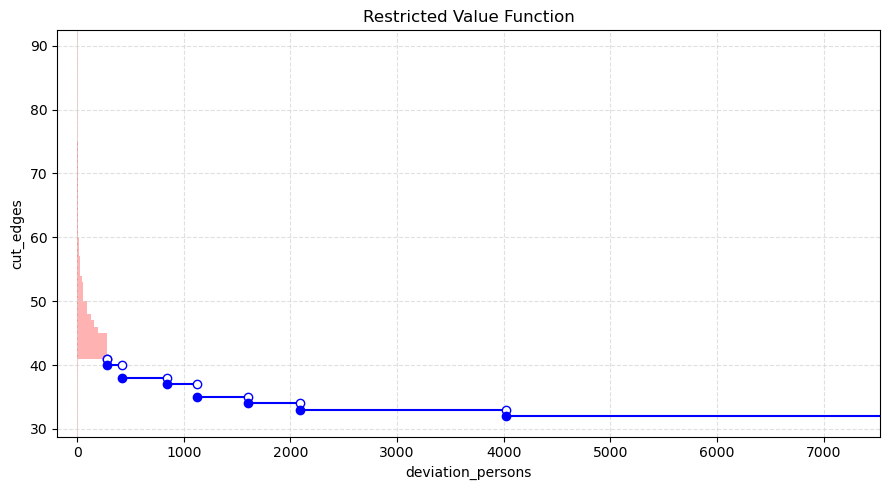

In [10]:
from pareto import plot_pareto_frontiers

plot_pareto_frontiers(
                G,
                method='epsilon_constraint_method',
                plans=None,                                   #if method ='epsilon_constraint_method' is None 
                obj_types=obj_type,                               
                ideal_population=G._ideal_population,
                state=state,
                filepath=filepath,
                filename2=filename2,
                no_solution_region=no_solution_region,
                year=year,
                result=result                               #if method ='heuristic' is None 
             )


####################################################################################################
Pareto maps for state AR, objective cut_edges
####################################################################################################



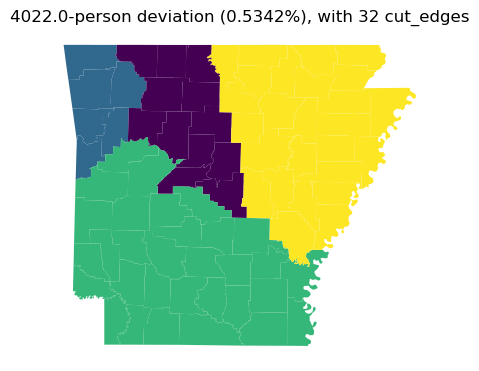

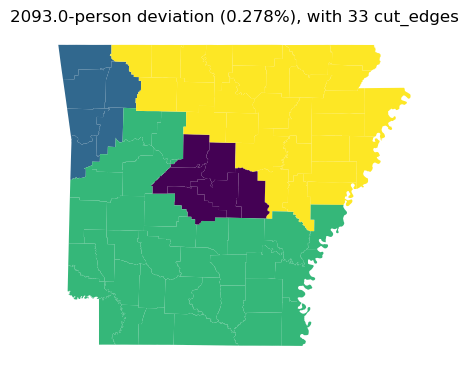

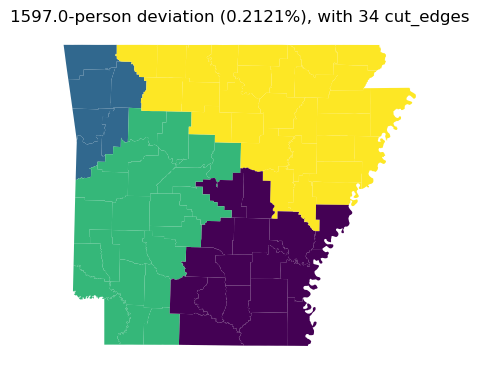

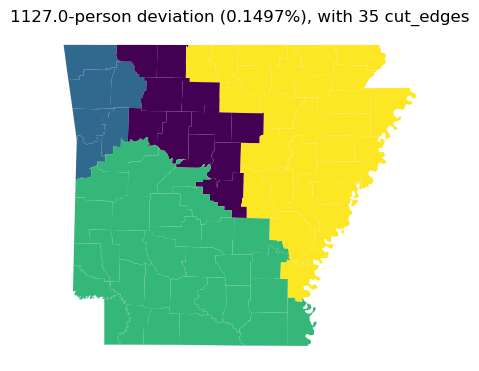

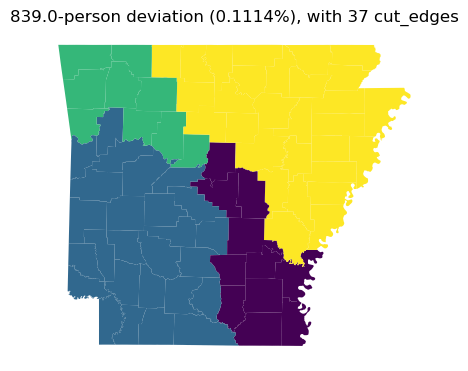

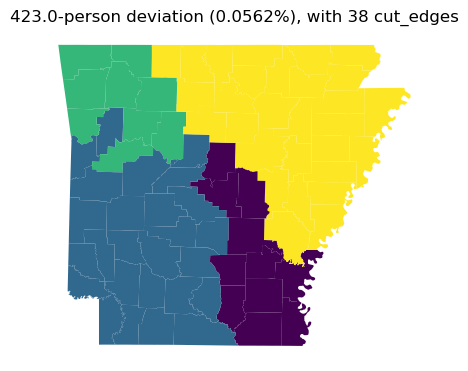

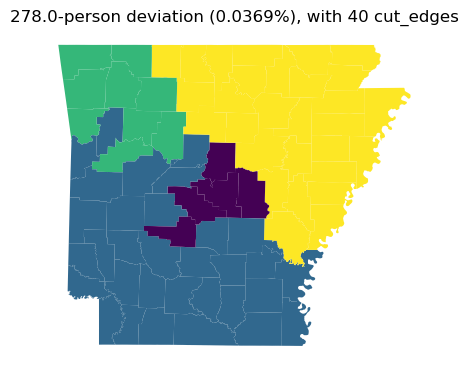

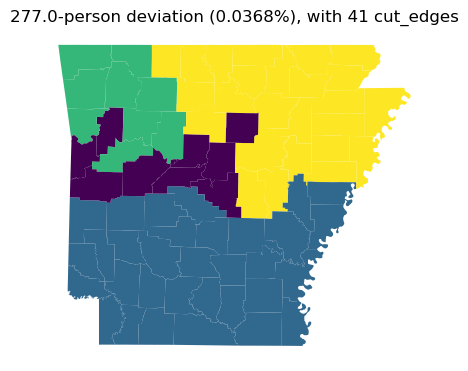

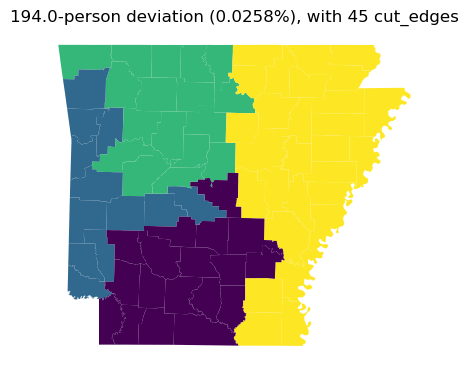

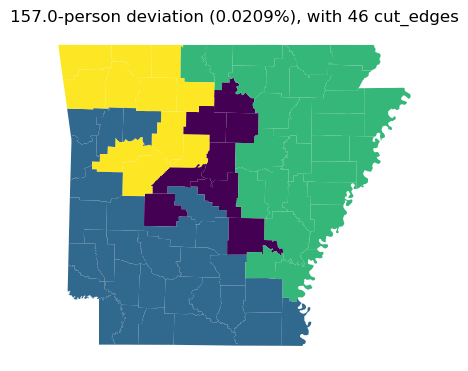

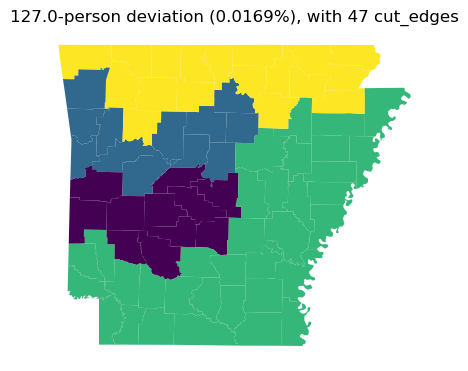

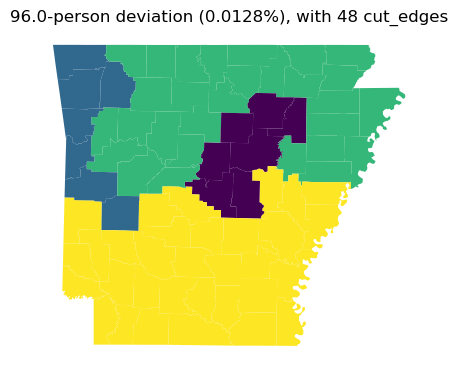

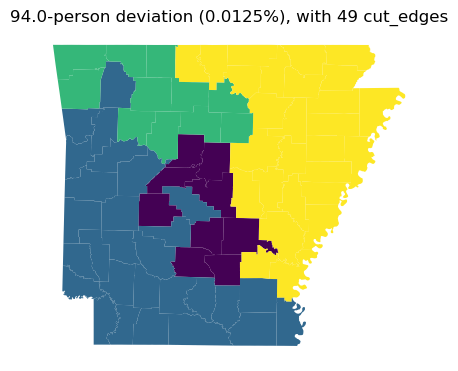

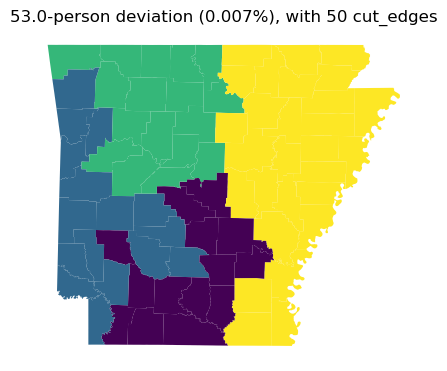

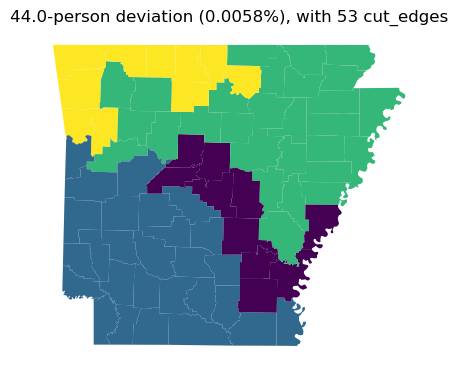

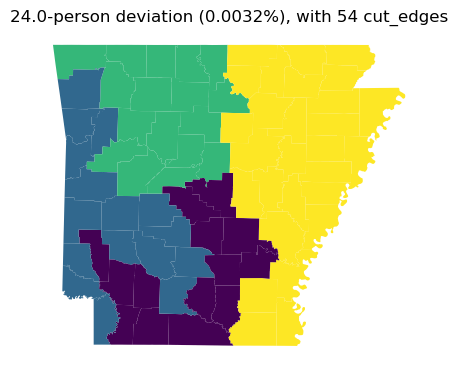

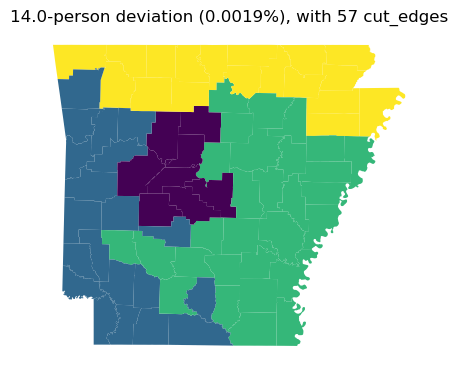

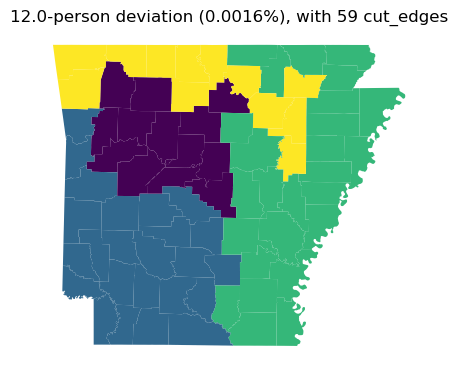

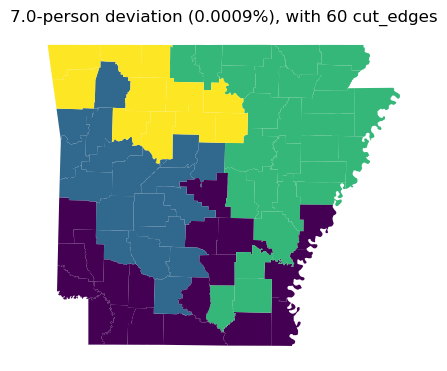

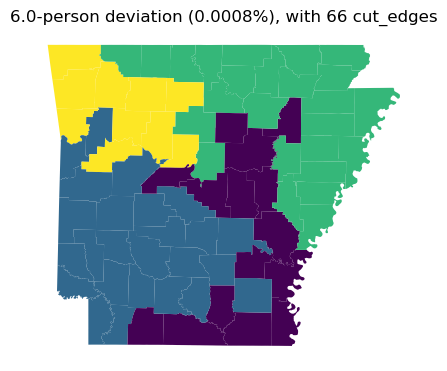

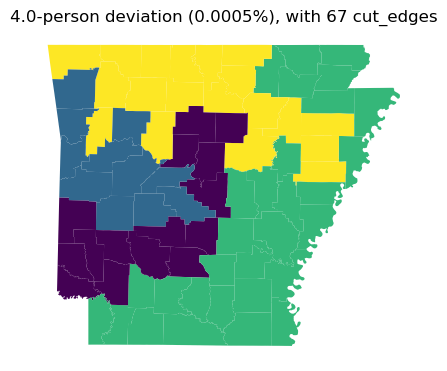

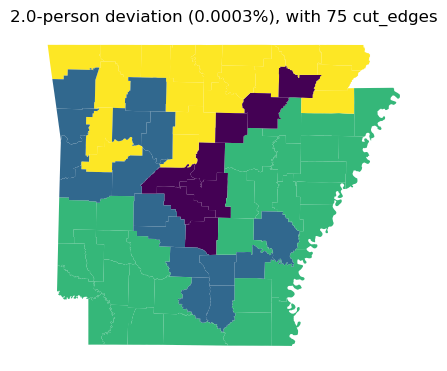

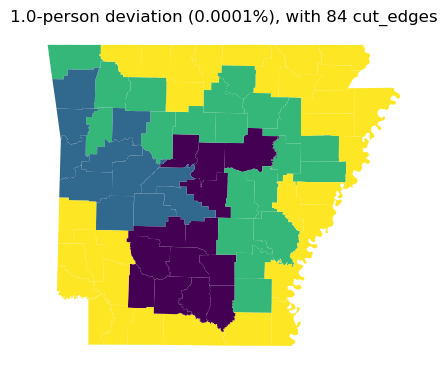

In [11]:
from draw import draw_plan
from metrics import observed_deviation_persons, compute_obj

print(f"\n{'#' * 100}\nPareto maps for state {state}, objective {obj_type}\n{'#' * 100}\n")

format_obj = {
    'bottleneck_Polsby_Popper': lambda x: round(1 /x, 4),
    'cut_edges': lambda x: int(x)}
G._L = 0
G._U = G._k * G._ideal_population

for plan, obj_bound, dev in result:
    obs_dev = observed_deviation_persons(G, plan, G._ideal_population)
    obj = compute_obj(G, plan, obj_type)
    obj_val = format_obj.get(obj_type, lambda x: round(x, 4))(obj)
    deviation_percentage = round(100 * dev / G._ideal_population, 4)
    title = f"{round(obs_dev, 2)}-person deviation ({deviation_percentage}%), with {obj_val} {obj_type}"
    draw_plan(filepath, filename2, G, plan, title=title, year=year)